<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

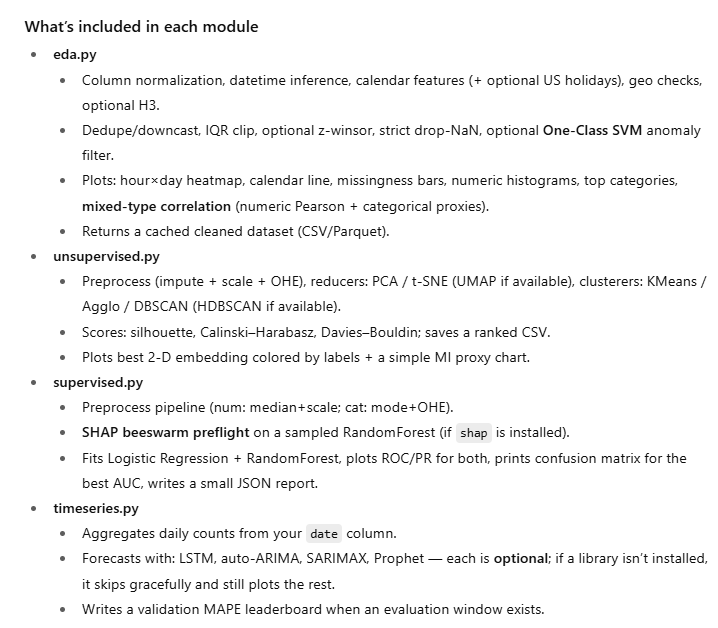



🔹 In Unsupervised

Gaussian Mixture Models (GMM / EM) (fits lecture notes).

Spectral Clustering (covered in the book, sec. 12.4).

Stability analysis (bootstrap clustering stability).

Cluster profiling (compare means/proportions of features across clusters).

Anomaly detection extension (tie clusters + outliers to highlight rare cases).

🔹 In Time Series

Compare ARIMA, Prophet, LSTM (classical + deep).

Stationarity tests (ADF, KPSS).

Hyperparameter grid search (p,d,q,P,D,Q).

Cross-validation with rolling/expanding window (instead of single split).

MAPE, RMSE, MAE metrics with plots.

🔹 In General (Report & Code)

Train/validation/test split explanation (required).

Overfitting prevention: dropout, early stopping, regularization.

Hyperparameter tuning process (grid/random search, report best params).

Runtime/complexity discussion (iterations, convergence speed).

Clear comparison tables for supervised & unsupervised results.

Visuals:

Calendar heatmaps (crime over time)

Spatial density plots (hexbin, ridgelines)

Cluster embedding plots

In [1]:
!pip install scikit-learn imbalanced-learn statsmodels seaborn holidays h3

In [2]:
from eda import run_eda

In [3]:
from supervised import quick_demo

In [4]:
from unsupervised import run_unsupervised

In [ ]:
from timeseries import run_timeseries

#Fast EDA

SMART LAPD DATA PROCESSING PIPELINE

1. Loading raw data...
Raw shape: (974477, 15)
Dropped 0 completely empty rows

2. Creating time-based features...
Using time column: Time_occured
Extracting hours from column: 'Time_occured'
Sample values: [2130, 1800, 1700, 2037, 1200]
Successfully extracted hours from 934971/974477 rows (95.9%)

Hour distribution (count and night rate):
      count  mean
hour             
1.0   29003   1.0
2.0   24572   1.0
3.0   21610   1.0
4.0   18281   1.0
5.0   16839   1.0
6.0   22393   1.0
7.0   25356   0.0
8.0   36142   0.0
9.0   35418   0.0
10.0  41737   0.0
11.0  42361   0.0
12.0  65775   0.0
13.0  44171   0.0
14.0  47749   0.0
15.0  51101   0.0
16.0  51345   0.0
17.0  56936   0.0
18.0  58043   0.0
19.0  53816   0.0
20.0  54491   0.0
21.0  49259   0.0
22.0  47571   1.0
23.0  41002   1.0
Night target created: 221271 night crimes, 753206 day crimes

3. Preparing victim sex for stratification...
Found victim sex column: Victim_sex
Victim sex distribution aft

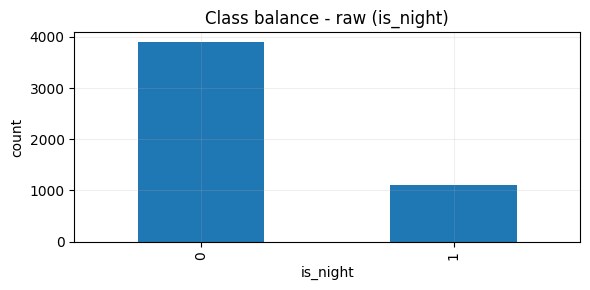

preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---raw.png


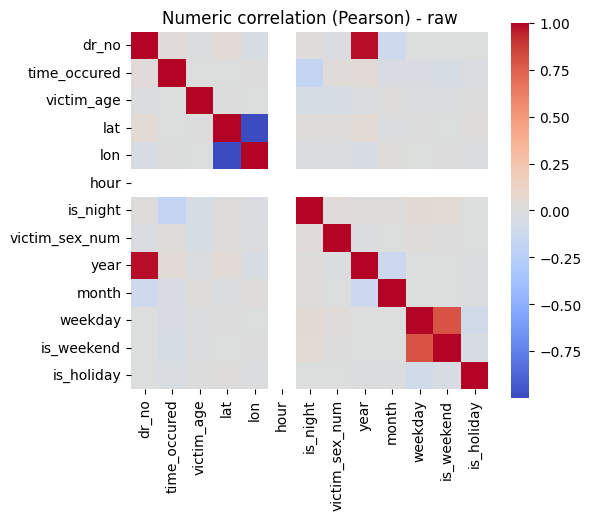

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---raw.png


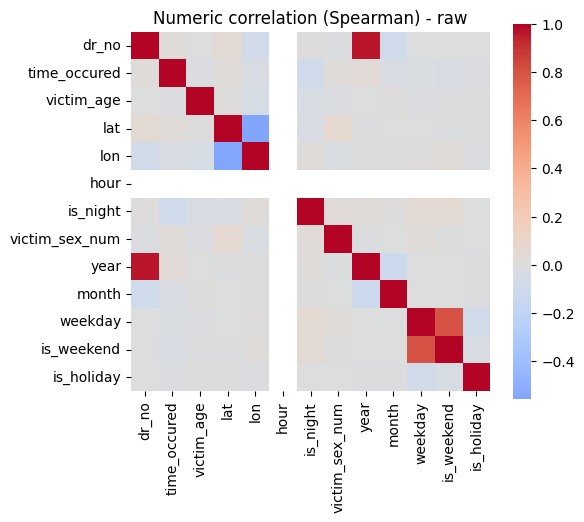

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---raw.png


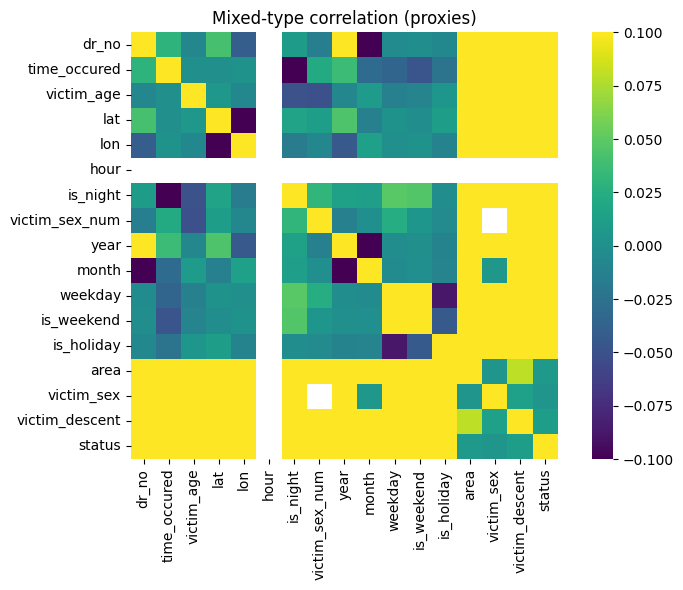

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---raw.png


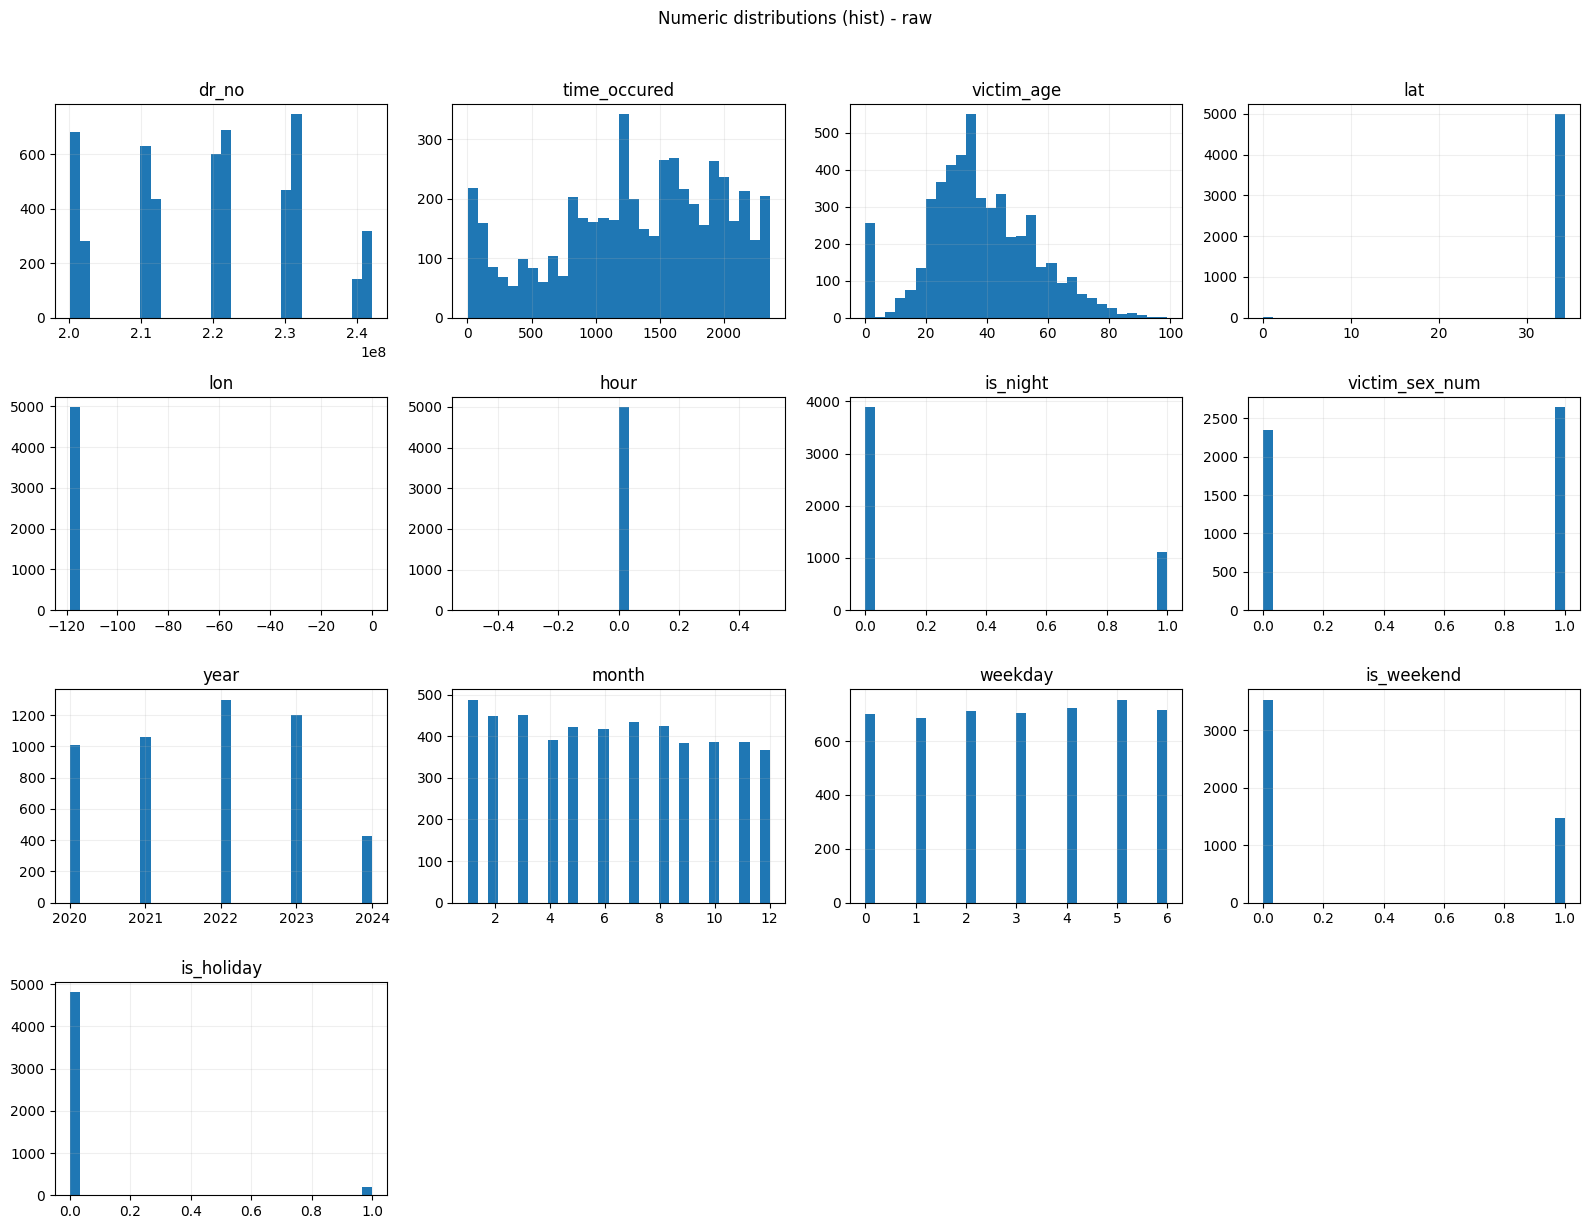

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
              issue  count
0  zero_zero_coords     13
1   outside_LA_bbox     13
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 99 / 4,999 rows
[LOF] flagged 98 / 4,900 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda/Missingness---cleaned.png


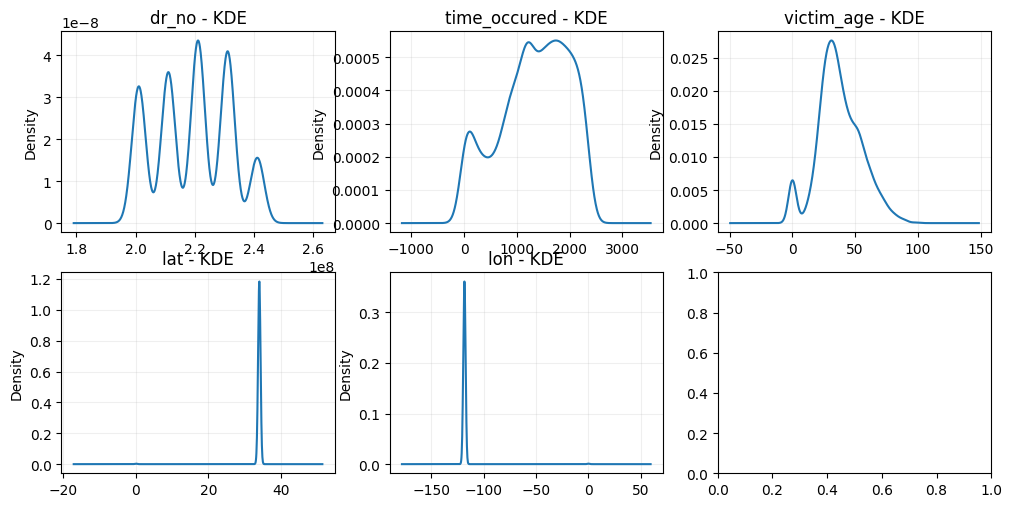

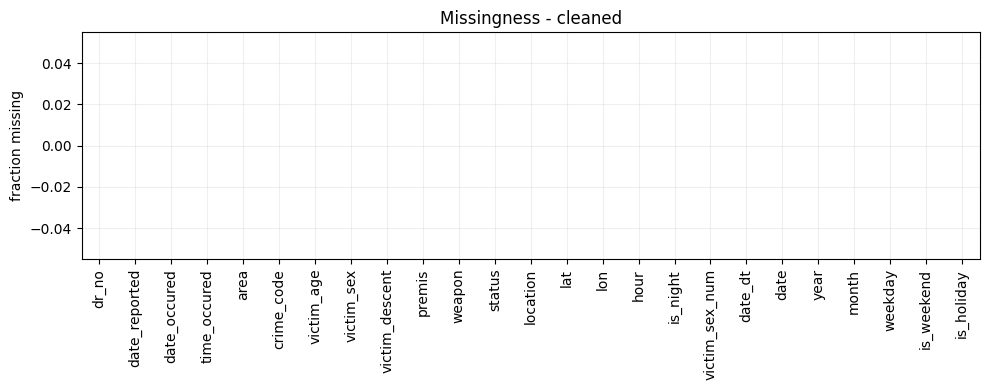

🗂️ saved: /content/figs_eda/Missingness-matrix---cleaned.png


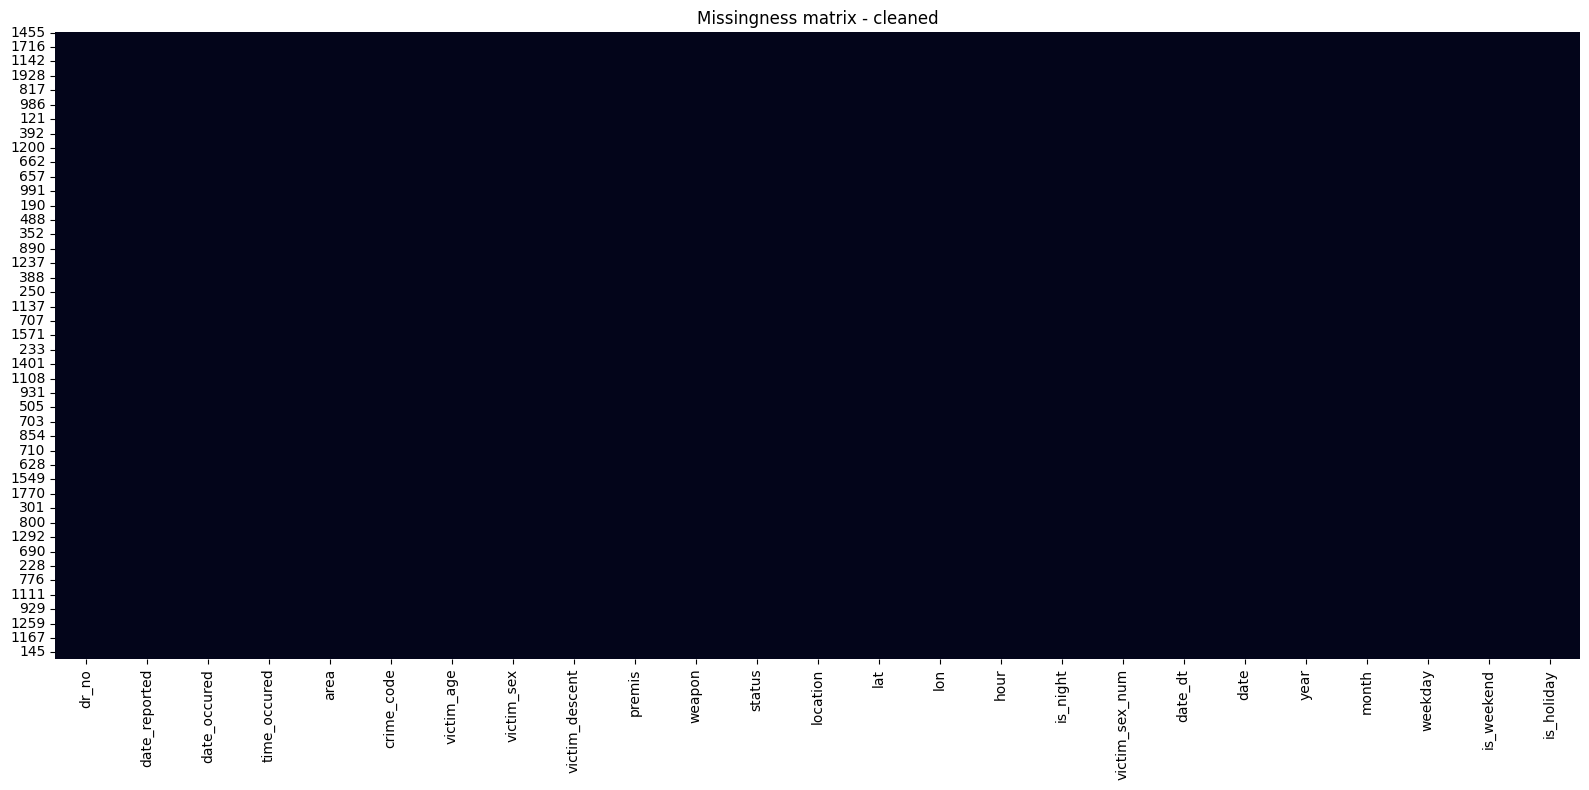

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---cleaned.png


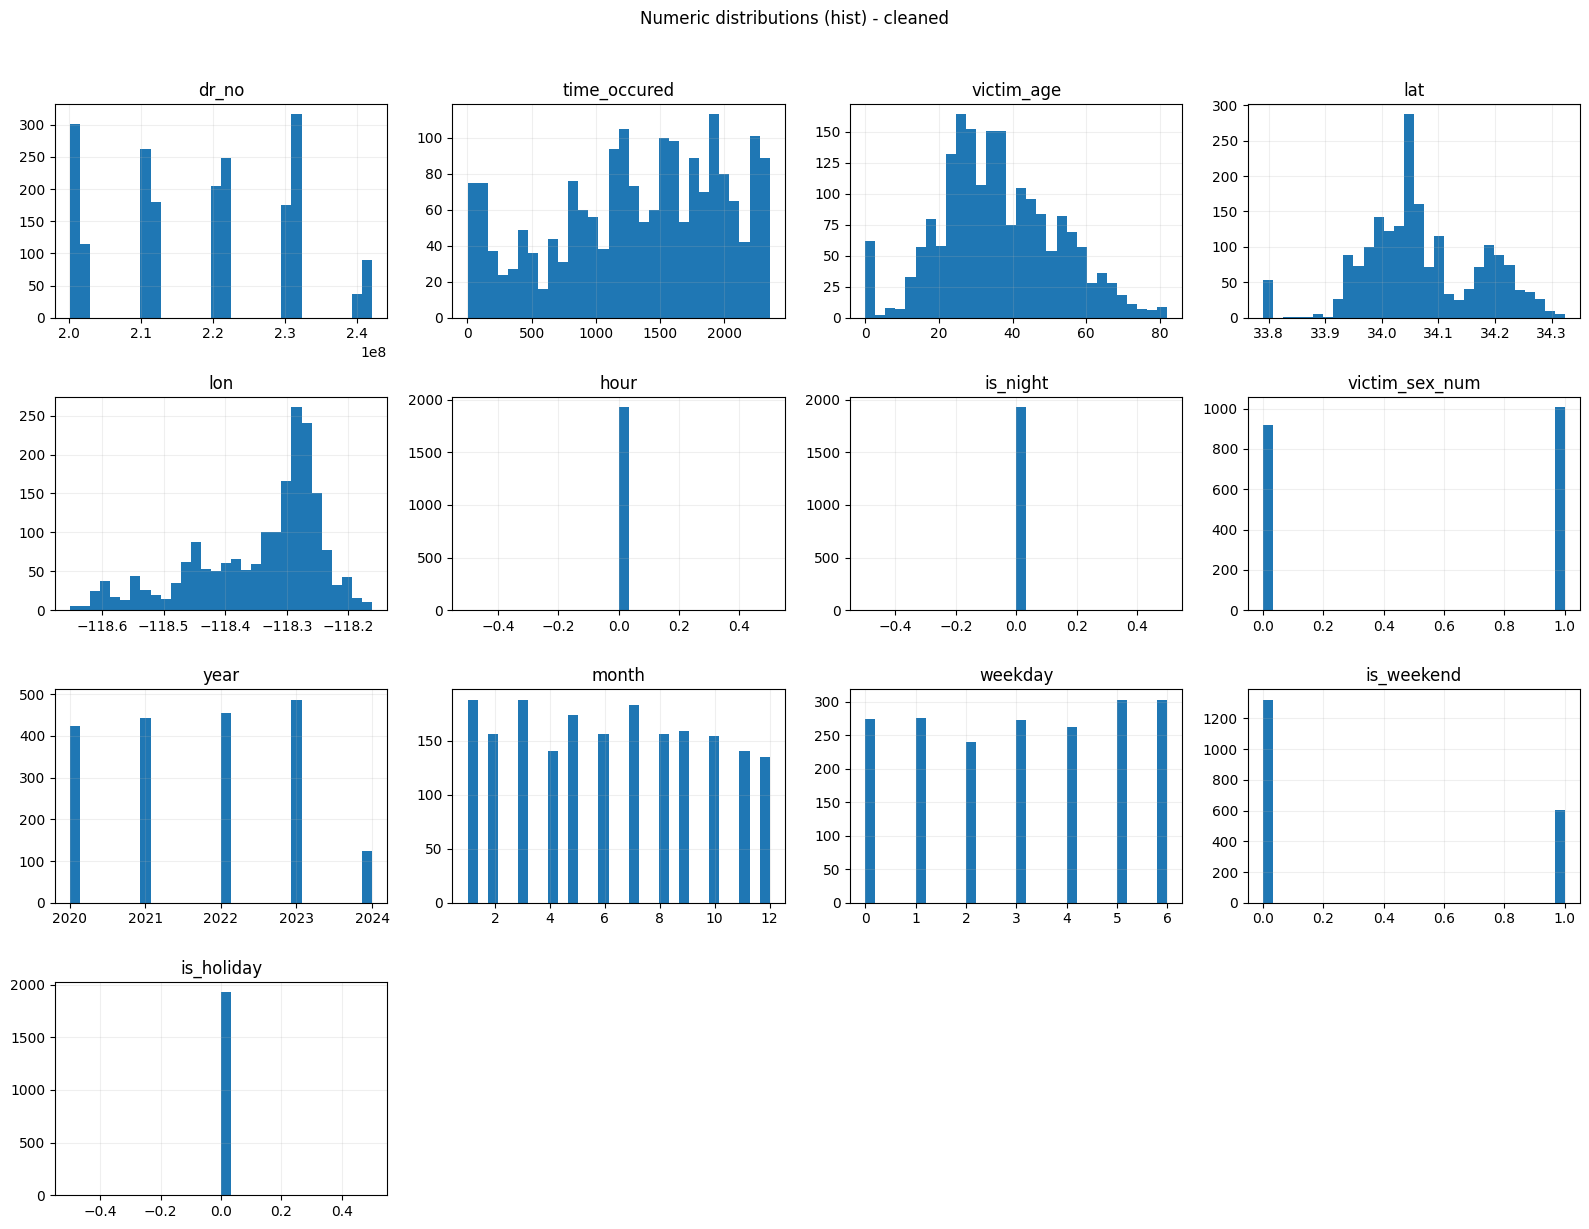

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---cleaned.png


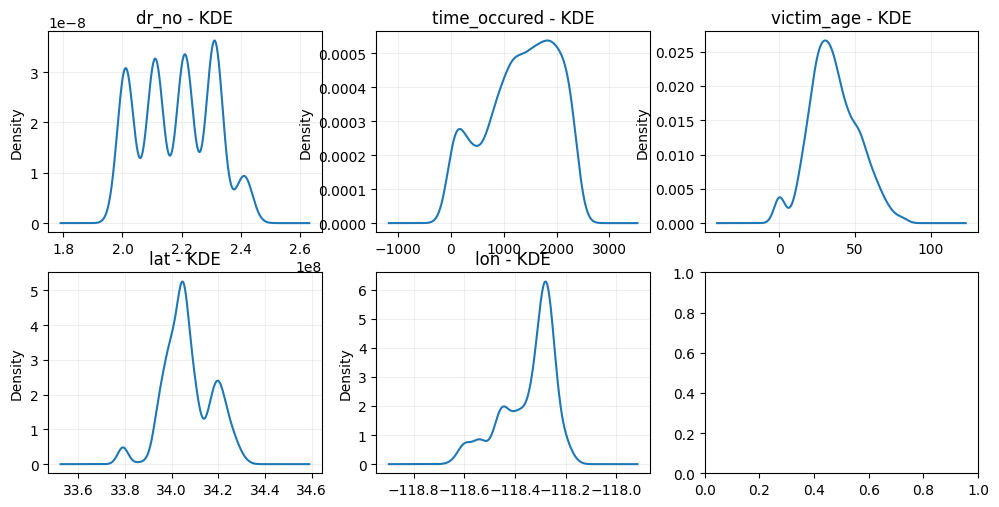

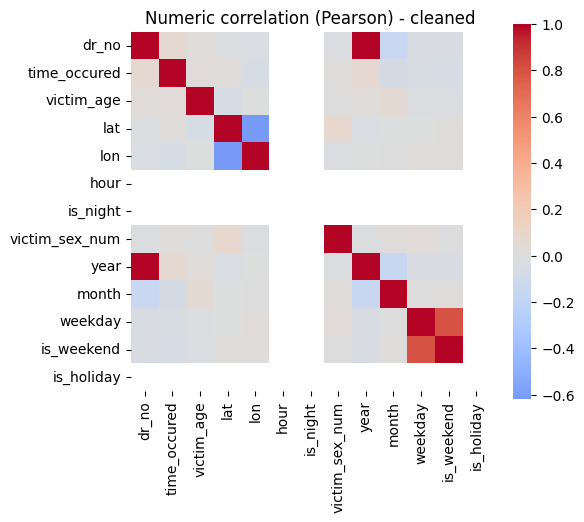

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---cleaned.png


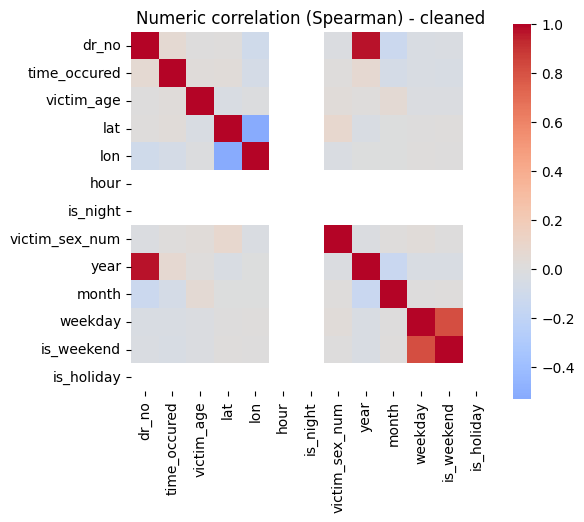

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---cleaned.png


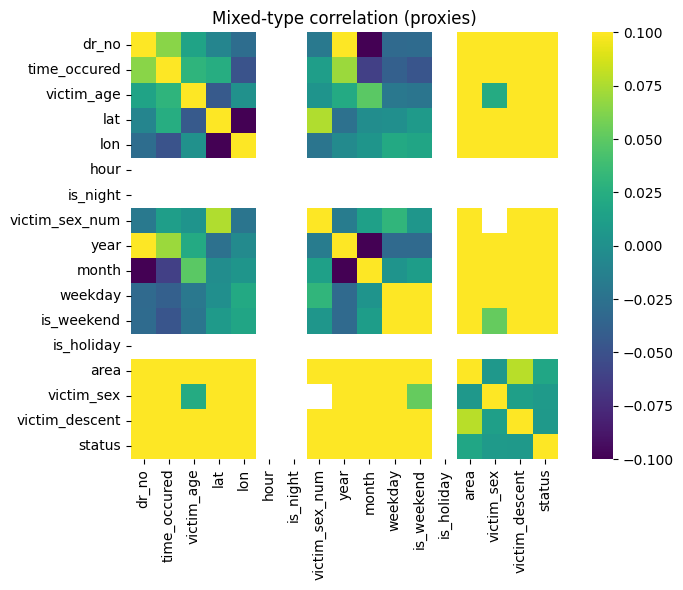

SMOTE failed; falling back to undersample: The target 'y' needs to have more than 1 class. Got 1 class instead
[Balance] target has <2 classes; skip.
🗂️ saved: /content/figs_eda/Mutual-Information-vs-is_night.png


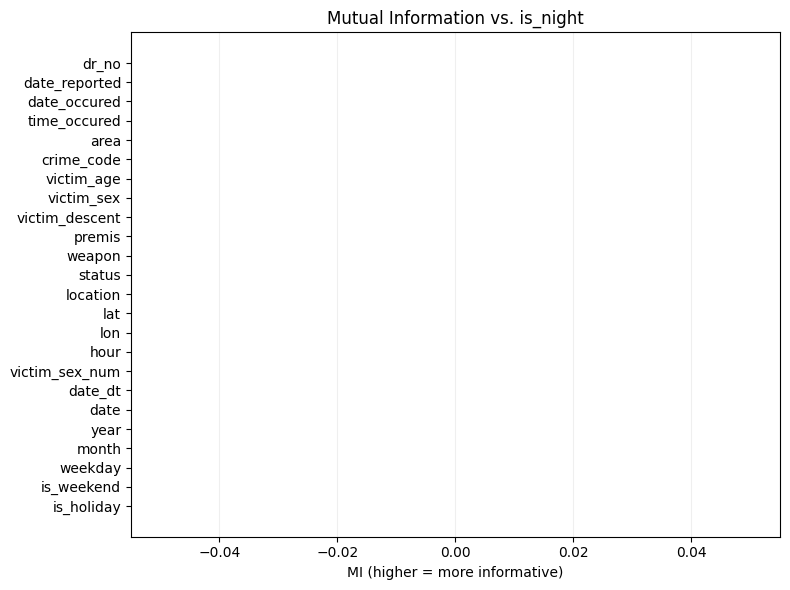

🗂️ saved: /content/figs_eda/RF-feature-importance.png


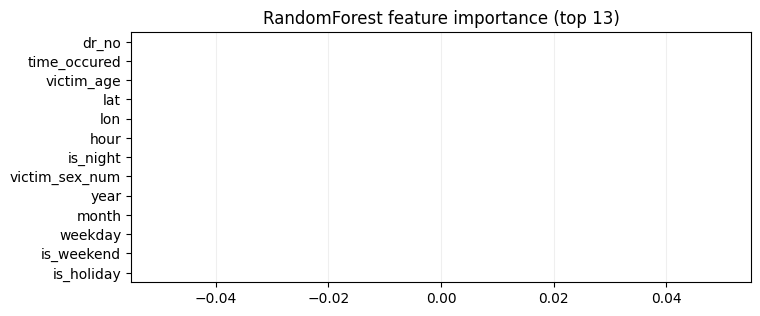

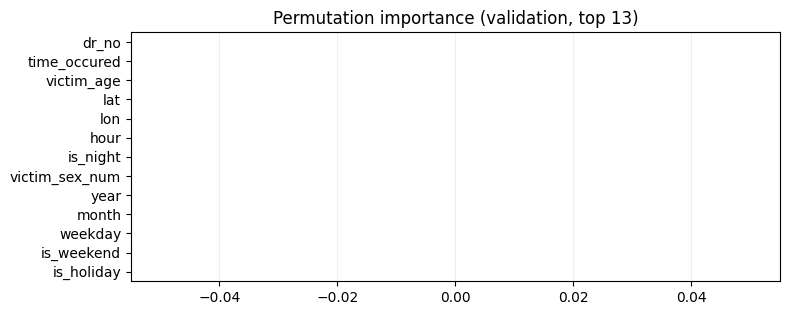

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean_final.parquet

Final dataset shape: (1929, 25)
Night distribution: {0.0: 1929}
Victim sex distribution: {1.0: 1008, 0.0: 921}
Final sample saved: /content/lapd_sample.parquet

PIPELINE COMPLETE


In [5]:
import pandas as pd
import numpy as np
from eda import run_eda
import os

# Configuration
SAMPLE_SIZE = 5000
RANDOM_STATE = 42
RAW_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
OUTPUT_DIR = "/content"

# Single EDA configuration - no duplicates
EDA_CONFIG = {
    "use_us_holidays": True,
    "add_h3": False,
    "iqr_clip": True,
    "iqr_multiplier": 1.5,
    "zscore_winsor": True,
    "zscore_max": 4.0,
    "drop_any_nan_after_features": True,
    "imbalance_target": "is_night",  # Set directly since we'll create it
    "balance_preview": True,
    "balance_method": "smote",
    "balance_max_n": 20000,
    "corr_pearson": True,
    "corr_spearman": True,
    "corr_mutual_info": True,
    "feature_importance": True,
    "plot_numeric_dists": True,
    "plot_kde_box": True,
    "missing_matrix": True,
    "outliers_iforest": True,
    "outliers_lof": True,
    "outliers_ocsvm": True,
    "outliers_max_frac": 0.02,
    "plot_corr": True,
    "vif_check": True,
}


def extract_hour_from_time(time_str):
    """
    Extract hour from various time formats.
    Handles: "1430" (24h), "14:30", "2:30 PM", etc.
    """
    if pd.isna(time_str):
        return np.nan

    time_str = str(time_str).strip()

    # Handle 24-hour format without colons (e.g., "1430")
    if time_str.isdigit() and len(time_str) >= 3:
        if len(time_str) == 3:  # e.g., "730" -> "07:30"
            hour = int(time_str[0])
        elif len(time_str) == 4:  # e.g., "1430" -> "14:30"
            hour = int(time_str[:2])
        else:
            return np.nan
        return hour if 0 <= hour <= 23 else np.nan

    # Handle formats with colons or AM/PM
    try:
        # Try parsing with pandas
        parsed_time = pd.to_datetime(time_str, format='%H:%M', errors='coerce')
        if pd.notna(parsed_time):
            return parsed_time.hour

        # Try with AM/PM
        parsed_time = pd.to_datetime(time_str, format='%I:%M %p', errors='coerce')
        if pd.notna(parsed_time):
            return parsed_time.hour

        # Try just hour extraction from various formats
        if ':' in time_str:
            hour_part = time_str.split(':')[0]
            if 'PM' in time_str.upper() or 'AM' in time_str.upper():
                hour = int(hour_part)
                if 'PM' in time_str.upper() and hour != 12:
                    hour += 12
                elif 'AM' in time_str.upper() and hour == 12:
                    hour = 0
                return hour if 0 <= hour <= 23 else np.nan
            else:
                hour = int(hour_part)
                return hour if 0 <= hour <= 23 else np.nan

    except (ValueError, IndexError):
        pass

    return np.nan


def create_night_target(df):
    """
    Create is_night target with proper hour extraction and night definition.
    Night hours: 10 PM to 6 AM (22:00 to 06:00)
    """
    # Find time column - common names in LAPD data
    time_cols = ['TIME OCC', 'time_occ', 'time', 'Time', 'TIME']
    time_col = None

    for col in time_cols:
        if col in df.columns:
            time_col = col
            break

    if time_col is None:
        # Try to find any column with 'time' in name
        time_candidates = [col for col in df.columns if 'time' in col.lower()]
        if time_candidates:
            time_col = time_candidates[0]
            print(f"Using time column: {time_col}")

    if time_col is None:
        raise ValueError("No time column found. Available columns: " + str(list(df.columns)))

    print(f"Extracting hours from column: '{time_col}'")
    print(f"Sample values: {df[time_col].head().tolist()}")

    # Extract hours
    df['hour'] = df[time_col].apply(extract_hour_from_time)

    # Check extraction success
    valid_hours = df['hour'].notna().sum()
    total_rows = len(df)
    print(f"Successfully extracted hours from {valid_hours}/{total_rows} rows ({valid_hours/total_rows*100:.1f}%)")

    if valid_hours < total_rows * 0.5:
        print(f"Warning: Only extracted valid hours from {valid_hours/total_rows*100:.1f}% of rows")
        print("Sample failed extractions:")
        failed_sample = df[df['hour'].isna()][time_col].head()
        print(failed_sample.tolist())

    # Create night target: 10 PM (22:00) to 6 AM (06:00)
    # This is more realistic than 8 PM to 6 AM
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

    # Show hour distribution
    if df['hour'].notna().any():
        hour_dist = df.groupby('hour')['is_night'].agg(['count', 'mean']).round(3)
        print("\nHour distribution (count and night rate):")
        print(hour_dist)

    return df


def find_victim_sex_column(df):
    """Find victim sex column with various naming conventions."""
    sex_aliases = [
        'vict sex', 'vict_sex', 'victim_sex', 'victim sex',
        'victimsex', 'sex', 'gender', 'vict_gender'
    ]

    # Exact match first
    for alias in sex_aliases:
        if alias in df.columns:
            return alias

    # Case-insensitive partial match
    for col in df.columns:
        col_lower = col.lower().replace(' ', '_')
        for alias in sex_aliases:
            alias_clean = alias.lower().replace(' ', '_')
            if alias_clean in col_lower or col_lower in alias_clean:
                return col

    return None


def clean_victim_sex(df, sex_col):
    """Clean and standardize victim sex values."""
    if sex_col not in df.columns:
        return df

    # Standardize values
    df[sex_col] = (
        df[sex_col]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace({
            'U': 'UNKNOWN', 'X': 'UNKNOWN', '-': 'UNKNOWN',
            'N': 'UNKNOWN', '': 'UNKNOWN', 'NAN': 'UNKNOWN',
            'MALE': 'M', 'FEMALE': 'F'
        })
    )

    print(f"Victim sex distribution after cleaning:\n{df[sex_col].value_counts()}")
    return df


def create_stratified_sample(df, stratify_col, sample_size, random_state=42):
    """Create stratified sample maintaining proportions."""
    if len(df) <= sample_size:
        return df.copy()

    # Calculate proportional sample sizes
    value_counts = df[stratify_col].value_counts()
    total = len(df)

    sampled_parts = []
    remaining_budget = sample_size

    for value, count in value_counts.items():
        if remaining_budget <= 0:
            break

        # Proportional allocation with minimum 1
        target_n = max(1, int((count / total) * sample_size))
        actual_n = min(target_n, count, remaining_budget)

        subset = df[df[stratify_col] == value].sample(n=actual_n, random_state=random_state)
        sampled_parts.append(subset)
        remaining_budget -= actual_n

    result = pd.concat(sampled_parts, ignore_index=True)

    # Shuffle the final result
    return result.sample(frac=1.0, random_state=random_state).reset_index(drop=True)


def main():
    """Main processing pipeline."""
    print("=" * 60)
    print("SMART LAPD DATA PROCESSING PIPELINE")
    print("=" * 60)

    # 1. Load and initial cleaning
    print("\n1. Loading raw data...")
    df = pd.read_csv(RAW_PATH, low_memory=False, compression='infer')
    print(f"Raw shape: {df.shape}")

    # Clean missing values
    missing_sentinels = ["", " ", "NA", "N/A", "na", "n/a", "None", "NONE",
                        "null", "NULL", "?", "-", "--", "nan", "NaN"]
    df = df.replace(missing_sentinels, np.nan)

    # Drop rows with all missing values
    before_drop = len(df)
    df = df.dropna(how='all').reset_index(drop=True)
    print(f"Dropped {before_drop - len(df):,} completely empty rows")

    # 2. Create hour and night target BEFORE EDA
    print("\n2. Creating time-based features...")
    try:
        df = create_night_target(df)
        night_counts = df['is_night'].value_counts()
        print(f"Night target created: {night_counts[1]} night crimes, {night_counts[0]} day crimes")
    except Exception as e:
        print(f"Failed to create night target: {e}")
        return

    # 3. Clean victim sex for stratification
    print("\n3. Preparing victim sex for stratification...")
    sex_col = find_victim_sex_column(df)
    if sex_col:
        print(f"Found victim sex column: {sex_col}")
        df = clean_victim_sex(df, sex_col)

        # Create numeric version for ML
        df['victim_sex_num'] = df[sex_col].map({'F': 0, 'M': 1})
        mf_only = df[df[sex_col].isin(['M', 'F'])].copy()
        print(f"Rows with M/F victim sex: {len(mf_only):,}")
    else:
        print("Warning: No victim sex column found")
        mf_only = df.copy()
        sex_col = None

    # 4. Create stratified sample BEFORE EDA to save time
    print(f"\n4. Creating stratified sample...")
    if len(mf_only) > SAMPLE_SIZE and sex_col:
        df_sample = create_stratified_sample(mf_only, sex_col, SAMPLE_SIZE, RANDOM_STATE)
        print(f"Sample shape: {df_sample.shape}")
        if sex_col:
            print(f"Sample sex distribution:\n{df_sample[sex_col].value_counts()}")
    else:
        df_sample = mf_only.copy()
        print(f"Using full dataset: {df_sample.shape}")

    # Save intermediate sample
    temp_csv = os.path.join(OUTPUT_DIR, "temp_sample_with_target.csv")
    df_sample.to_csv(temp_csv, index=False)

    # 5. Run EDA once on the sample with target
    print(f"\n5. Running EDA on sample with target...")
    clean_path = run_eda(
        raw_csv_path=temp_csv,
        fig_dir=os.path.join(OUTPUT_DIR, "figs_eda"),
        cache_path=os.path.join(OUTPUT_DIR, "lapd_clean_final.parquet"),
        config_overrides=EDA_CONFIG
    )

    # 6. Final output
    final_df = pd.read_parquet(clean_path)
    print(f"\nFinal dataset shape: {final_df.shape}")

    # Verify targets exist
    if 'is_night' in final_df.columns:
        print(f"Night distribution: {final_df['is_night'].value_counts().to_dict()}")
    if 'victim_sex_num' in final_df.columns:
        print(f"Victim sex distribution: {final_df['victim_sex_num'].value_counts().to_dict()}")

    # Save final sample for ML
    sample_output = os.path.join(OUTPUT_DIR, "lapd_sample.parquet")
    final_df.to_parquet(sample_output, index=False)
    print(f"Final sample saved: {sample_output}")

    # Cleanup
    if os.path.exists(temp_csv):
        os.remove(temp_csv)

    print("\n" + "=" * 60)
    print("PIPELINE COMPLETE")
    print("=" * 60)
    return clean_path


if __name__ == "__main__":
    main()

# EDA

==== [RUNNER] Read CSV/ZIP & strict full-row drop ====
[Runner] Raw shape: (974477, 15)
[Runner] Strict dropna removed 648,974 rows; remaining 325,503.
[Runner] Post-drop shape: (325503, 15)

Running comprehensive EDA pipeline on strictly-complete data...
==== [EDA-1] Read CSV/ZIP ====
Using date column: Date_occured
shape: (325503, 22)
==== [EDA-2] Normalize column names ====
==== [EDA-3] Build datetime + add time features ====
preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---raw.png


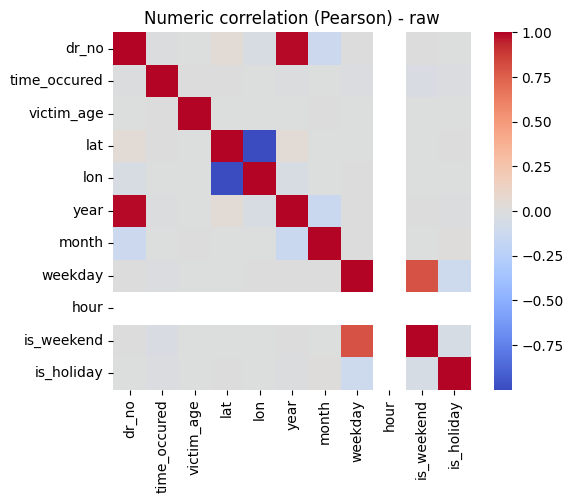

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---raw.png


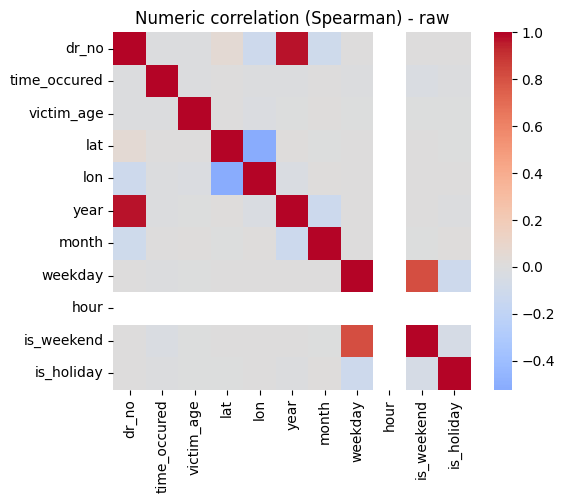

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---raw.png


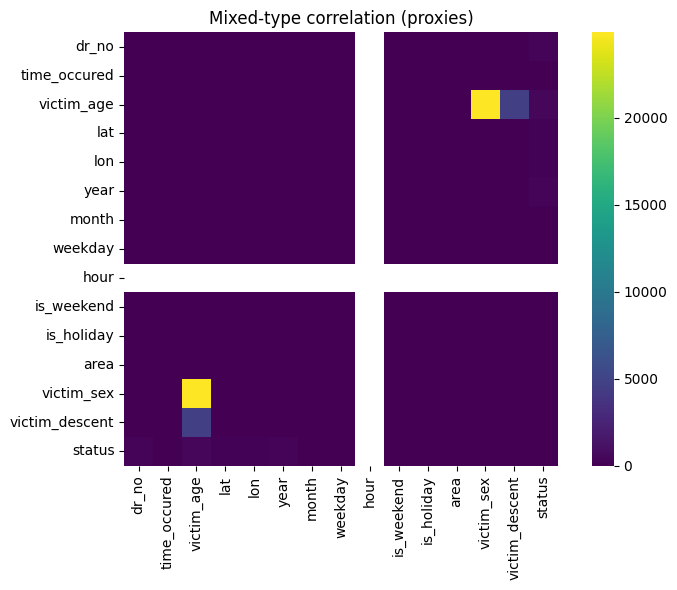

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---raw.png


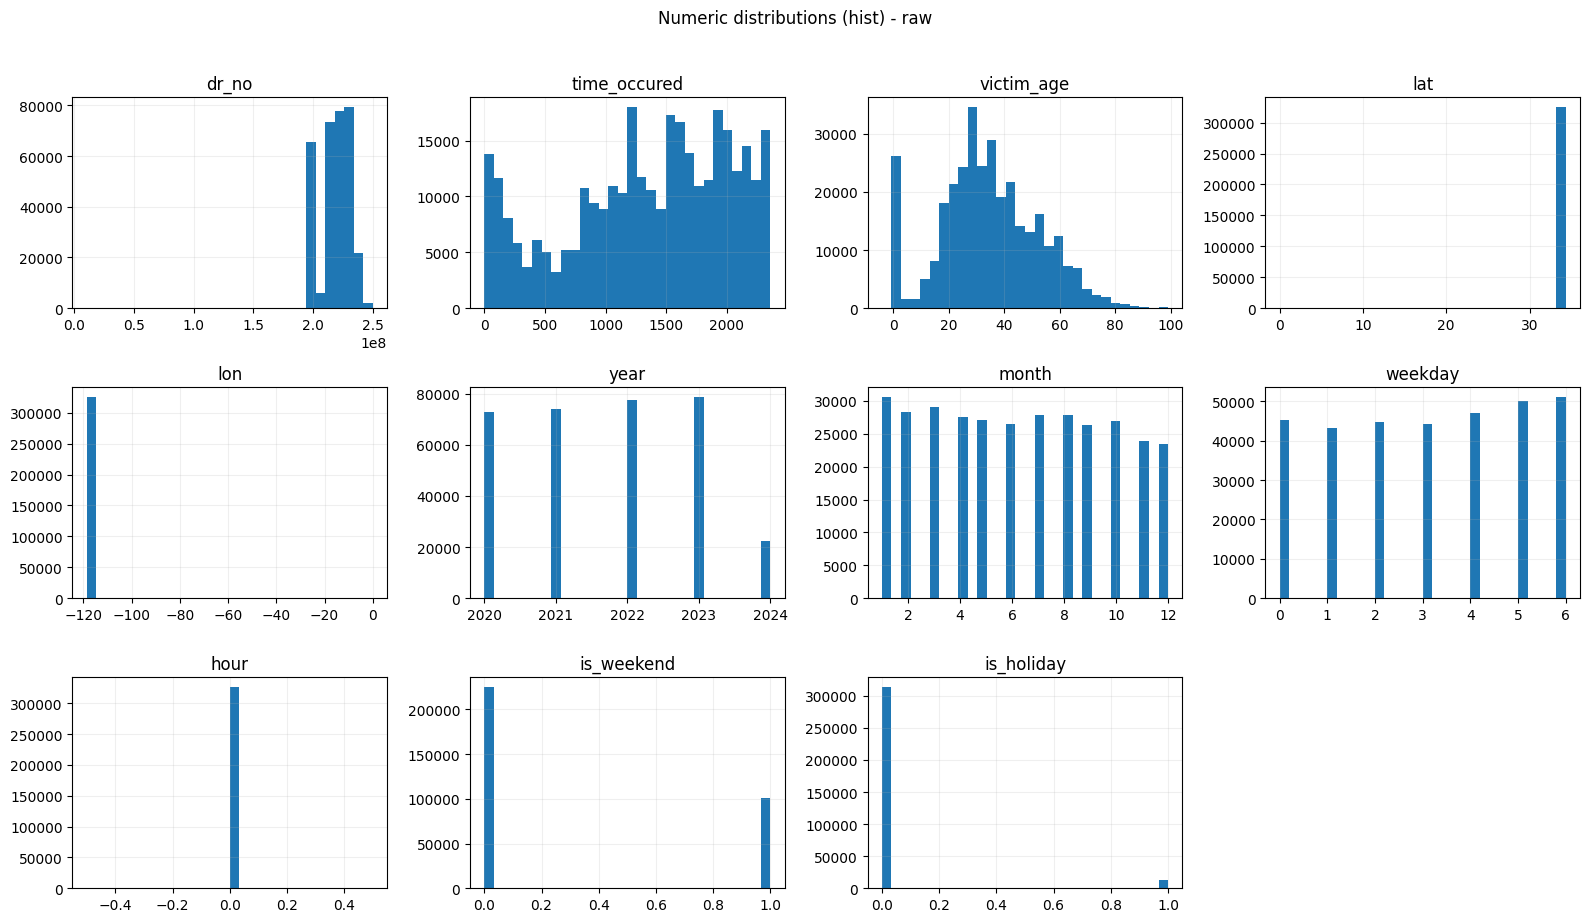

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
              issue  count
0  zero_zero_coords    833
1   outside_LA_bbox    833
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 6,510 / 325,503 rows
[LOF] flagged 6,379 / 318,993 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda/Missingness---cleaned.png


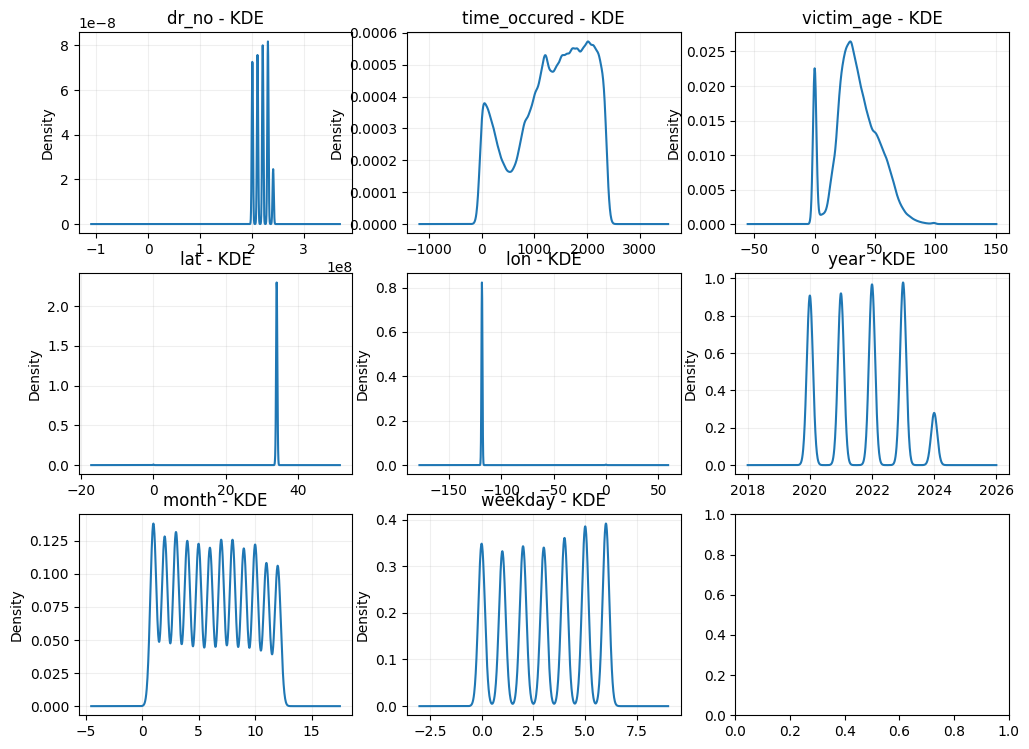

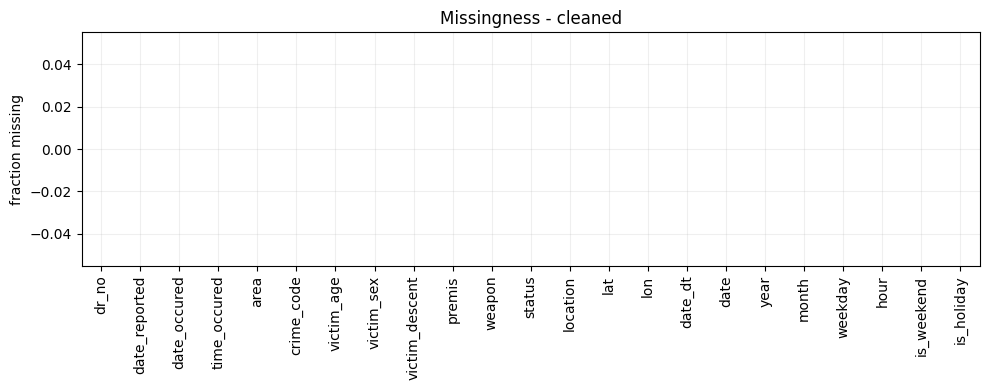

🗂️ saved: /content/figs_eda/Missingness-matrix---cleaned.png


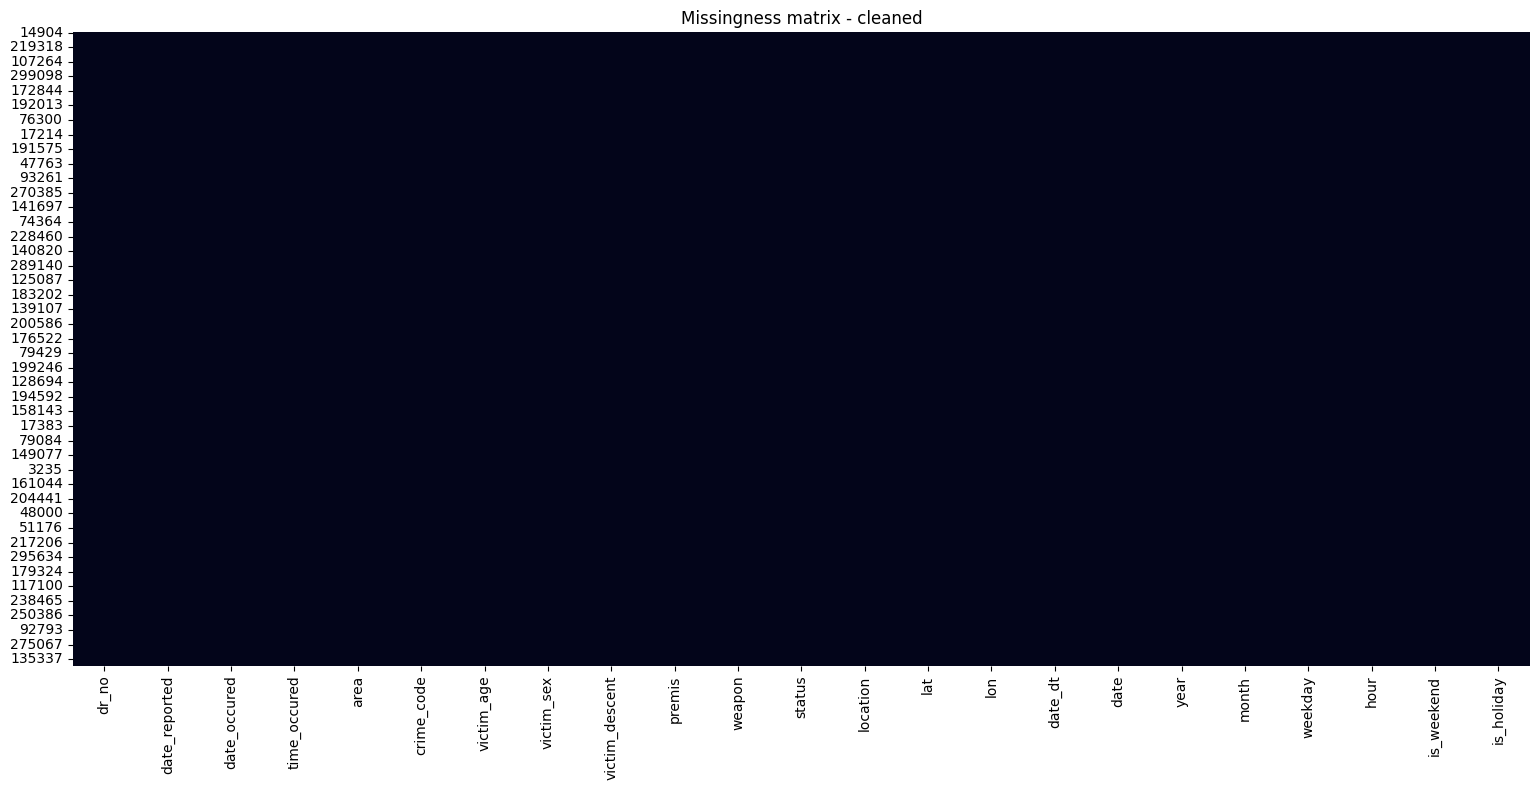

🗂️ saved: /content/figs_eda/Numeric-distributions-(hist)---cleaned.png


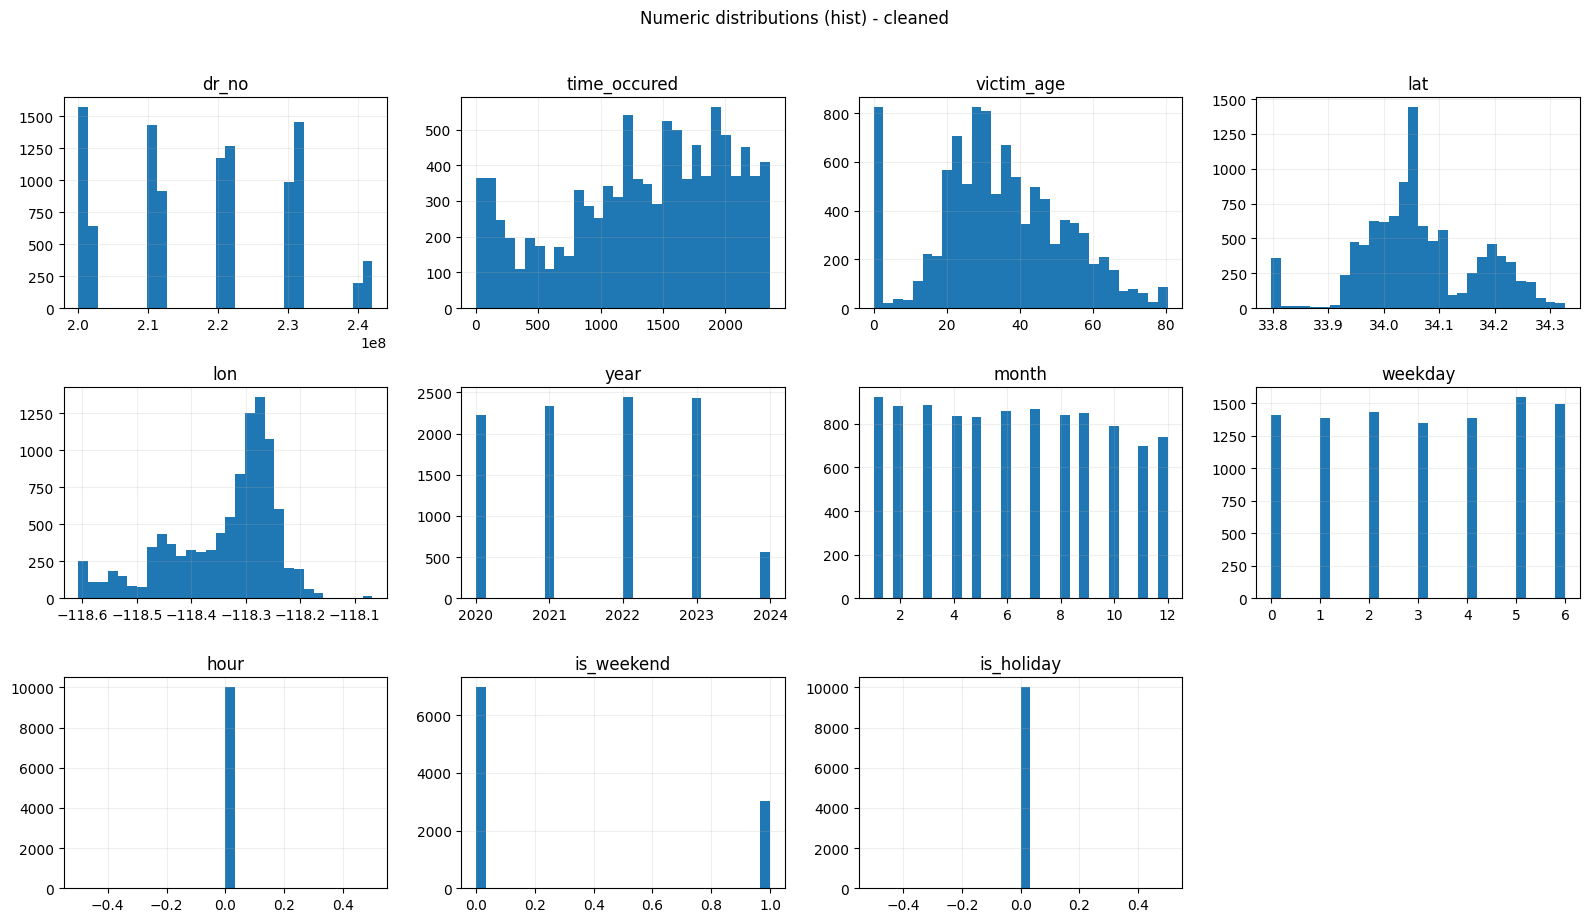

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda/Numeric-correlation-(Pearson)---cleaned.png


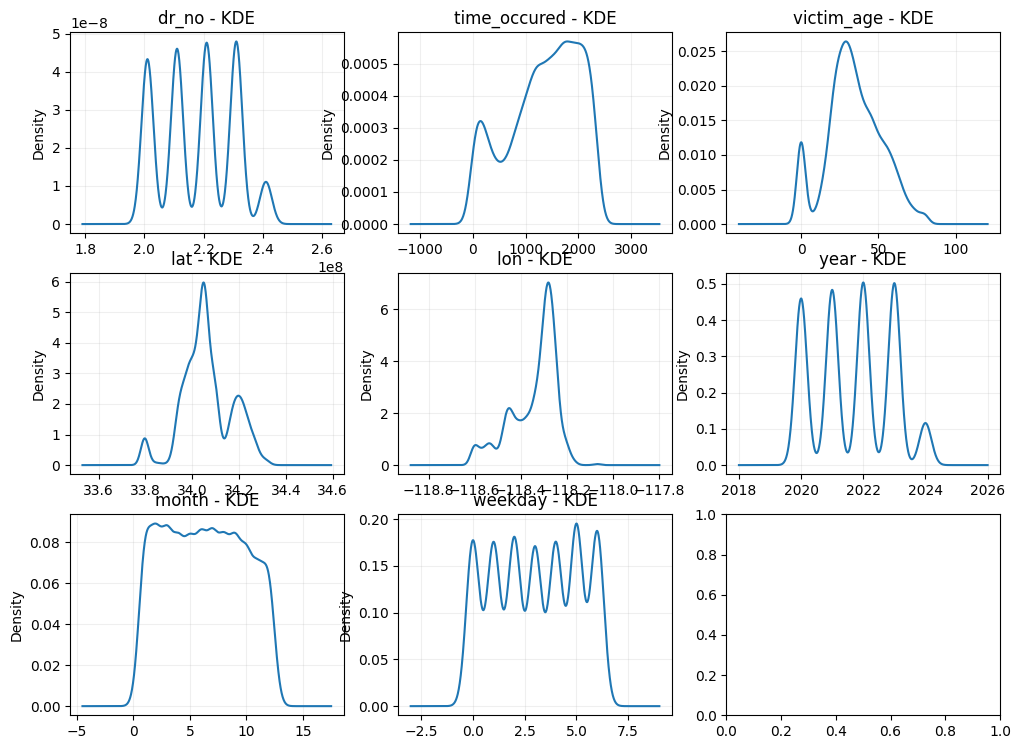

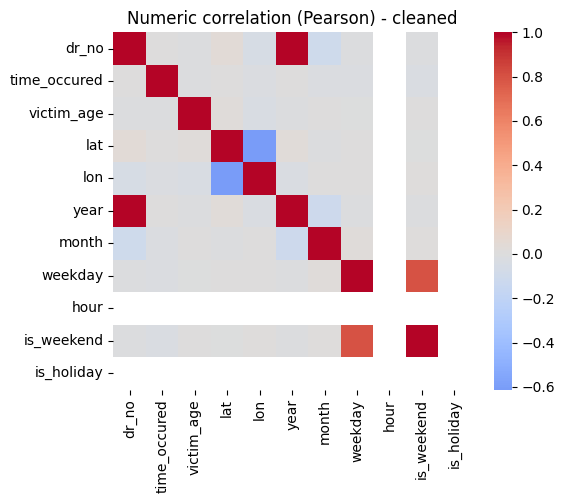

🗂️ saved: /content/figs_eda/Numeric-correlation-(Spearman)---cleaned.png


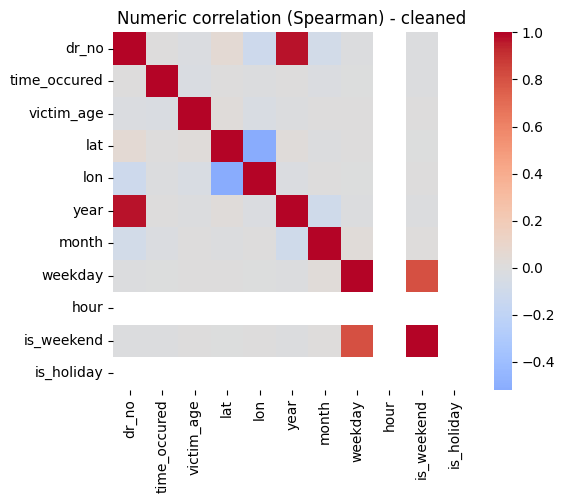

🗂️ saved: /content/figs_eda/Mixed-correlations-(num-+-cat)---cleaned.png


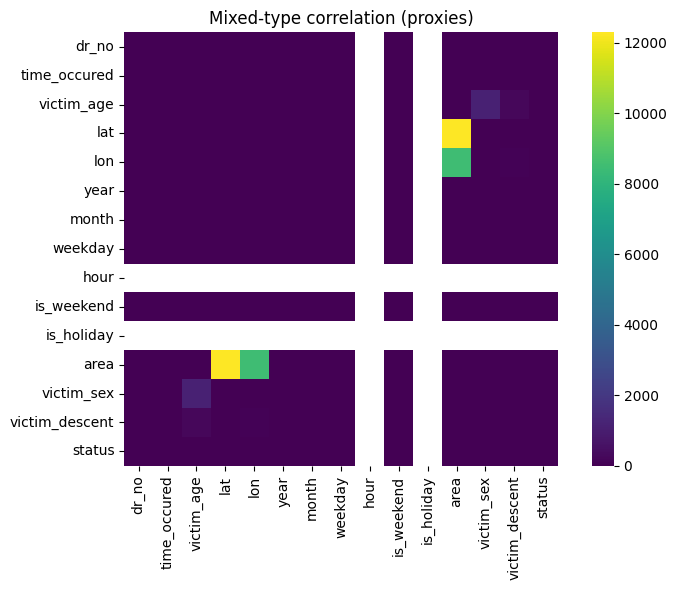

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean.parquet
Loading cleaned data returned by EDA...
[EDA output] Cleaned data shape: (312614, 23)
Created is_night target:
is_night
1    312614
Name: count, dtype: int64

Re-running EDA with target variable for class-specific analysis...
==== [EDA-1] Read CSV/ZIP ====
Using date column: date
shape: (312614, 24)
==== [EDA-2] Normalize column names ====
==== [EDA-3] Build datetime + add time features ====
🗂️ saved: /content/figs_eda_with_target/class_balance_raw_is_night.png


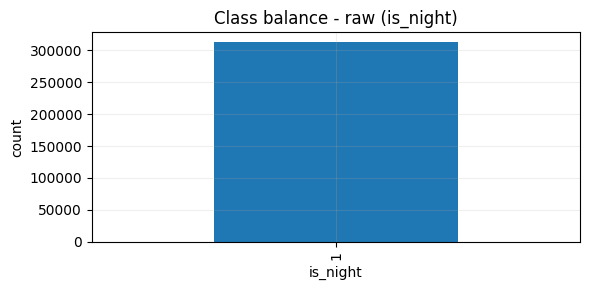

preview time plots skipped: Grouper for 'hour' not 1-dimensional
🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Pearson)---raw.png


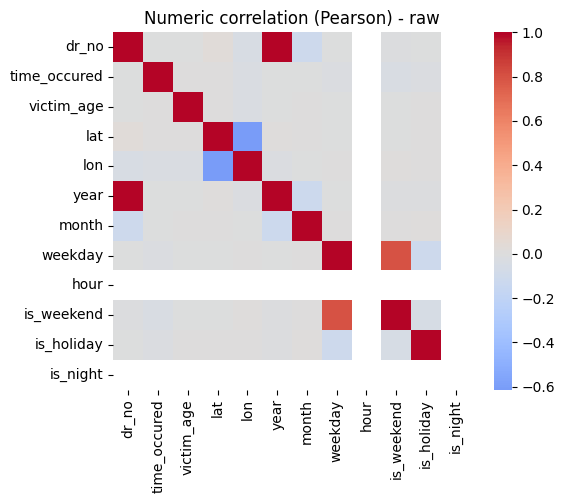

🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Spearman)---raw.png


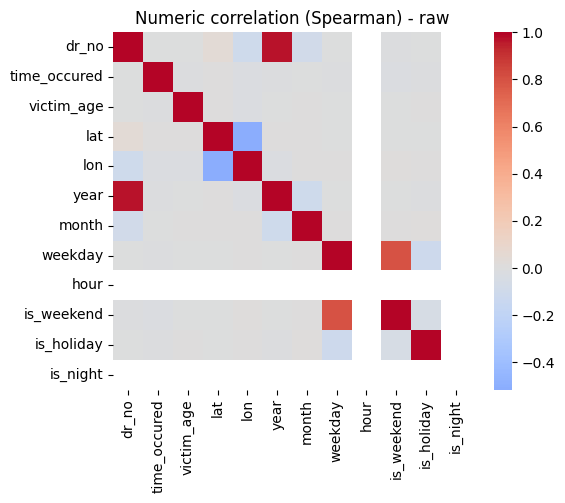

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat)---raw.png


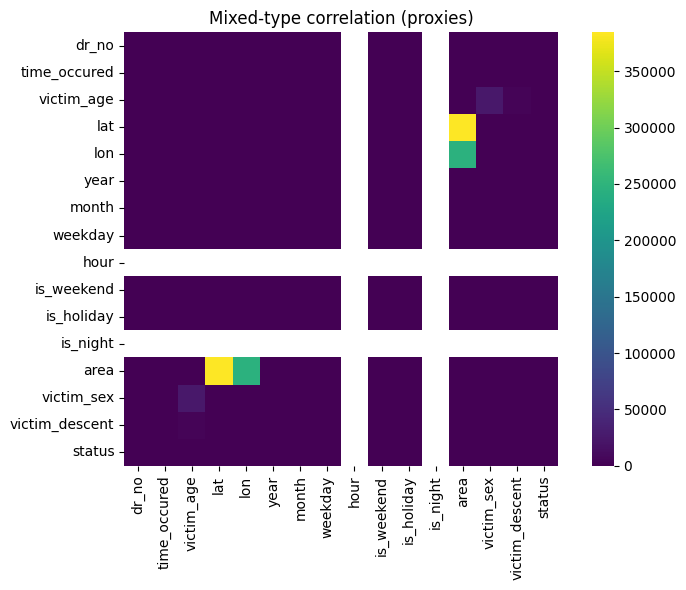

🗂️ saved: /content/figs_eda_with_target/Numeric-distributions-(hist)---raw.png


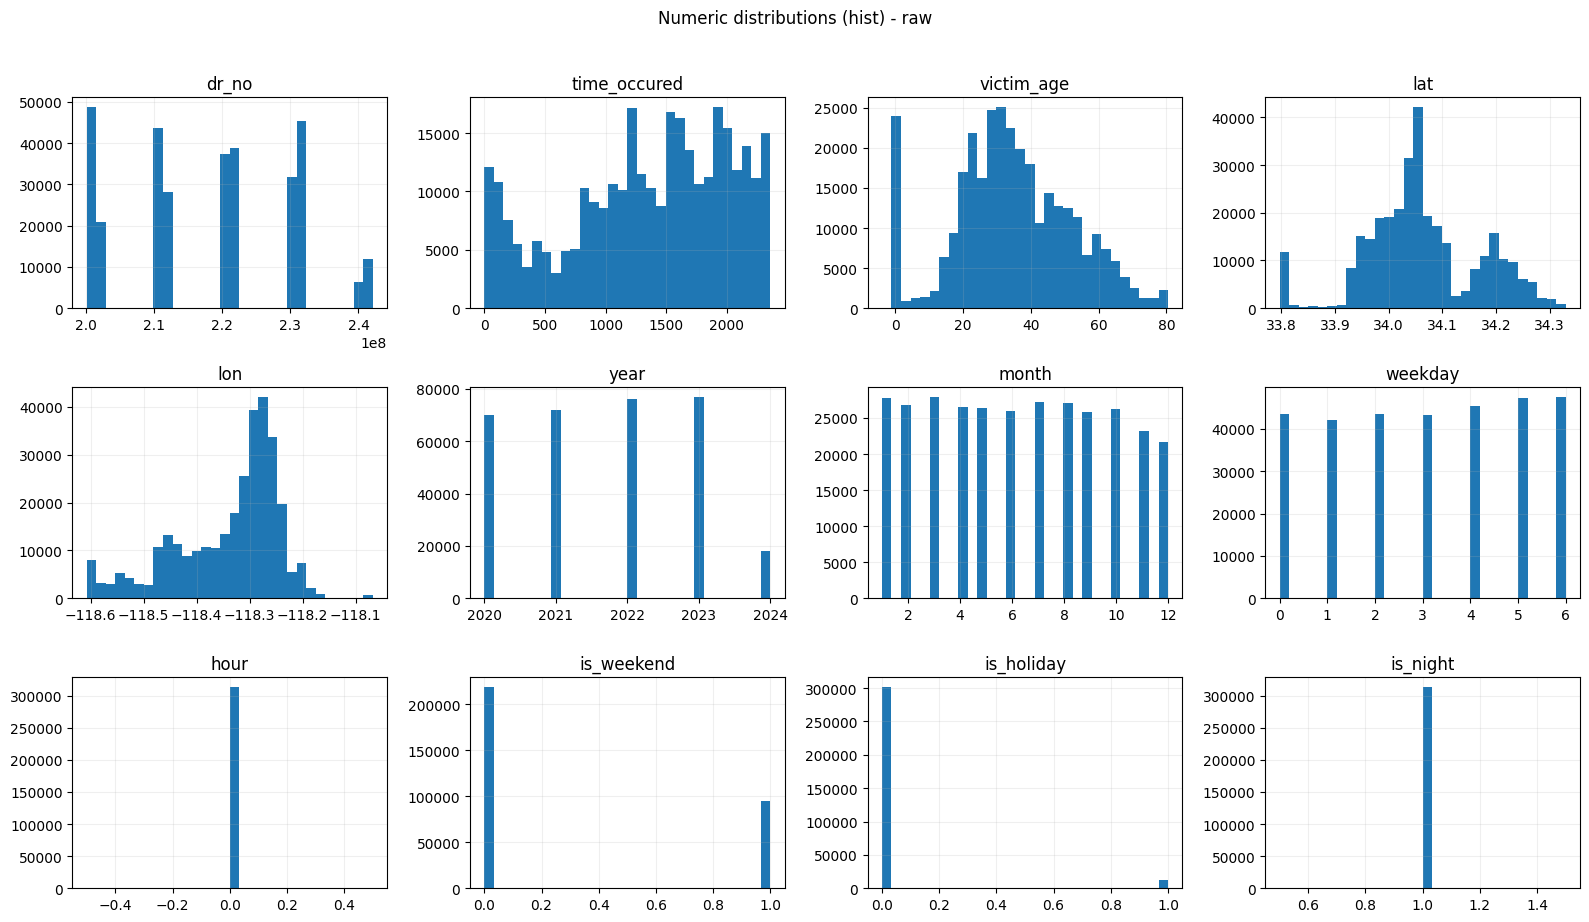

kde/box (raw) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
==== [EDA-4] Geo cleanup ====
Empty DataFrame
Columns: [issue, count]
Index: []
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
[IForest] flagged 6,252 / 312,614 rows
[LOF] flagged 6,127 / 306,362 rows
VIF table saved: /content/vif_table.csv
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
🗂️ saved: /content/figs_eda_with_target/Missingness---cleaned.png


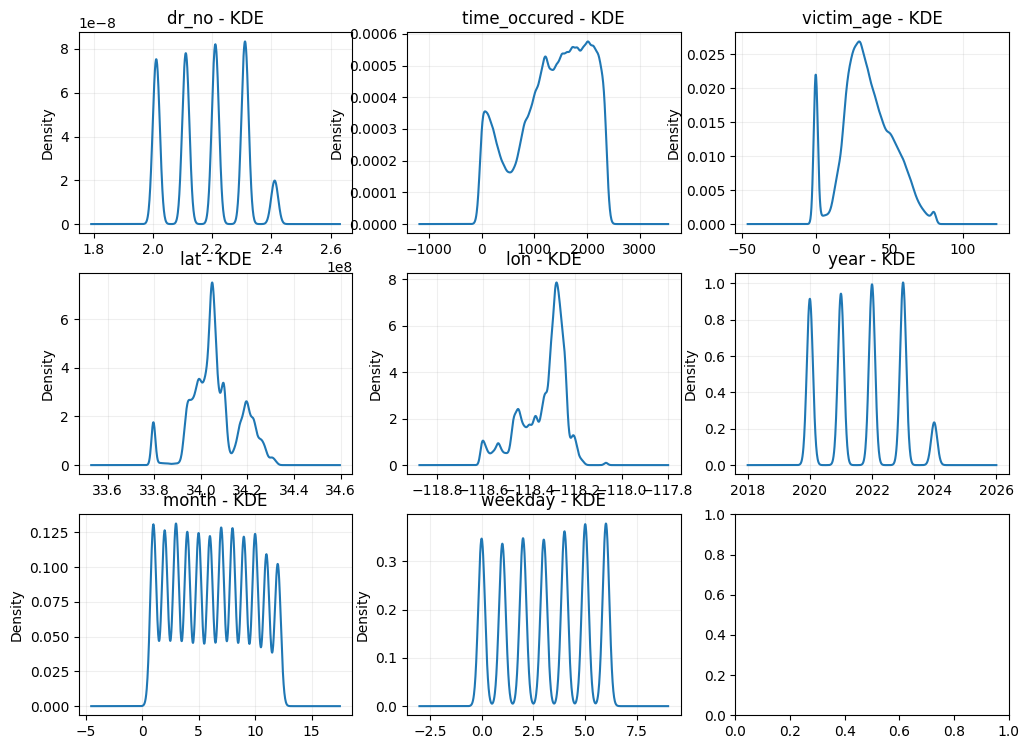

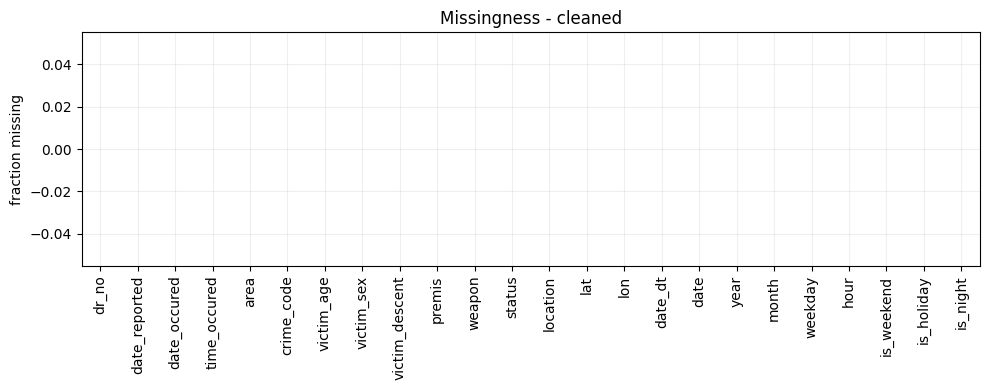

🗂️ saved: /content/figs_eda_with_target/Missingness-matrix---cleaned.png


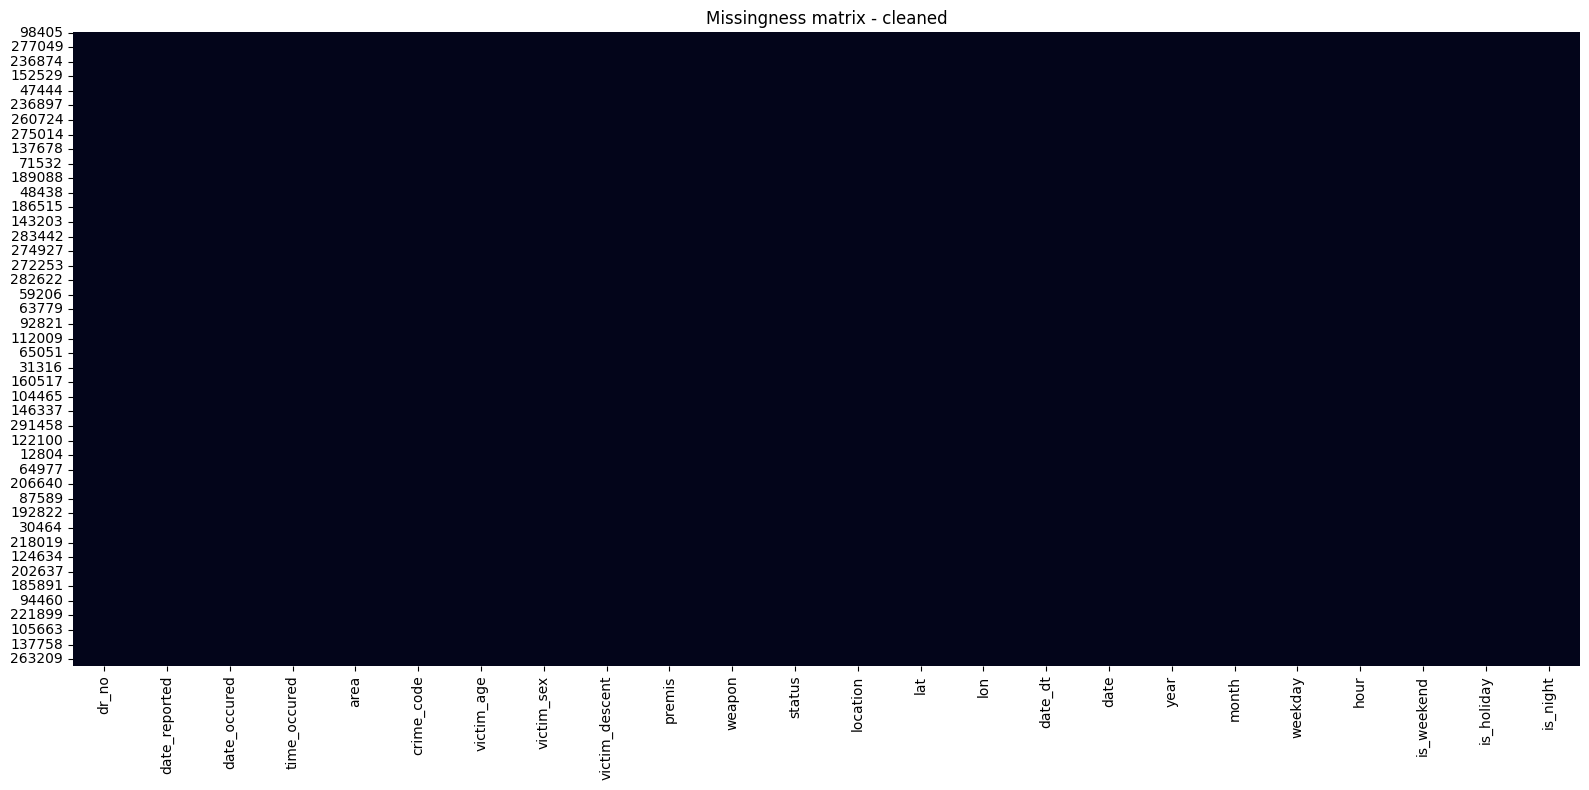

🗂️ saved: /content/figs_eda_with_target/Numeric-distributions-(hist)---cleaned.png


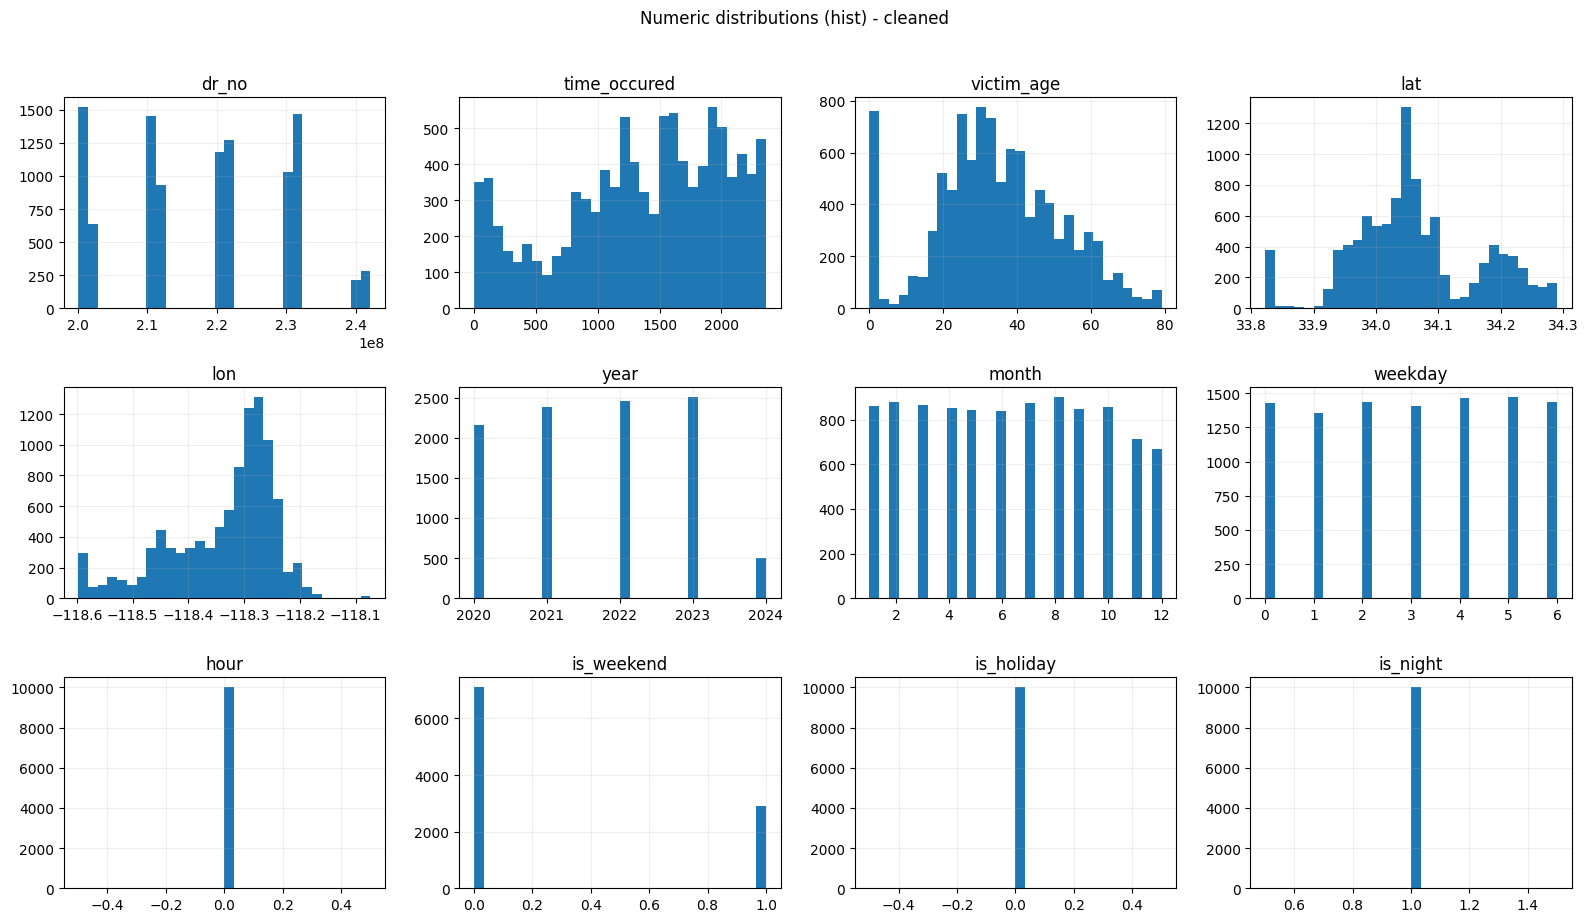

kde/box (cleaned) skipped: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Pearson)---cleaned.png


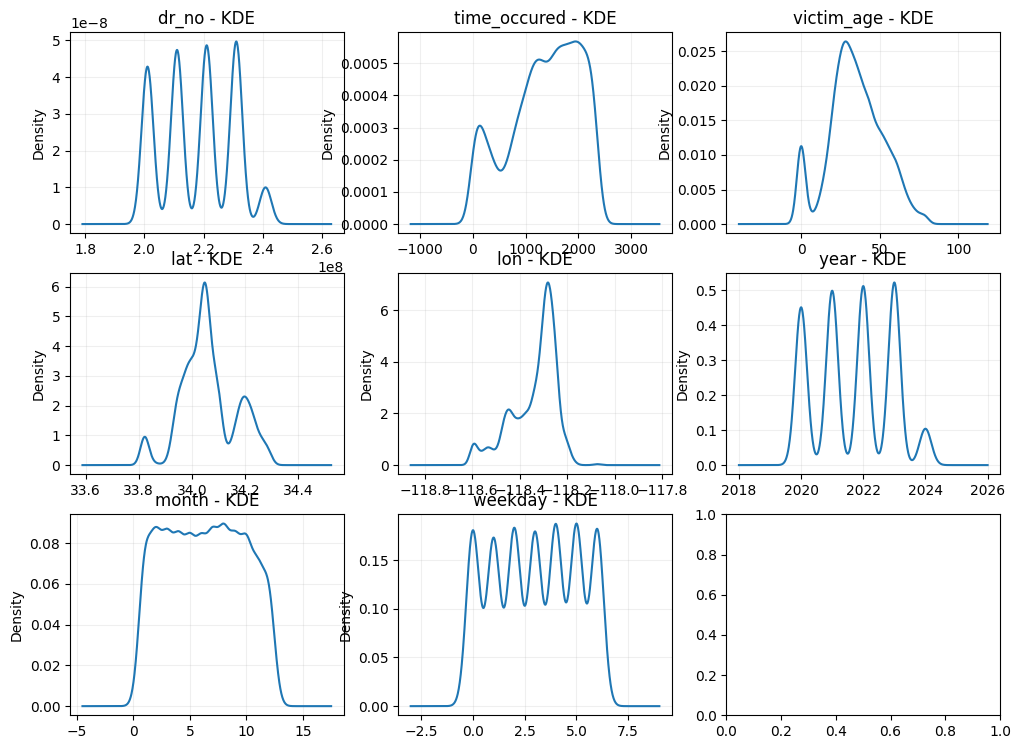

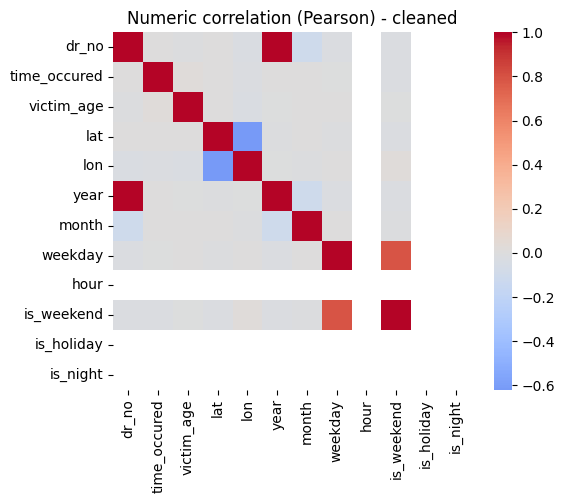

🗂️ saved: /content/figs_eda_with_target/Numeric-correlation-(Spearman)---cleaned.png


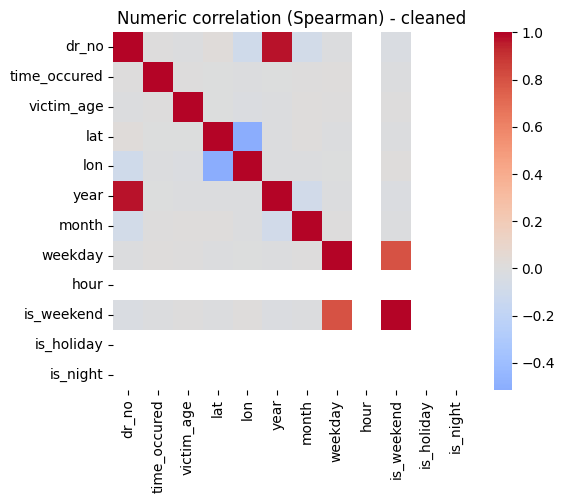

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat)---cleaned.png


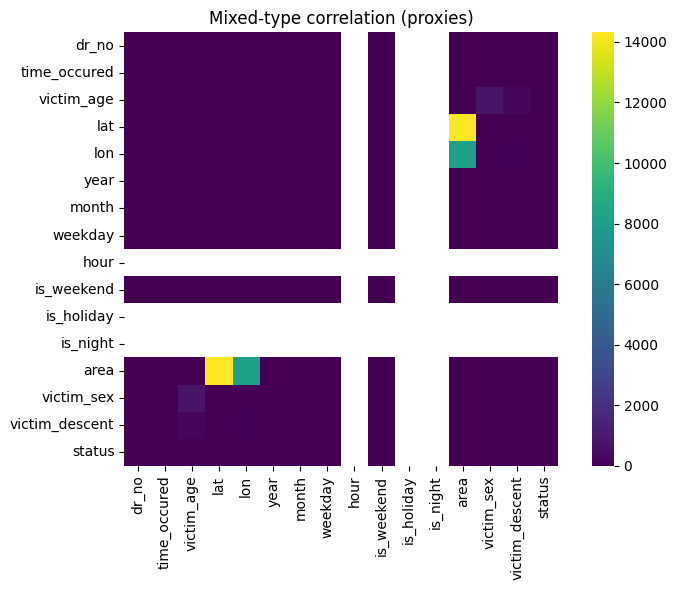

SMOTE failed; falling back to undersample: The target 'y' needs to have more than 1 class. Got 1 class instead
[Balance] target has <2 classes; skip.
🗂️ saved: /content/figs_eda_with_target/Mutual-Information-vs-is_night.png


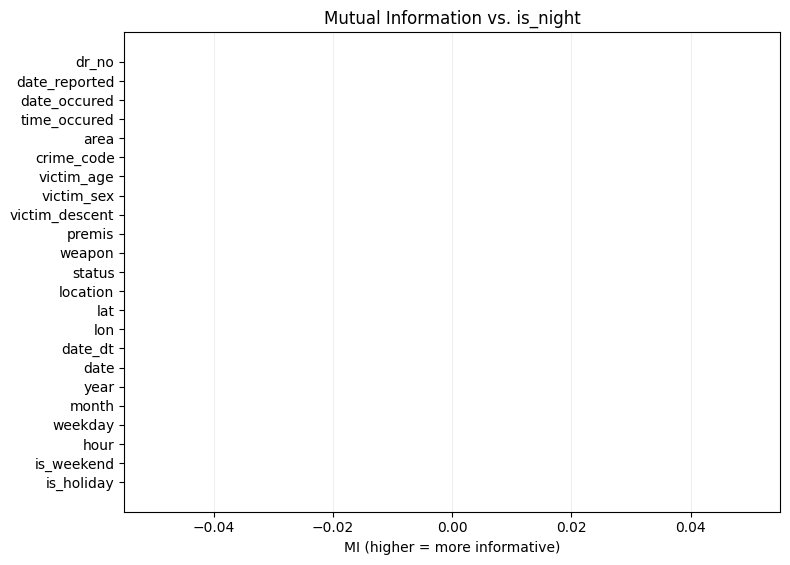

🗂️ saved: /content/figs_eda_with_target/RF-feature-importance.png


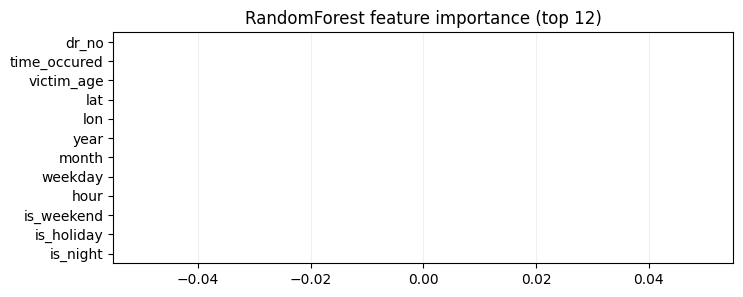

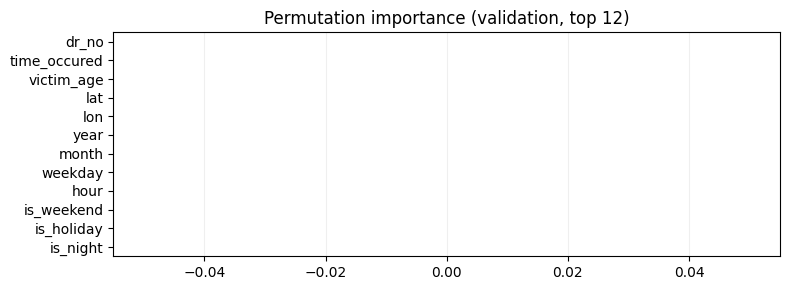

==== [EDA-9] Save cleaned parquet ====
✅ Cleaned data saved to: /content/lapd_clean_with_target.parquet

Creating stratified sample of 5000 rows...
[EDA Runner] Stratified sample using 'victim_sex': 5,000 rows.
Stratified sample saved to: /content/lapd_sample.parquet
Sample shape: (5000, 24)
Gender distribution:
victim_sex
M    2582
F    2418
Name: count, dtype: int64

Final cleaned dataset: /content/lapd_clean_with_target.parquet


In [ ]:
import pandas as pd
import numpy as np
from eda import run_eda

# Define missing constants
SAMPLE_SIZE = 5000
RANDOM_STATE = 42

# Configuration for EDA (we'll already drop-all-missing in the runner)
EDA_CFG = {
    "use_us_holidays": True,
    "add_h3": False,
    "iqr_clip": True,
    "iqr_multiplier": 1.5,
    "zscore_winsor": True,
    "zscore_max": 4.0,
    "drop_any_nan_after_features": True,
    "imbalance_target": None,  # set later when we add is_night
    "balance_preview": True,
    "balance_method": "smote",
    "balance_max_n": 20000,
    "corr_pearson": True,
    "corr_spearman": True,
    "corr_mutual_info": True,
    "feature_importance": True,
    "plot_numeric_dists": True,
    "plot_kde_box": True,
    "missing_matrix": True,
    "outliers_iforest": True,
    "outliers_lof": True,
    "outliers_ocsvm": True,
    "outliers_max_frac": 0.02,
    "plot_corr": True,
    "vif_check": True,
}

RAW_PATH = "/content/Crime_Data_from_2020_to_Present.csv.zip"
STRICT_CLEAN_PATH = "/content/_strict_full_rows.csv"  # keep as .csv

# --- STRICT FULL-ROW CLEANING IN RUNNER --------------------------------------
print("==== [RUNNER] Read CSV/ZIP & strict full-row drop ====")
df = pd.read_csv(RAW_PATH, low_memory=False, compression='infer')
print(f"[Runner] Raw shape: {df.shape}")

# Normalize common missing sentinels to NaN, then drop any row with ANY NaN
_missing_sentinels = ["", " ", "NA", "N/A", "na", "n/a", "None", "NONE",
                      "null", "NULL", "?", "-", "--"]
df = df.replace(_missing_sentinels, np.nan)

before = len(df)
df = df.dropna(axis=0, how="any").reset_index(drop=True)
after = len(df)
print(f"[Runner] Strict dropna removed {before - after:,} rows; remaining {after:,}.")
print(f"[Runner] Post-drop shape: {df.shape}")

# Persist this strictly complete dataset as CSV; run_eda expects CSV
df.to_csv(STRICT_CLEAN_PATH, index=False)

# ------------------------------------------------------------------------------

# Run the main EDA pipeline on the already-cleaned CSV
print("\nRunning comprehensive EDA pipeline on strictly-complete data...")
clean_path = run_eda(
    raw_csv_path=STRICT_CLEAN_PATH,
    fig_dir="/content/figs_eda",
    cache_path="/content/lapd_clean.parquet",
    config_overrides=EDA_CFG
)

# Load the EDA-cleaned data
print("Loading cleaned data returned by EDA...")
df_clean = pd.read_parquet(clean_path)
print(f"[EDA output] Cleaned data shape: {df_clean.shape}")

# Create the is_night target variable (assuming 'hour' column exists and is numeric)
if 'hour' in df_clean.columns:
    # If hour accidentally came through as non-numeric, coerce to numeric first
    df_clean['hour'] = pd.to_numeric(df_clean['hour'], errors='coerce')
    # If any coercion made NaNs, drop those rows to keep the 'full info only' contract
    before_hour = len(df_clean)
    df_clean = df_clean.dropna(subset=['hour']).reset_index(drop=True)
    if len(df_clean) != before_hour:
        print(f"[Runner] Dropped {before_hour - len(df_clean):,} rows with non-numeric 'hour' after EDA.")

    df_clean['is_night'] = ((df_clean['hour'] >= 20) | (df_clean['hour'] <= 6)).astype(int)
    print(f"Created is_night target:\n{df_clean['is_night'].value_counts()}")

    # Save updated dataset with target as a new CSV for the second run
    second_csv_path = "/content/lapd_clean_with_target.csv"
    df_clean.to_csv(second_csv_path, index=False)

    # Re-run EDA with target for class-specific analysis
    print("\nRe-running EDA with target variable for class-specific analysis...")
    EDA_CFG_WITH_TARGET = EDA_CFG.copy()
    EDA_CFG_WITH_TARGET["imbalance_target"] = "is_night"

    final_clean_path = run_eda(
        raw_csv_path=second_csv_path,  # pass the CSV with the target column
        fig_dir="/content/figs_eda_with_target",
        cache_path="/content/lapd_clean_with_target.parquet",
        config_overrides=EDA_CFG_WITH_TARGET
    )
else:
    print("Warning: 'hour' column not found. Cannot create is_night target.")
    final_clean_path = clean_path

# Optional: Create stratified sample if needed
if df_clean.shape[0] > SAMPLE_SIZE:
    print(f"\nCreating stratified sample of {SAMPLE_SIZE} rows...")

    def resolve_col(df_in, aliases):
        wanted = {a.strip().lower() for a in aliases}
        for c in df_in.columns:
            if c.strip().lower() in wanted:
                return c
        return None

    # Try typical victim-sex columns
    victim_sex_col = resolve_col(df_clean, ["vict_sex", "victim_sex", "vict_sex", "victimsex"])

    if victim_sex_col and victim_sex_col in df_clean.columns:
        # Clean up gender values
        df_clean[victim_sex_col] = (
            df_clean[victim_sex_col]
            .astype(str)
            .str.strip()
            .str.upper()
            .replace({"U": "UNKNOWN", "X": "UNKNOWN", "-": "UNKNOWN", "N": "UNKNOWN", "": "UNKNOWN"})
        )

        # Keep only M/F for clear stratification
        keep_vals = {"M", "F"}
        df_stratify = df_clean[df_clean[victim_sex_col].isin(keep_vals)].copy()

        if len(df_stratify) > SAMPLE_SIZE:
            from eda import _make_stratified_sample
            df_sample = _make_stratified_sample(df_stratify, victim_sex_col, SAMPLE_SIZE, RANDOM_STATE)

            sample_path = "/content/lapd_sample.parquet"
            df_sample.to_parquet(sample_path, index=False)
            print(f"Stratified sample saved to: {sample_path}")
            print(f"Sample shape: {df_sample.shape}")
            print(f"Gender distribution:\n{df_sample[victim_sex_col].value_counts()}")
        else:
            print("Dataset too small for meaningful stratified sampling")
    else:
        print("Could not find victim sex column for stratification")

print(f"\nFinal cleaned dataset: {final_clean_path}")

In [ ]:
import pandas as pd
# Use the sampled dataframe - just making sure
df = df_sample
print(df[["date_dt","date"]].head())
print("date_dt dtype:", df["date_dt"].dtype)
print("date range:", df["date_dt"].min(), "→", df["date_dt"].max())
print("null share:", df["date_dt"].isna().mean())

          date_dt       date
303993 2024-01-26 2024-01-26
63783  2020-07-17 2020-07-17
304497 2024-03-16 2024-03-16
146678 2022-07-04 2022-07-04
143712 2022-01-16 2022-01-16
date_dt dtype: datetime64[ns]
date range: 2020-01-01 00:00:00 → 2024-06-30 00:00:00
null share: 0.0


🗂️ saved: /content/figs_eda_with_target/Numeric-Distributions-—-cleaned.png


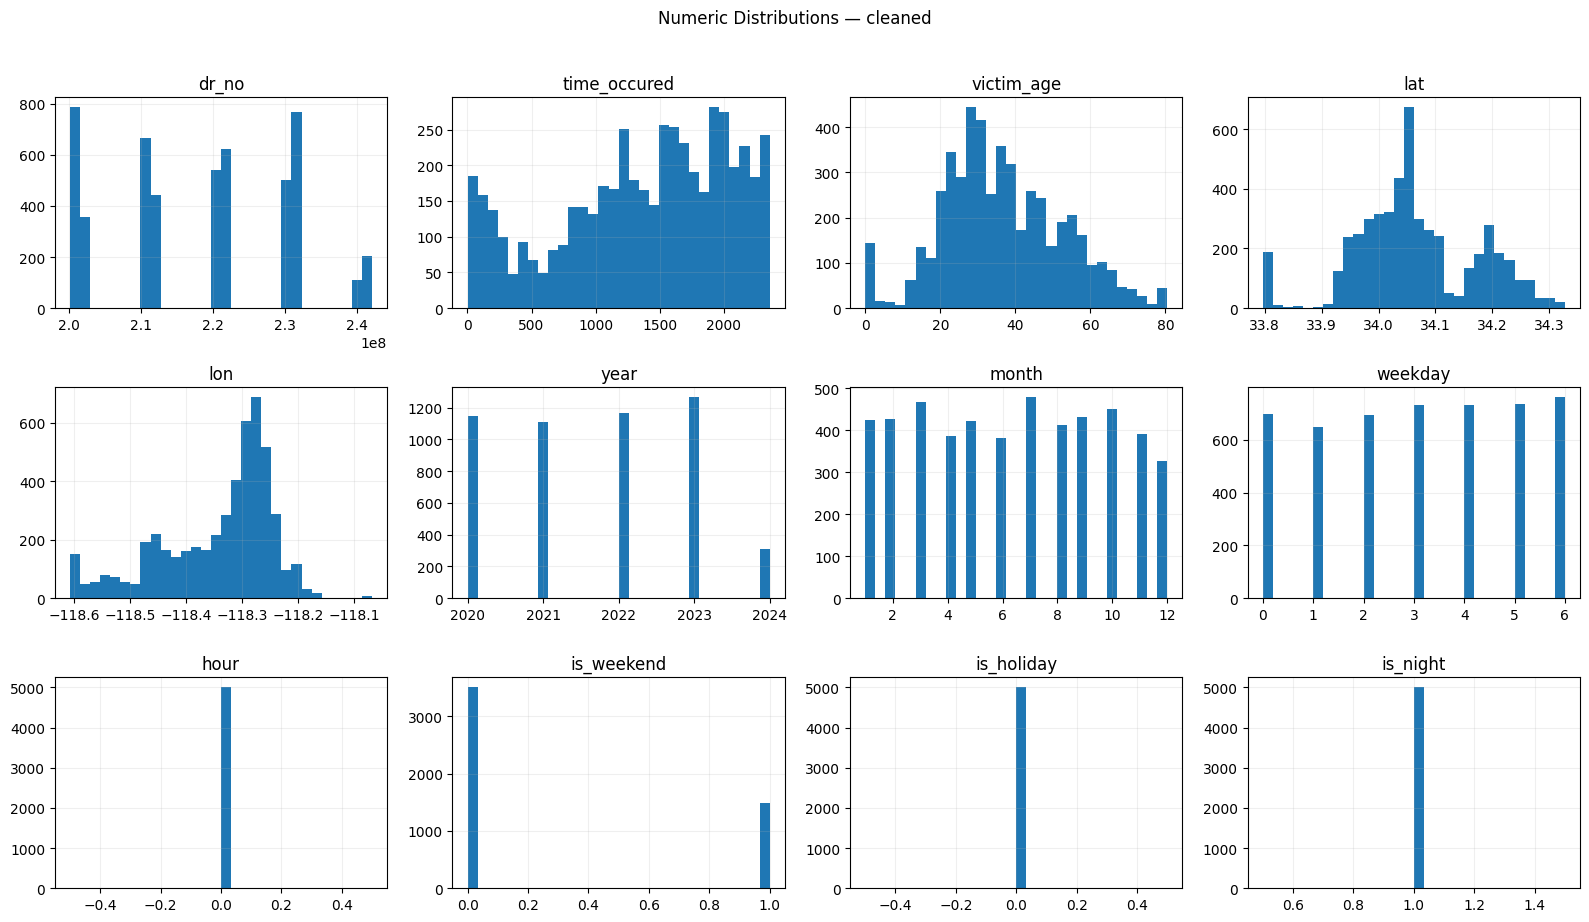

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-victim_sex.png


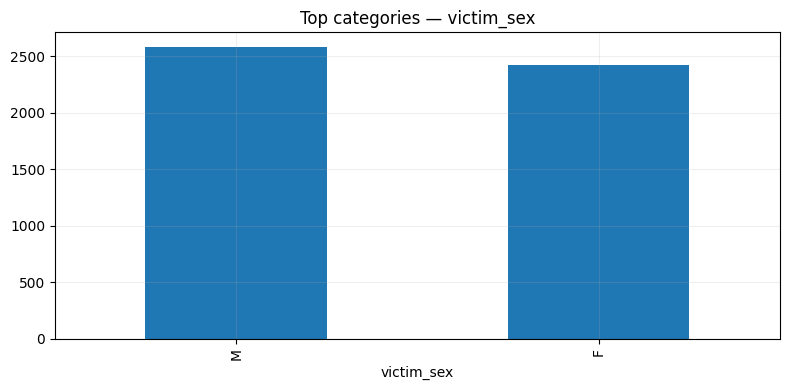

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-victim_descent.png


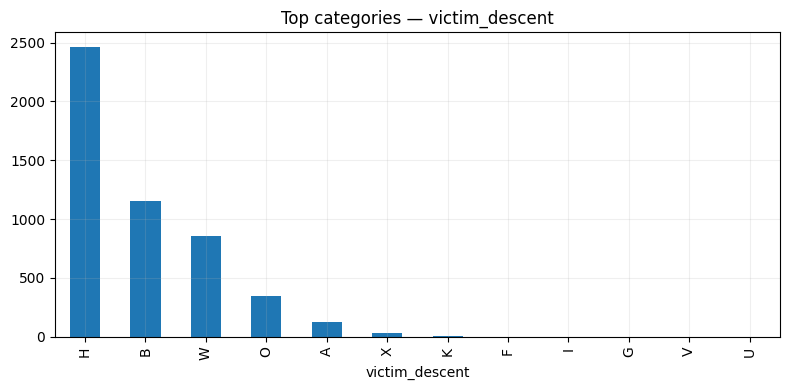

🗂️ saved: /content/figs_eda_with_target/Top-categories-—-status.png


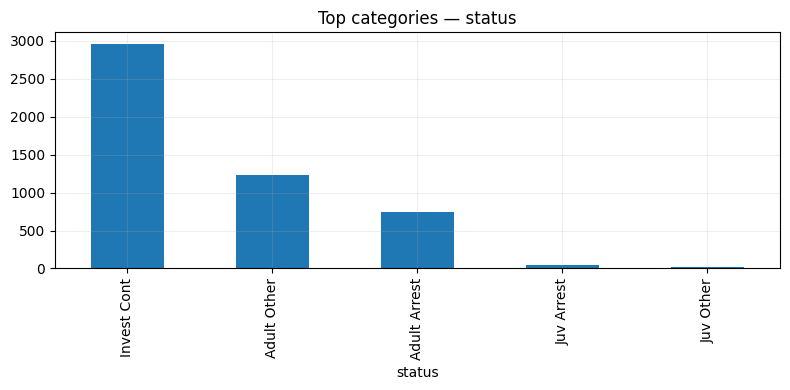

🗂️ saved: /content/figs_eda_with_target/Mixed-correlations-(num-+-cat).png


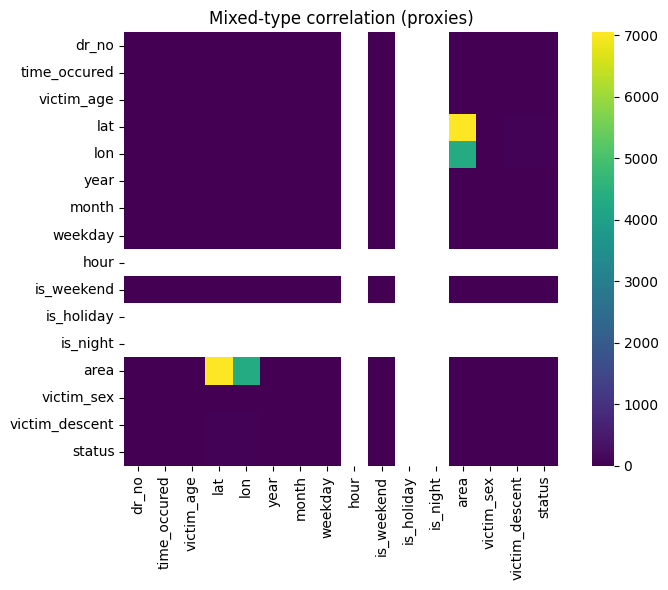

In [ ]:
# Put this after you create df_sample (and before calling run_eda if you want)
from eda import eda_top_categories, eda_numeric_histograms, eda_corr_mixed, normalize_columns, _plot_and_save
import os

# Define the figure directory
EDA_FIGS = "/content/figs_eda_with_target" # Use the directory from the successful EDA run

os.makedirs(EDA_FIGS, exist_ok=True)

# Use the sample we just built
df_plot = df_sample.copy()

# (optional but useful) normalize col names to match eda helpers’ expectations
df_plot = normalize_columns(df_plot)

# 1) Numeric distributions (all numeric cols)
_plt_title = "Numeric Distributions — cleaned"
eda_numeric_histograms(df_plot, title=_plt_title)
_plot_and_save(_plt_title, EDA_FIGS)

# 2) Categorical bars for every column with <=20 unique values (non‑numeric)
num_cols = set(df_plot.select_dtypes(include=[np.number]).columns)
cat_cols = [c for c in df_plot.columns
            if c not in num_cols and df_plot[c].nunique(dropna=False) <= 20]

for c in cat_cols:
    eda_top_categories(df_plot, c, top_n=20)
    _plot_and_save(f"Top categories — {c}", EDA_FIGS)

# 3) Mixed-type correlation heatmap (numeric ↔ categorical proxies)
eda_corr_mixed(df_plot)  # uses <=30-unique for cats internally
_plot_and_save("Mixed correlations (num + cat)", EDA_FIGS)

#Supervised

#FINAL

In [13]:
# --- Anti-leakage + pandas hotfix + training/comparison (copy-paste ready) ---

import re
import warnings
import pandas as pd
import numpy as np

# --- HOTFIX: make pandas accept 'na_last' used by supervised.py (maps to na_position) ---
try:
    _orig_sort_values = pd.DataFrame.sort_values
    def _sort_values_compat(self, *args, **kwargs):
        if "na_last" in kwargs:
            kwargs["na_position"] = "last" if kwargs.pop("na_last") else "first"
        return _orig_sort_values(self, *args, **kwargs)
    pd.DataFrame.sort_values = _sort_values_compat  # monkey-patch
except Exception as _e:
    warnings.warn(f"Could not patch pandas sort_values: {_e}")


from supervised import MLConfig, quick_train, quick_compare # Import MLConfig and the correct functions


df = pd.read_parquet("/content/lapd_sample.parquet")

# Create target column (your approach)
df = df[df["victim_sex"].isin(["F", "M"])].copy()
df["victim_sex_num"] = df["victim_sex"].map({"F": 0, "M": 1})

print(f"Dataset shape after filtering: {df.shape}")
print(f"Target distribution:\n{df['victim_sex_num'].value_counts()}")

# CRITICAL: Remove ONLY the original victim_sex column to prevent direct data leakage
print("\nRemoving victim_sex to prevent data leakage...")
df_ml = df.drop(columns=['victim_sex']).copy()
print(f"Dataset shape after removing victim_sex: {df_ml.shape}")

# Keep victim_age and victim_descent as legitimate predictive features
victim_cols_remaining = [col for col in df_ml.columns if 'victim' in col.lower()]
print(f"Remaining victim-related columns: {victim_cols_remaining}")

# Configure experiment with fewer folds
config = MLConfig(
    sample_n=5000,
    test_size=0.2,
    fig_dir="./results_clean",
    n_iter=15,
    n_splits=3,
    scoring="roc_auc",
    stratify_by="AREA NAME"  # Stratify by area instead of target
)

# Check remaining features (excluding target)
feature_cols = [col for col in df_ml.columns if col != 'victim_sex_num']
print(f"\nRemaining features ({len(feature_cols)} total):")
print(feature_cols)

# PRE-TRAINING DIAGNOSTICS (updated)
print("\n" + "="*60)
print("PRE-TRAINING DIAGNOSTICS (CLEAN DATA)")
print("="*60)

# Check correlations again (excluding target from predictors)
numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
predictor_numeric_cols = [col for col in numeric_cols if col != 'victim_sex_num']

if len(predictor_numeric_cols) > 0:
    # Create correlation matrix including target for analysis
    df_numeric = df_ml[predictor_numeric_cols + ['victim_sex_num']]
    corr_with_target = df_numeric.corr()['victim_sex_num'].abs().sort_values(ascending=False)
    # Remove target itself from the correlation series
    corr_with_target = corr_with_target.drop('victim_sex_num')

    print("Top 10 predictor features most correlated with victim_sex_num:")
    print(corr_with_target.head(10))

    # Flag suspiciously high correlations (but victim_age is expected to be high)
    suspicious_features = corr_with_target[(corr_with_target > 0.5) & (corr_with_target < 1.0)]
    if len(suspicious_features) > 0:
        print(f"\nPredictor features with correlation > 0.5:")
        print(suspicious_features)
        print("Note: victim_age correlation is expected and legitimate")
    else:
        print("\nNo predictor features with unexpectedly high correlation (>0.5)")

# TRAINING: Single model first
print("\n" + "="*60)
print("TRAINING XGB MODEL (CLEAN DATA)")
print("="*60)

# Correct the order of arguments: df, target_col, model_type, config
best_est, params, score, metrics = quick_train(
    df_ml, "victim_sex_num", "xgb", config
)

# POST-TRAINING DIAGNOSTICS
print("\n" + "="*60)
print("POST-TRAINING DIAGNOSTICS (CLEAN DATA)")
print("="*60)

try:
    # Get feature names and importances
    feature_names = best_est.named_steps['preprocessor'].get_feature_names_out()
    importances = best_est.named_steps['clf'].feature_importances_

    # Sort by importance
    feature_importance_pairs = list(zip(feature_names, importances))
    top_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

    print("Top 15 most important features:")
    for i, (feat, imp) in enumerate(top_features[:15]):
        print(f"{i+1:2d}. {feat:<30} {imp:.4f}")

    # Check if any single feature dominates (but victim_age dominance is expected)
    if top_features:
        top_importance = top_features[0][1]
        second_importance = top_features[1][1] if len(top_features) > 1 else 0
        top_feature_name = top_features[0][0]

        print(f"\nFeature importance analysis:")
        print(f"Top feature: {top_feature_name} ({top_importance:.4f})")
        print(f"Second feature importance: {second_importance:.4f}")
        print(f"Ratio (top/second): {top_importance/max(second_importance, 0.001):.2f}")

        if 'victim_age' in top_feature_name and top_importance > 0.3:
            print("✓ victim_age dominance is expected - age patterns differ by gender")
        elif top_importance > 0.5:
            print("⚠️  WARNING: Non-age feature dominates (>0.5 importance)")
        elif top_importance > 0.3:
            print("⚠️  CAUTION: Top feature has high importance (>0.3)")
        else:
            print("✓ Feature importance looks balanced")

except Exception as e:
    print(f"Could not extract feature importance: {e}")

# CV Score Analysis - higher scores expected with age/descent
print(f"\nCV Score Analysis:")
print(f"Best CV score: {score:.4f}")

if score > 0.98:
    print("⚠️  WARNING: CV score > 0.98 - may still have leakage issues")
elif score > 0.9:
    print("✓ High CV score expected - victim age/descent are strong predictors")
elif score > 0.8:
    print("✓ Good CV score - demographic features provide strong signal")
elif score > 0.7:
    print("✓ CV score looks reasonable for demographic prediction")
elif score > 0.6:
    print("✓ CV score is modest - likely realistic performance")
else:
    print("📊 CV score is low - may indicate weak signal or need more features")

# Holdout performance
if metrics:
    print(f"\nHoldout Test Performance:")
    # Filter out non-scalar values before printing
    for metric, value in metrics.items():
        if isinstance(value, (int, float, np.number)):
             print(f"{metric}: {value:.4f}")

# Compare multiple models - expect higher scores with demographic features
print(f"\nRunning model comparison with demographic features...")
print("\n" + "="*60)
print("COMPARING MULTIPLE MODELS (WITH DEMOGRAPHIC FEATURES)")
print("="*60)

# Test with multiple models
models_to_test = ["logreg", "random_forest", "hgb", "xgb"]
# Correct the order of arguments and remove the extra config argument
results = quick_compare(df_ml, "victim_sex_num", models=models_to_test, config=config)
print("\nModel Comparison Results:")
print(results.round(4))

# Analysis
if 'cv_score' in results.columns:
    best_model = results.iloc[0]
    worst_model = results.iloc[-1]
    score_range = best_model['cv_score'] - worst_model['cv_score']

    print(f"\nModel Performance Analysis:")
    print(f"Best model: {best_model['model']} ({best_model['cv_score']:.4f})")
    print(f"Worst model: {worst_model['model']} ({worst_model['cv_score']:.4f})")
    print(f"Score range: {score_range:.4f}")

    if score_range < 0.02:
        print("✓ Models perform similarly - suggests stable signal")
    elif score_range > 0.1:
        print("📊 Large performance differences - some models may be overfitting")

# FINAL ASSESSMENT
print("\n" + "="*60)
print("FINAL ASSESSMENT")
print("="*60)

print(f"Model CV score with demographic features: {score:.4f}")
print(f"This represents predictive power using victim age, descent, and crime context")

if score > 0.85:
    print("\n✓ STRONG DEMOGRAPHIC SIGNAL:")
    print("- Victim age and descent provide strong predictive power")
    print("- Combined with crime patterns, demographics enable good prediction")
    print("- This level of performance is realistic for demographic prediction")
    print("- Age patterns: crimes may affect different age groups by gender")
    print("- Descent patterns: cultural/social factors may influence crime exposure")
elif score > 0.7:
    print("\n✓ MODERATE DEMOGRAPHIC SIGNAL:")
    print("- Demographic features provide useful but not overwhelming signal")
    print("- Performance suggests learnable patterns in victim demographics")
    "- Results could be actionable for targeted prevention/resource allocation"
else:
    print("\n📊 WEAK DEMOGRAPHIC SIGNAL:")
    print("- Victim demographics may not be strongly predictable from available features")
    print("- Consider whether this target is appropriate for your use case")
    "- Might need additional contextual features"

Dataset shape after filtering: (1929, 25)
Target distribution:
victim_sex_num
1    1008
0     921
Name: count, dtype: int64

Removing victim_sex to prevent data leakage...
Dataset shape after removing victim_sex: (1929, 24)
Remaining victim-related columns: ['victim_age', 'victim_descent', 'victim_sex_num']

Remaining features (23 total):
['dr_no', 'date_reported', 'date_occured', 'time_occured', 'area', 'crime_code', 'victim_age', 'victim_descent', 'premis', 'weapon', 'status', 'location', 'lat', 'lon', 'hour', 'is_night', 'date_dt', 'date', 'year', 'month', 'weekday', 'is_weekend', 'is_holiday']

PRE-TRAINING DIAGNOSTICS (CLEAN DATA)
Top 10 predictor features most correlated with victim_sex_num:
lat             0.076035
weekday         0.031235
lon             0.021935
dr_no           0.019386
year            0.016763
month           0.013164
time_occured    0.011192
is_weekend      0.005219
victim_age      0.003392
hour                 NaN
Name: victim_sex_num, dtype: float64

No pr

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [15]:
df.columns

Index(['dr_no', 'date_reported', 'date_occured', 'time_occured', 'area',
       'crime_code', 'victim_age', 'victim_sex', 'victim_descent', 'premis',
       'weapon', 'status', 'location', 'lat', 'lon', 'hour', 'is_night',
       'victim_sex_num', 'date_dt', 'date', 'year', 'month', 'weekday',
       'is_weekend', 'is_holiday'],
      dtype='object')

In [18]:
# ==== HARD RESET pandas .sort_values + leak-safe training/compare ====

# 0) Hard reset pandas' DataFrame.sort_values to factory default
import importlib, pandas as pd
import pandas.core.frame as _pd_frame_mod
importlib.reload(_pd_frame_mod)
pd.DataFrame.sort_values = _pd_frame_mod.DataFrame.sort_values
if hasattr(pd.DataFrame, "_orig_sort_values"):
    delattr(pd.DataFrame, "_orig_sort_values")

# 1) Idempotent compatibility patch: translate 'na_last' -> 'na_position'
def patch_pandas_sort_values():
    # Only patch if not already patched by this exact function
    if getattr(pd.DataFrame.sort_values, "__name__", "") != "_sort_values_compat":
        _orig = pd.DataFrame.sort_values
        def _sort_values_compat(self, *args, **kwargs):
            # supervised.py sometimes passes na_last=...
            if "na_last" in kwargs:
                kwargs["na_position"] = "last" if kwargs.pop("na_last") else "first"
            return _orig(self, *args, **kwargs)
        pd.DataFrame.sort_values = _sort_values_compat

patch_pandas_sort_values()

# 2) Load data
import re
TARGET = "victim_sex"
GROUP_COL = "dr_no"
df = pd.read_parquet("/content/lapd_sample.parquet")

# 3) Leak-safety: one row per incident + drop target-like proxies/perfect keys
def make_leak_safe(df: pd.DataFrame, target: str, group_col: str) -> pd.DataFrame:
    df = df.copy()

    # One row per incident (prevents same case in train & test)
    if group_col in df.columns:
        time_cols = [c for c in df.columns if re.search(r"(date|time)", c, re.I)]
        if time_cols:
            df = df.sort_values(time_cols).drop_duplicates(subset=[group_col], keep="first")
        else:
            df = df.drop_duplicates(subset=[group_col], keep="first")

    # Drop columns that clearly encode the target
    proxy_name_cols = [c for c in df.columns if c != target and re.search(re.escape(target), c, re.I)]
    alias_cols = [c for c in df.columns
                  if c != target and (c.lower() in {"sex", "gender"} or re.search(r"\b(sex|gender)\b", c, re.I))]
    df = df.drop(columns=sorted(set(proxy_name_cols + alias_cols)), errors="ignore")

    # Drop features that perfectly determine target (bijective mapping)
    max_card = 1000
    candidates = [c for c in df.columns if c != target and df[c].nunique(dropna=False) <= max_card]
    leaky_by_value = []
    for c in candidates:
        try:
            if df.groupby(c)[target].nunique(dropna=False).max() == 1:
                leaky_by_value.append(c)
        except Exception:
            pass
    df = df.drop(columns=leaky_by_value, errors="ignore")

    # Drop exact duplicates of the target
    dup_target_cols = [c for c in df.columns if c != target and df[c].equals(df[target])]
    df = df.drop(columns=dup_target_cols, errors="ignore")

    return df

df_clean = make_leak_safe(df, TARGET, GROUP_COL)
print("Shapes (raw → clean):", df.shape, "→", df_clean.shape)

# 4) Train & compare with your helpers (plots off to dodge seaborn labels quirk)
from supervised import quick_train, quick_compare, MLConfig

config = MLConfig(
    sample_n=1000,
    test_size=0.2,
    fig_dir="./results",
    plot_curves=False,  # set True later if you like; this avoids the "NoneType has no len()" warn
    random_state=42
)

print("\n=== TRAIN XGB (leak-safe) ===")
model, params, score, metrics = quick_train(df_clean, TARGET, "xgb", config)

print("\n=== COMPARE MODELS (leak-safe) ===")
results = quick_compare(
    df_clean,
    TARGET,
    models=["logreg", "rf", "xgb"],
    config=config
)
print(results)

print("\n✅ Done.")


Shapes (raw → clean): (1929, 25) → (1929, 24)

=== TRAIN XGB (leak-safe) ===

                 TRAINING XGB ON VICTIM_SEX                 
📊 Using target-stratified sample: 999 rows (from 1,929)
🎯 Target encoded: {'F': 0, 'M': 1}
📊 Dataset shape: (999, 23)
🎯 Classes: 2, Binary: True
📈 Target distribution:
0    477
1    522
Name: count, dtype: int64
⚠️ Removing constant numeric column: hour
⚠️ Removing constant numeric column: is_night
⚠️ Removing constant numeric column: is_holiday
📊 Numeric columns (9): ['dr_no', 'time_occured', 'victim_age', 'lat', 'lon']...
🏷️ Categorical columns (11): ['date_reported', 'date_occured', 'area', 'crime_code', 'victim_descent']...
⚖️ XGB scale_pos_weight set to 0.914
🔍 Running random search with 5-fold CV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Best CV score (roc_auc): 0.7226
⏱️ Training time: 510.27s
🔧 Best parameters:
   clf__subsample: 1.0
   clf__n_estimators: 200
   clf__min_child_weight: 3
   clf__max_depth: 3
   clf__l

#Unsupervised

#old

In [ ]:
# === Comprehensive Unsupervised Analysis (Dims 2–8 for PCA/UMAP/t‑SNE) ===
# Input  : /content/lapd_clean_5k.parquet  (CSV fallback supported)
# Output : /content/figs_comprehensive_unsup  (CSVs + best-plot if 2D)
# Author : streamlined per user request

import os, sys, warnings, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================================ #
# CONFIG
# ============================================================================ #
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_comprehensive_unsup"
RANDOM_STATE = 42
SILHOUETTE_THRESHOLD = 0.6

# Feature engineering
MAX_CAT_CARD   = 30
SVD_COMPONENTS = 50

# Embedding params
PCA_DIMS  = list(range(2, 9))        # 2..8
UMAP_DIMS = list(range(2, 9))        # 2..8
TSNE_DIMS = list(range(2, 9))        # 2..8

# A compact UMAP grid (kept small to avoid explosion)
UMAP_CONFIGS = [
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.1},
]

# t‑SNE perplexities (validated per dataset size at run time)
TSNE_PERPLEXITY = [15, 30]

# "Other" methods — single, reasonable 2D configs to keep runtime sane
KPCA_CONFIG     = {"kernel": "rbf", "gamma": 0.1}
LLE_CONFIG      = {"n_neighbors": 20, "method": "standard"}
ISOMAP_NEIGHBORS= 20
MDS_METRIC      = True
FA_NCOMP        = 2
ICA_NCOMP       = 2

# Clustering parameters
KMEANS_K_RANGE = range(2, 12)
DBSCAN_CONFIGS = [
    {"eps": 0.3, "min_samples": 10},
    {"eps": 0.5, "min_samples": 10},
    {"eps": 0.7, "min_samples": 10},
]
HDBSCAN_CONFIGS = [{"min_cluster_size": 10}, {"min_cluster_size": 20}]

os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================================ #
# UTILS
# ============================================================================ #
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

def _scores(X, y):
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    uniq = set(y)
    if len(uniq) <= 1 or (uniq == {-1}):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan,
                "n_clusters": 1, "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}
    try: sil = silhouette_score(X, y)
    except: sil = np.nan
    try: ch = calinski_harabasz_score(X, y)
    except: ch = np.nan
    try: db = davies_bouldin_score(X, y)
    except: db = np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db,
            "n_clusters": len([u for u in uniq if u != -1]),
            "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}

def _make_ohe():
    from sklearn.preprocessing import OneHotEncoder
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def timer(fn):
    def wrap(*a, **k):
        t0 = time.time()
        out = fn(*a, **k)
        print(f"[TIME] {fn.__name__}: {time.time()-t0:.2f}s")
        return out
    return wrap

# ============================================================================ #
# LOAD + PREPROCESS
# ============================================================================ #
print("="*58)
print("CREATING EMBEDDINGS")
print("="*58)

df = _load_df(CLEAN_PATH)

# Drop constants
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if const_cols:
    print(f"[CLEAN] Dropping constant columns: {const_cols}")
    df = df.drop(columns=const_cols)

# Feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# Avoid leakage-like columns (edit as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc",
    "Crime Code","Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool→int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[PREPROCESS] Matrix: {X_sparse.shape} (sparse={hasattr(X_sparse,'tocsr')})")

embeddings = {}
results    = []

# ============================================================================ #
# BASELINE SVD (for stability + as UMAP/tSNE input)
# ============================================================================ #
@timer
def create_svd():
    from sklearn.decomposition import TruncatedSVD
    comp50 = min(SVD_COMPONENTS, X_sparse.shape[1]-1) if X_sparse.shape[1] > 1 else 1
    svd50  = TruncatedSVD(n_components=comp50, random_state=RANDOM_STATE)
    X50    = svd50.fit_transform(X_sparse)
    embeddings["SVD50"] = X50
    svd2   = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
    X2     = svd2.fit_transform(X_sparse)
    embeddings["SVD2"]  = X2
    print(f"[SVD] SVD50: {X50.shape} (expl.var≈{svd50.explained_variance_ratio_.sum():.3f})")
    print(f"[SVD] SVD2  : {X2.shape}  (expl.var≈{svd2.explained_variance_ratio_.sum():.3f})")

create_svd()

# ============================================================================ #
# PCA (dims 2..8)
# ============================================================================ #
@timer
def create_pca():
    from sklearn.decomposition import PCA, IncrementalPCA
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse
    for d in PCA_DIMS:
        if d >= min(X_dense.shape):
            continue
        if getattr(X_dense, "nbytes", 0) > 1_200_000_000:
            pca = IncrementalPCA(n_components=d, batch_size=1000)
        else:
            pca = PCA(n_components=d, random_state=RANDOM_STATE)
        Xp = pca.fit_transform(X_dense)
        embeddings[f"PCA{d}"] = Xp
        ev = getattr(pca, "explained_variance_ratio_", None)
        msg = f" (expl.var≈{ev.sum():.3f})" if ev is not None else ""
        print(f"[PCA] PCA{d}: {Xp.shape}{msg}")

create_pca()

# ============================================================================ #
# UMAP (dims 2..8), using SVD50 input for efficiency
# ============================================================================ #
@timer
def create_umap():
    try:
        import umap
    except ImportError:
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
        import umap
    Xin = embeddings["SVD50"]
    for d in UMAP_DIMS:
        for cfg in UMAP_CONFIGS:
            key = f"UMAP{d}_n{cfg['n_neighbors']}_d{cfg['min_dist']}"
            try:
                um = umap.UMAP(n_components=d, metric="euclidean",
                               random_state=RANDOM_STATE, verbose=False, **cfg)
                Xu = um.fit_transform(Xin)
                embeddings[key] = Xu
                print(f"[UMAP] {key}: {Xu.shape}")
            except Exception as e:
                print(f"[UMAP][FAIL] {key}: {e}")

create_umap()

# ============================================================================ #
# t-SNE (dims 2..8), switch to method="exact" for d >= 4 (fixes BH limitation)
# ============================================================================ #
@timer
def create_tsne():
    from sklearn.manifold import TSNE
    Xin = embeddings["SVD50"]
    n = Xin.shape[0]
    max_perp = min(50, (n - 1) / 3.0)
    perps = [p for p in TSNE_PERPLEXITY if p <= max_perp]
    if not perps:
        perps = [min(30, max(5, int(max_perp)))]
    for d in TSNE_DIMS:
        method = "barnes_hut" if d <= 3 else "exact"
        for p in perps:
            key = f"tSNE{d}_p{p}_m{method[:1]}"
            try:
                ts = TSNE(n_components=d, perplexity=p, learning_rate="auto",
                          init="random", random_state=RANDOM_STATE,
                          n_iter=1000, method=method, verbose=0)
                Xt = ts.fit_transform(Xin)
                embeddings[key] = Xt
                print(f"[tSNE] {key}: {Xt.shape}")
            except Exception as e:
                print(f"[tSNE][FAIL] {key}: {e}")

create_tsne()

# ============================================================================ #
# “Other” methods — single 2D configs (compact)
# ============================================================================ #
@timer
def create_other_methods():
    # Kernel PCA (2D on a sample if large)
    from sklearn.decomposition import KernelPCA, FactorAnalysis, FastICA, TruncatedSVD
    from sklearn.manifold import LocallyLinearEmbedding, Isomap, MDS

    # Dense view when needed
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse

    # Sampling for heavy methods
    sample_size = min(2000, X_sparse.shape[0])
    sample_idx  = None
    if sample_size < X_sparse.shape[0]:
        rng = np.random.RandomState(RANDOM_STATE)
        sample_idx = rng.choice(X_sparse.shape[0], sample_size, replace=False)
        X_sample = X_dense[sample_idx] if hasattr(X_dense, "__getitem__") else X_dense
        print(f"[SAMPLE] Using sample of {sample_size} for heavy methods")
    else:
        X_sample = X_dense

    # KPCA (2D)
    try:
        kp = KernelPCA(n_components=2, random_state=RANDOM_STATE, **KPCA_CONFIG)
        Xk = kp.fit_transform(X_sample)
        embeddings["KPCA2"] = Xk
        if sample_idx is not None: embeddings["KPCA2_sample_idx"] = sample_idx
        print(f"[KPCA] KPCA2: {Xk.shape}")
    except Exception as e:
        print(f"[KPCA][FAIL] {e}")

    # LLE (2D)
    try:
        lle = LocallyLinearEmbedding(n_components=2, random_state=RANDOM_STATE, **LLE_CONFIG)
        Xl = lle.fit_transform(X_sample)
        embeddings["LLE2"] = Xl
        if sample_idx is not None: embeddings["LLE2_sample_idx"] = sample_idx
        print(f"[LLE] LLE2: {Xl.shape}")
    except Exception as e:
        print(f"[LLE][FAIL] {e}")

    # Isomap (2D)
    try:
        iso = Isomap(n_components=2, n_neighbors=ISOMAP_NEIGHBORS, n_jobs=-1)
        Xi = iso.fit_transform(X_sample)
        embeddings["Isomap2"] = Xi
        if sample_idx is not None: embeddings["Isomap2_sample_idx"] = sample_idx
        print(f"[Isomap] Isomap2: {Xi.shape}")
    except Exception as e:
        print(f"[Isomap][FAIL] {e}")

    # MDS (2D)
    try:
        mds = MDS(n_components=2, random_state=RANDOM_STATE, n_jobs=-1, metric=MDS_METRIC)
        Xm = mds.fit_transform(X_sample)
        embeddings["MDS2"] = Xm
        if sample_idx is not None: embeddings["MDS2_sample_idx"] = sample_idx
        print(f"[MDS] MDS2: {Xm.shape}")
    except Exception as e:
        print(f"[MDS][FAIL] {e}")

    # Factor Analysis (2D)
    try:
        fa = FactorAnalysis(n_components=FA_NCOMP, random_state=RANDOM_STATE)
        Xfa = fa.fit_transform(X_dense)
        embeddings["FA2"] = Xfa
        print(f"[FA] FA2: {Xfa.shape}")
    except Exception as e:
        print(f"[FA][FAIL] {e}")

    # ICA (2D)
    try:
        ica = FastICA(n_components=ICA_NCOMP, random_state=RANDOM_STATE, max_iter=1000)
        Xica = ica.fit_transform(X_dense)
        embeddings["ICA2"] = Xica
        print(f"[ICA] ICA2: {Xica.shape}")
    except Exception as e:
        print(f"[ICA][FAIL] {e}")

create_other_methods()

# ============================================================================ #
# CLUSTERING
# ============================================================================ #
print("\n" + "="*58)
print("RUNNING CLUSTERING")
print("="*58)

@timer
def run_clustering():
    from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
    total = 0
    processed = 0

    emb_for_clust = {k: v for k,v in embeddings.items() if not k.endswith("_sample_idx")}
    for emb_name in emb_for_clust:
        total += len(KMEANS_K_RANGE) + len(DBSCAN_CONFIGS) + len(HDBSCAN_CONFIGS)
        # only run Spectral for 2D + small n
        X = emb_for_clust[emb_name]
        is_2d = (X.shape[1] == 2)
        if is_2d and X.shape[0] <= 3000: total += 3
        # agglomerative only for higher-dim (skip — most here are low-dim by design)
    print(f"[INFO] Testing ~{total} combinations...")

    for emb_name, X in emb_for_clust.items():
        print(f"\n[CLUSTER] {emb_name} → {X.shape}")
        is_sampled = (emb_name + "_sample_idx") in embeddings
        sample_idx  = embeddings.get(emb_name + "_sample_idx", None)

        # KMeans
        for k in KMEANS_K_RANGE:
            try:
                km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
                y = km.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "KMeans",
                                "config": f"k={k}", "embedding_dim": X.shape[1],
                                "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[KMeans][FAIL] k={k}: {e}")

        # DBSCAN
        for cfg in DBSCAN_CONFIGS:
            try:
                db = DBSCAN(**cfg, n_jobs=-1)
                y = db.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "DBSCAN",
                                "config": f"eps={cfg['eps']}_min={cfg['min_samples']}",
                                "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[DBSCAN][FAIL] {cfg}: {e}")

        # HDBSCAN (if available)
        try:
            import hdbscan
            for cfg in HDBSCAN_CONFIGS:
                try:
                    hb = hdbscan.HDBSCAN(min_cluster_size=cfg["min_cluster_size"])
                    y = hb.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "HDBSCAN",
                                    "config": f"min_size={cfg['min_cluster_size']}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[HDBSCAN][FAIL] {cfg}: {e}")
        except ImportError:
            if emb_name == list(emb_for_clust.keys())[0]:
                print("[WARN] hdbscan not installed; skipping.")

        # Spectral on 2D + small n
        if X.shape[1] == 2 and X.shape[0] <= 3000:
            for k in [3,5,7]:
                try:
                    sp = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1)
                    y = sp.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "Spectral",
                                    "config": f"k={k}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[Spectral][FAIL] k={k}: {e}")

    print(f"[DONE] Processed {processed} combos")

run_clustering()

# ============================================================================ #
# RESULTS
# ============================================================================ #
print("\n" + "="*58)
print("ANALYZING RESULTS")
print("="*58)

results_df = pd.DataFrame(results)
results_df["combination"] = results_df["embedding"] + " + " + results_df["algorithm"] + " (" + results_df["config"] + ")"

high_perf = results_df[(results_df["silhouette"].notna()) &
                       (results_df["silhouette"] >= SILHOUETTE_THRESHOLD)].copy()
high_perf = high_perf.sort_values("silhouette", ascending=False)

# Save
results_df.to_csv(os.path.join(OUT_DIR, "all_combinations_results.csv"), index=False)
high_perf.to_csv(os.path.join(OUT_DIR, "high_performance_combinations.csv"), index=False)

print(f"[SUMMARY] Total combos: {len(results_df)}")
print(f"[SUMMARY] High-perf (sil ≥ {SILHOUETTE_THRESHOLD}): {len(high_perf)}")

if len(high_perf) > 0:
    cols = ["combination","silhouette","calinski_harabasz","davies_bouldin","n_clusters","n_noise","embedding_dim"]
    print("\n" + "="*80)
    print("HIGH-PERFORMING (sil ≥ 0.6)")
    print("="*80)
    print(high_perf[cols].to_string(index=False,
                                    float_format=lambda x: f"{x:.4f}" if pd.notna(x) else "NaN",
                                    max_colwidth=50))

    # Plot best if 2D
    best = high_perf.iloc[0]
    best_emb   = best["embedding"]
    best_algo  = best["algorithm"]
    best_cfg   = best["config"]
    X_best     = embeddings[best_emb]

    # Refit best clusterer
    from sklearn.cluster import KMeans, DBSCAN
    labels = None
    if best_algo == "KMeans":
        k = int(best_cfg.split("=")[1])
        labels = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE).fit_predict(X_best)
    elif best_algo == "DBSCAN":
        parts = best_cfg.split("_")
        eps = float(parts[0].split("=")[1]); min_s = int(parts[1].split("=")[1])
        labels = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1).fit_predict(X_best)
    elif best_algo == "HDBSCAN":
        import hdbscan
        min_size = int(best_cfg.split("=")[1])
        labels = hdbscan.HDBSCAN(min_cluster_size=min_size).fit_predict(X_best)
    elif best_algo == "Spectral" and X_best.shape[1] == 2 and X_best.shape[0] <= 3000:
        from sklearn.cluster import SpectralClustering
        k = int(best_cfg.split("=")[1])
        labels = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1).fit_predict(X_best)

    if labels is not None and X_best.shape[1] == 2:
        plt.figure(figsize=(10,8))
        uniq = sorted(set(labels))
        colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u != -1]))))
        cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u != -1])}
        cmap[-1] = (0.7,0.7,0.7,0.5)
        for u in uniq:
            m = (labels == u)
            name = "Noise" if u == -1 else f"Cluster {u}"
            plt.scatter(X_best[m,0], X_best[m,1], c=[cmap[u]], s=15, alpha=0.75, label=name)
        plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.title(f"Best: {best['combination']}\nSil={best['silhouette']:.4f}, Clusters={best['n_clusters']}")
        plt.xlabel(f"{best_emb} − comp 1"); plt.ylabel(f"{best_emb} − comp 2")
        plt.tight_layout()
        outp = os.path.join(OUT_DIR, "best_combination_visualization.png")
        plt.savefig(outp, dpi=300, bbox_inches="tight"); plt.close()
        print(f"[PLOT] Saved → {outp}")
else:
    print("\n[WARNING] No combos reached the silhouette threshold.")
    top10 = results_df.dropna(subset=["silhouette"]).nlargest(10, "silhouette")
    print(top10[["combination","silhouette","n_clusters"]].to_string(index=False))

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"Results saved to: {OUT_DIR}")


CREATING EMBEDDINGS
[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
[PREPROCESS] Matrix: (1651, 38) (sparse=True)
[SVD] SVD50: (1651, 37) (expl.var≈1.000)
[SVD] SVD2  : (1651, 2)  (expl.var≈0.376)
[TIME] create_svd: 0.05s
[PCA] PCA2: (1651, 2) (expl.var≈0.433)
[PCA] PCA3: (1651, 3) (expl.var≈0.593)
[PCA] PCA4: (1651, 4) (expl.var≈0.666)
[PCA] PCA5: (1651, 5) (expl.var≈0.725)
[PCA] PCA6: (1651, 6) (expl.var≈0.772)
[PCA] PCA7: (1651, 7) (expl.var≈0.802)
[PCA] PCA8: (1651, 8) (expl.var≈0.830)
[TIME] create_pca: 0.12s
[UMAP] UMAP2_n15_d0.1: (1651, 2)
[UMAP] UMAP2_n30_d0.1: (1651, 2)
[UMAP] UMAP3_n15_d0.1: (1651, 3)
[UMAP] UMAP3_n30_d0.1: (1651, 3)
[UMAP] UMAP4_n15_d0.1: (1651, 4)
[UMAP] UMAP4_n30_d0.1: (1651, 4)
[UMAP] UMAP5_n15_d0.1: (1651, 5)
[UMAP] UMAP5_n30_d0.1: (1651, 5)
[UMAP] UMAP6_n15_d0.1: (1651, 6)
[UMAP] UMAP6_n30_d0.1: (1651, 6)
[UMAP] UMAP7_n15_d0.1: (1651, 7)


In [ ]:
# === Cluster Interpretation for Top-10 UMAP+KMeans combos =====================
# Input : /content/lapd_clean_5k.parquet (CSV fallback supported)
# Output: /content/cluster_interpretation/<combo_slug>/* (CSVs + plots)
# ------------------------------------------------------------------------------

import os, re, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD

# ---------------- CONFIG ----------------
CLEAN_PATH = "/content/lapd_clean_5k.parquet"
OUT_BASE   = "/content/cluster_interpretation"
RANDOM_STATE = 42
MAX_CAT_CARD = 30  # for feature matrix (same as before)

# Your top-10 (copy/pasted from your printout)
TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

os.makedirs(OUT_BASE, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)

# Drop constant columns (same cleanup you used while embedding)
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if const_cols:
    print(f"[CLEAN] Dropping constant columns: {const_cols}")
    df = df.drop(columns=const_cols)

# ---------------- Feature Matrix for Embedding (same recipe) ------------------
# We keep interpretation (MI/profiles) on the full df, but the embedding uses a lean matrix.
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[FEATURES] Matrix for embedding: {X_sparse.shape} (sparse={hasattr(X_sparse,'tocsr')})")

# SVD50 as UMAP input (same as your experiment)
svd_comp = min(50, max(2, X_sparse.shape[1]-1))
svd = TruncatedSVD(n_components=svd_comp, random_state=RANDOM_STATE)
X_svd50 = svd.fit_transform(X_sparse)
print(f"[SVD] SVD50 (actual={X_svd50.shape[1]}): {X_svd50.shape}, expl.var≈{svd.explained_variance_ratio_.sum():.3f}")

# ---------------- UMAP builder (parse "UMAP{d}_n{nn}_d{min_dist}") ----------
def build_umap(umap_tag: str, Xin: np.ndarray) -> np.ndarray:
    # umap_tag like: "UMAP5_n15_d0.1"
    m = re.match(r"UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+)", umap_tag)
    if not m:
        raise ValueError(f"Cannot parse UMAP tag: {umap_tag}")
    n_components = int(m.group(1))
    n_neighbors  = int(m.group(2))
    min_dist     = float(m.group(3))

    try:
        import umap
    except ImportError:
        import sys, subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
        import umap

    um = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=RANDOM_STATE,
        verbose=False,
    )
    X_emb = um.fit_transform(Xin)
    return X_emb

# ---------------- Interpretation helpers -------------------------------------
def _discretize_numeric(s: pd.Series, bins=10):
    # robust qcut with fallbacks
    try:
        return pd.qcut(s.rank(method="first"), q=bins, labels=False, duplicates="drop")
    except Exception:
        # fallback: cut on finite values
        v = pd.to_numeric(s, errors="coerce")
        try:
            return pd.qcut(v.dropna().rank(method="first"), q=min(bins, max(2, v.dropna().nunique() - 1))),
        except Exception:
            return pd.Series(index=s.index, data=np.nan)

def analyze_clusters(full_df: pd.DataFrame, labels: np.ndarray, out_dir: str, prefix: str):
    os.makedirs(out_dir, exist_ok=True)
    dfc = full_df.copy()
    dfc["__cluster"] = labels

    # --- Mutual Information table ---
    rows = []
    for col in dfc.columns:
        if col == "__cluster":
            continue
        s = dfc[col]
        try:
            if pd.api.types.is_numeric_dtype(s):
                # numeric MI via mutual_info_classif
                x = pd.to_numeric(s, errors="coerce").values.reshape(-1, 1)
                y = labels.astype(int)
                mask = ~np.isnan(x[:,0])
                if mask.sum() > 3 and len(np.unique(y[mask])) > 1:
                    mi = mutual_info_classif(x[mask], y[mask], discrete_features=False, random_state=RANDOM_STATE)
                    rows.append((col, float(mi[0]), "numeric"))
            else:
                # categorical NMI
                nmi = normalized_mutual_info_score(s.astype(str).fillna("__NA__"), labels)
                rows.append((col, float(nmi), "categorical"))
        except Exception:
            # as a fallback: try categorical NMI on string-cast
            try:
                nmi = normalized_mutual_info_score(s.astype(str).fillna("__NA__"), labels)
                rows.append((col, float(nmi), "fallback_cat"))
            except Exception:
                pass

    mi_df = pd.DataFrame(rows, columns=["feature", "MI_or_NMI", "type"]).sort_values("MI_or_NMI", ascending=False)
    mi_path = os.path.join(out_dir, f"{prefix}_feature_MI.csv")
    mi_df.to_csv(mi_path, index=False)

    # --- Plot top-20 MI/NMI ---
    top = mi_df.head(20)
    if len(top):
        plt.figure(figsize=(8, 6))
        plt.barh(top["feature"][::-1], top["MI_or_NMI"][::-1])
        plt.xlabel("Mutual Information / Normalized MI")
        plt.title(f"Top features aligned with {prefix}")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_feature_MI_top20.png"), dpi=160, bbox_inches="tight")
        plt.close()

    # --- Cluster profiles ---
    # Chosen popular categorical columns if present; add more as you wish
    cat_probe = [c for c in ["Crm Cd Desc","AREA NAME","victim_sex","Status Desc"] if c in dfc.columns]
    for c in cat_probe:
        tab = pd.crosstab(dfc["__cluster"], dfc[c], normalize="index")
        tab.to_csv(os.path.join(out_dir, f"{prefix}_dist_{c}.csv"))

    # Numeric summaries
    num_probe = [c for c in dfc.columns if pd.api.types.is_numeric_dtype(dfc[c]) and c != "__cluster"]
    if num_probe:
        stats = dfc.groupby("__cluster")[num_probe].agg(["count","mean","median","std","min","max","quantile"])
        # simpler typical five-number summary:
        simpler = dfc.groupby("__cluster")[num_probe].agg(["mean","median","std","min","max"])
        simpler.to_csv(os.path.join(out_dir, f"{prefix}_numeric_summary.csv"))

    # --- Quick 2D scatter from first two embedding axes (if available passed separately) ---
    # this function doesn't plot unless a 2D embedding is passed by caller.

# ---------------- Orchestrator for top-10 ------------------------------------
def parse_combo(s: str):
    # "UMAP5_n15_d0.1 + KMeans (k=3)"
    m1 = re.match(r"(UMAP\d+_n\d+_d[0-9]*\.?[0-9]+)\s+\+\s+KMeans\s+\(k=(\d+)\)", s.strip())
    if not m1:
        raise ValueError(f"Cannot parse combo: {s}")
    umap_tag = m1.group(1)
    k = int(m1.group(2))
    return umap_tag, k

reports = []

for combo in TOP10:
    umap_tag, k = parse_combo(combo)
    combo_slug = combo.replace(" + ", "__").replace(" ", "").replace("(", "").replace(")", "").replace("=", "")
    out_dir = os.path.join(OUT_BASE, combo_slug)
    os.makedirs(out_dir, exist_ok=True)

    print(f"\n[COMBO] {combo} → {combo_slug}")

    # Build embedding and cluster
    X_emb = build_umap(umap_tag, X_svd50)
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_emb)

    # Save labels
    lab_path = os.path.join(out_dir, "cluster_labels.csv")
    pd.DataFrame({"cluster": labels}).to_csv(lab_path, index=False)

    # MI + profiling (on full df)
    analyze_clusters(df, labels, out_dir, prefix="report")

    # 2D scatter if embedding has at least 2 axes: use first two dims
    if X_emb.shape[1] >= 2:
        plt.figure(figsize=(7, 6))
        uniq = sorted(set(labels))
        colors = plt.cm.tab20(np.linspace(0, 1, max(2, len([u for u in uniq if u != -1]))))
        cmap = {u: colors[i % len(colors)] for i, u in enumerate([u for u in uniq if u != -1])}
        if -1 not in cmap: cmap[-1] = (0.7, 0.7, 0.7, 0.5)
        for u in uniq:
            m = labels == u
            name = "Noise" if u == -1 else f"Cluster {u}"
            plt.scatter(X_emb[m, 0], X_emb[m, 1], s=12, c=[cmap[u]], alpha=0.75, label=name)
        plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
        plt.title(combo)
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "embedding_scatter_first2.png"), dpi=180, bbox_inches="tight")
        plt.close()

    # Keep a summary line
    reports.append({
        "combo": combo,
        "labels_csv": lab_path,
        "out_dir": out_dir
    })

# Master index
idx_path = os.path.join(OUT_BASE, "index_top10.json")
with open(idx_path, "w") as f:
    json.dump(reports, f, indent=2)
print(f"\n[DONE] Wrote reports for {len(reports)} combos → {OUT_BASE}")
print(f"Index: {idx_path}")


[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
[FEATURES] Matrix for embedding: (1651, 38) (sparse=True)
[SVD] SVD50 (actual=37): (1651, 37), expl.var≈1.000

[COMBO] UMAP5_n15_d0.1 + KMeans (k=3) → UMAP5_n15_d0.1__KMeansk3

[COMBO] UMAP7_n15_d0.1 + KMeans (k=3) → UMAP7_n15_d0.1__KMeansk3

[COMBO] UMAP8_n15_d0.1 + KMeans (k=3) → UMAP8_n15_d0.1__KMeansk3

[COMBO] UMAP4_n15_d0.1 + KMeans (k=3) → UMAP4_n15_d0.1__KMeansk3

[COMBO] UMAP6_n15_d0.1 + KMeans (k=3) → UMAP6_n15_d0.1__KMeansk3

[COMBO] UMAP3_n15_d0.1 + KMeans (k=3) → UMAP3_n15_d0.1__KMeansk3

[COMBO] UMAP5_n30_d0.1 + KMeans (k=2) → UMAP5_n30_d0.1__KMeansk2

[COMBO] UMAP6_n30_d0.1 + KMeans (k=2) → UMAP6_n30_d0.1__KMeansk2

[COMBO] UMAP7_n30_d0.1 + KMeans (k=2) → UMAP7_n30_d0.1__KMeansk2

[COMBO] UMAP8_n30_d0.1 + KMeans (k=2) → UMAP8_n30_d0.1__KMeansk2

[DONE] Wrote reports for 10 combos → /content/cluster_interpreta

In [ ]:
# =======================
# PRINT + PLOTS FOR RESULTS & EXPLANATIONS
# =======================
import os, glob, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# If not already defined in your session, set this:
OUT_DIR = os.environ.get("OUT_DIR", "/content/figs_comprehensive_unsup")
EXPLAIN_DIR = os.path.join(OUT_DIR, "cluster_explanations_top10")
os.makedirs(EXPLAIN_DIR, exist_ok=True)

# -----------------------
# 1) Load results CSVs
# -----------------------
all_path = os.path.join(OUT_DIR, "all_combinations_results.csv")
high_path = os.path.join(OUT_DIR, "high_performance_combinations.csv")

if not os.path.exists(all_path):
    raise FileNotFoundError(f"Missing {all_path}. Run the comprehensive analysis first.")
if not os.path.exists(high_path):
    raise FileNotFoundError(f"Missing {high_path}. Run the comprehensive analysis first.")

results_df = pd.read_csv(all_path)
high_df    = pd.read_csv(high_path)

# Ensure combination col exists
if "combination" not in results_df:
    results_df["combination"] = (
        results_df["embedding"] + " + " + results_df["algorithm"] + " (" + results_df["config"] + ")"
    )

# -----------------------
# 2) Print results tables to stdout
# -----------------------
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.max_colwidth", 120)

print("\n" + "="*90)
print("ALL COMBINATIONS (FULL TABLE)")
print("="*90)
print(results_df.sort_values("silhouette", ascending=False).to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

print("\n" + "="*90)
print("HIGH-PERFORMANCE (silhouette ≥ threshold) — FULL TABLE")
print("="*90)
print(high_df.sort_values("silhouette", ascending=False).to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

# Derive Top 10 (by silhouette)
top10 = (results_df.sort_values("silhouette", ascending=False)
                   .dropna(subset=["silhouette"])
                   .head(10)
                   .copy())
print("\n" + "="*90)
print("TOP 10 BY SILHOUETTE — FULL ROWS")
print("="*90)
print(top10.to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) else str(x)))

# -----------------------
# 3) Figures directory
# -----------------------
FIG_DIR = os.path.join(OUT_DIR, "charts")
os.makedirs(FIG_DIR, exist_ok=True)

# -----------------------
# 4) Global charts from results_df
# -----------------------

# (a) Top 50 silhouettes (barh)
topN = 50 if len(results_df) >= 50 else len(results_df)
t50 = results_df.dropna(subset=["silhouette"]).nlargest(topN, "silhouette")

plt.figure(figsize=(10, 0.25*len(t50)+2))
ylabels = [f"{r.embedding} | {r.algorithm} {r.config}" for _, r in t50.iterrows()]
plt.barh(range(len(t50)), t50["silhouette"].values)
plt.yticks(range(len(t50)), ylabels, fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Silhouette score")
plt.title(f"Top {topN} combinations by Silhouette")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"top_{topN}_silhouette_barh.png"), dpi=300)
plt.close()

# (b) Algorithm vs best silhouette (bar)
best_by_algo = (results_df
                .dropna(subset=["silhouette"])
                .sort_values("silhouette", ascending=False)
                .groupby("algorithm", as_index=False)
                .first()[["algorithm", "silhouette"]])

plt.figure(figsize=(7, 4))
plt.bar(best_by_algo["algorithm"], best_by_algo["silhouette"])
plt.ylabel("Best Silhouette per algorithm")
plt.title("Best Silhouette by Algorithm")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "best_by_algorithm.png"), dpi=300)
plt.close()

# (c) Embedding vs best silhouette (bar)
best_by_emb = (results_df
               .dropna(subset=["silhouette"])
               .sort_values("silhouette", ascending=False)
               .groupby("embedding", as_index=False)
               .first()[["embedding", "silhouette"]])

plt.figure(figsize=(10, 0.35*len(best_by_emb)+2))
plt.barh(range(len(best_by_emb)), best_by_emb["silhouette"])
plt.yticks(range(len(best_by_emb)), best_by_emb["embedding"], fontsize=8)
plt.gca().invert_yaxis()
plt.xlabel("Best Silhouette")
plt.title("Best Silhouette by Embedding")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "best_by_embedding.png"), dpi=300)
plt.close()

# -----------------------
# 5) Load and print per-combo explanations (top10)
#    (Assumes previous step saved *_mi_topN.csv and *_cluster_profile.csv files)
# -----------------------
def safe_slug(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_.+-]", "_", s)

# Resolve explanation files by matching combo names or fall back to pattern scan
exp_files = sorted(glob.glob(os.path.join(EXPLAIN_DIR, "*_mi_topN.csv")))
prof_files = sorted(glob.glob(os.path.join(EXPLAIN_DIR, "*_cluster_profile.csv")))

# Try to map combo → files by key in filename
combo_to_mi = {}
combo_to_prof = {}
for f in exp_files:
    combo_key = os.path.basename(f).replace("_mi_topN.csv", "")
    combo_to_mi[combo_key] = f
for f in prof_files:
    combo_key = os.path.basename(f).replace("_cluster_profile.csv", "")
    combo_to_prof[combo_key] = f

def find_exp_paths(combo_str):
    # Find best match by slug
    slug = safe_slug(combo_str)
    # direct
    if slug in combo_to_mi or slug in combo_to_prof:
        return combo_to_mi.get(slug), combo_to_prof.get(slug)
    # fuzzy: choose the file whose name contains the largest common subsequence-ish
    cand_mi = None
    best_len = -1
    for k, f in combo_to_mi.items():
        c = os.path.commonprefix([k, slug])
        if len(c) > best_len:
            best_len = len(c); cand_mi = f
    cand_prof = None
    best_len = -1
    for k, f in combo_to_prof.items():
        c = os.path.commonprefix([k, slug])
        if len(c) > best_len:
            best_len = len(c); cand_prof = f
    return cand_mi, cand_prof

print("\n" + "="*90)
print("TOP-10 — CLUSTER INTERPRETATIONS (printing MI and cluster profiles)")
print("="*90)

# For heatmaps we may need numeric z-scores if they were saved; we’ll infer from profile.
def plot_mi_bar(mi_df, title, path, top=20):
    topdf = mi_df.head(top)
    plt.figure(figsize=(10, max(3, 0.35*len(topdf))))
    plt.barh(range(len(topdf)), topdf["MI"])
    plt.yticks(range(len(topdf)), topdf["feature"], fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlabel("Mutual Information (cluster labels)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=300); plt.close()

def plot_cluster_numeric_heatmap(profile_df, title, path, max_features=25):
    """
    Expects profile_df with columns like:
      ['cluster', 'feature', 'stat', 'value', ...]
    Where stat may include 'mean_z' or similar. We’ll auto-pivot mean/mean_z if present.
    """
    # Prefer mean_z if present; else use mean
    use_stat = None
    for cand in ["mean_z", "mean_std", "zscore_mean", "mean"]:
        if cand in profile_df["stat"].unique():
            use_stat = cand; break
    if use_stat is None:
        return  # nothing to plot

    num = profile_df[profile_df["stat"] == use_stat].copy()
    # keep numeric-only features if a dtype col exists; else heuristics
    # Assume non-binary categorical have 'cat=' or similar; keep top features by variance
    # Build pivot (clusters x features)
    piv = num.pivot_table(index="cluster", columns="feature", values="value", aggfunc="mean")
    # pick top-variance columns
    var_cols = piv.var(axis=0).sort_values(ascending=False).head(max_features).index
    piv = piv[var_cols]

    plt.figure(figsize=(min(18, 1.0*len(var_cols)+4), 1.2*len(piv.index)+2))
    im = plt.imshow(piv.values, aspect="auto")
    plt.colorbar(im, fraction=0.025, pad=0.02)
    plt.yticks(range(piv.shape[0]), [f"C{c}" for c in piv.index])
    plt.xticks(range(piv.shape[1]), piv.columns, rotation=60, ha="right", fontsize=8)
    plt.title(title + f"  (stat={use_stat})")
    plt.tight_layout()
    plt.savefig(path, dpi=300); plt.close()

for _, row in top10.iterrows():
    combo = row["combination"]
    mi_path, prof_path = find_exp_paths(combo)
    print("\n" + "-"*90)
    print(f"[COMBO] {combo}")
    if mi_path and os.path.exists(mi_path):
        mi_df = pd.read_csv(mi_path)
        # Pretty print MI
        print("\nTop features by Mutual Information:")
        print(mi_df.to_string(index=False,
                float_format=lambda x: f"{x:.5f}" if isinstance(x, (float, np.floating)) else str(x)))
        # Plot MI bar
        fname = os.path.join(FIG_DIR, f"{safe_slug(combo)}__mi_top20.png")
        plot_mi_bar(mi_df, f"Top MI features — {combo}", fname, top=20)
        print(f"[PLOT] Saved MI bar: {fname}")
    else:
        print("[INFO] MI file not found for this combo.")

    if prof_path and os.path.exists(prof_path):
        prof_df = pd.read_csv(prof_path)
        print("\nCluster Profile (head):")
        print(prof_df.head(30).to_string(index=False,
                float_format=lambda x: f"{x:.5f}" if isinstance(x, (float, np.floating)) else str(x)))
        # Try a numeric heatmap if possible
        fname = os.path.join(FIG_DIR, f"{safe_slug(combo)}__cluster_numeric_heatmap.png")
        try:
            plot_cluster_numeric_heatmap(prof_df, f"Cluster numeric profile — {combo}", fname)
            if os.path.exists(fname):
                print(f"[PLOT] Saved cluster numeric heatmap: {fname}")
        except Exception as e:
            print(f"[WARN] Heatmap plotting skipped: {e}")
    else:
        print("[INFO] Cluster profile file not found for this combo.")

# -----------------------
# 6) Optional: Scatter for best 2D embedding (if embeddings dict still in memory)
# -----------------------
try:
    have_embeddings = "embeddings" in globals() and isinstance(embeddings, dict)
    if have_embeddings:
        # Pick best 2D combo
        best2d = (results_df
                  .query("embedding_dim == 2")
                  .dropna(subset=["silhouette"])
                  .sort_values("silhouette", ascending=False)
                  .head(1))
        if len(best2d):
            b = best2d.iloc[0]
            emb_name = b["embedding"]
            algo, cfg = b["algorithm"], b["config"]
            X2 = embeddings.get(emb_name)
            if X2 is not None and X2.shape[1] == 2:
                # Refit clusterer for labels
                from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
                labels = None
                if algo == "KMeans":
                    k = int(cfg.split("=")[1]); labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X2)
                elif algo == "DBSCAN":
                    parts = cfg.split("_")
                    eps = float(parts[0].split("=")[1]); min_samples = int(parts[1].split("=")[1])
                    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X2)
                elif algo == "Spectral":
                    k = int(cfg.split("=")[1]); labels = SpectralClustering(n_clusters=k, random_state=42).fit_predict(X2)
                elif algo == "Agglomerative":
                    k = int(cfg.split("=")[1]); labels = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X2)
                if labels is not None:
                    plt.figure(figsize=(8,6))
                    uniq = sorted(set(labels))
                    # simple palette
                    for lab in uniq:
                        mask = labels == lab
                        plt.scatter(X2[mask,0], X2[mask,1], s=10, alpha=0.8, label=("Noise" if lab==-1 else f"C{lab}"))
                    plt.legend(title="Clusters", bbox_to_anchor=(1.02,1), loc="upper left")
                    plt.title(f"Best 2D: {b['combination']}\nSilhouette={b['silhouette']:.3f}")
                    plt.xlabel(f"{emb_name} • dim1"); plt.ylabel(f"{emb_name} • dim2")
                    plt.tight_layout()
                    spath = os.path.join(FIG_DIR, "best2d_scatter.png")
                    plt.savefig(spath, dpi=300); plt.close()
                    print(f"\n[PLOT] Saved best 2D scatter: {spath}")
except Exception as e:
    print(f"[WARN] Skipped 2D scatter: {e}")

print("\nDone. Printed full tables and saved charts to:", FIG_DIR)



ALL COMBINATIONS (FULL TABLE)
     embedding algorithm         config  embedding_dim  is_sampled  sample_size  silhouette  calinski_harabasz  davies_bouldin  n_clusters  n_noise                              combination
UMAP5_n15_d0.1    KMeans            k=3              5       False         1651      0.7257          3322.0378          0.3112           3        0            UMAP5_n15_d0.1 + KMeans (k=3)
UMAP7_n15_d0.1    KMeans            k=3              7       False         1651      0.7194          3247.1633          0.3172           3        0            UMAP7_n15_d0.1 + KMeans (k=3)
UMAP8_n15_d0.1    KMeans            k=3              8       False         1651      0.7069          3246.4475          0.3217           3        0            UMAP8_n15_d0.1 + KMeans (k=3)
UMAP4_n15_d0.1    KMeans            k=3              4       False         1651      0.6990          2892.3484          0.3375           3        0            UMAP4_n15_d0.1 + KMeans (k=3)
UMAP6_n15_d0.1    KMeans

#second option

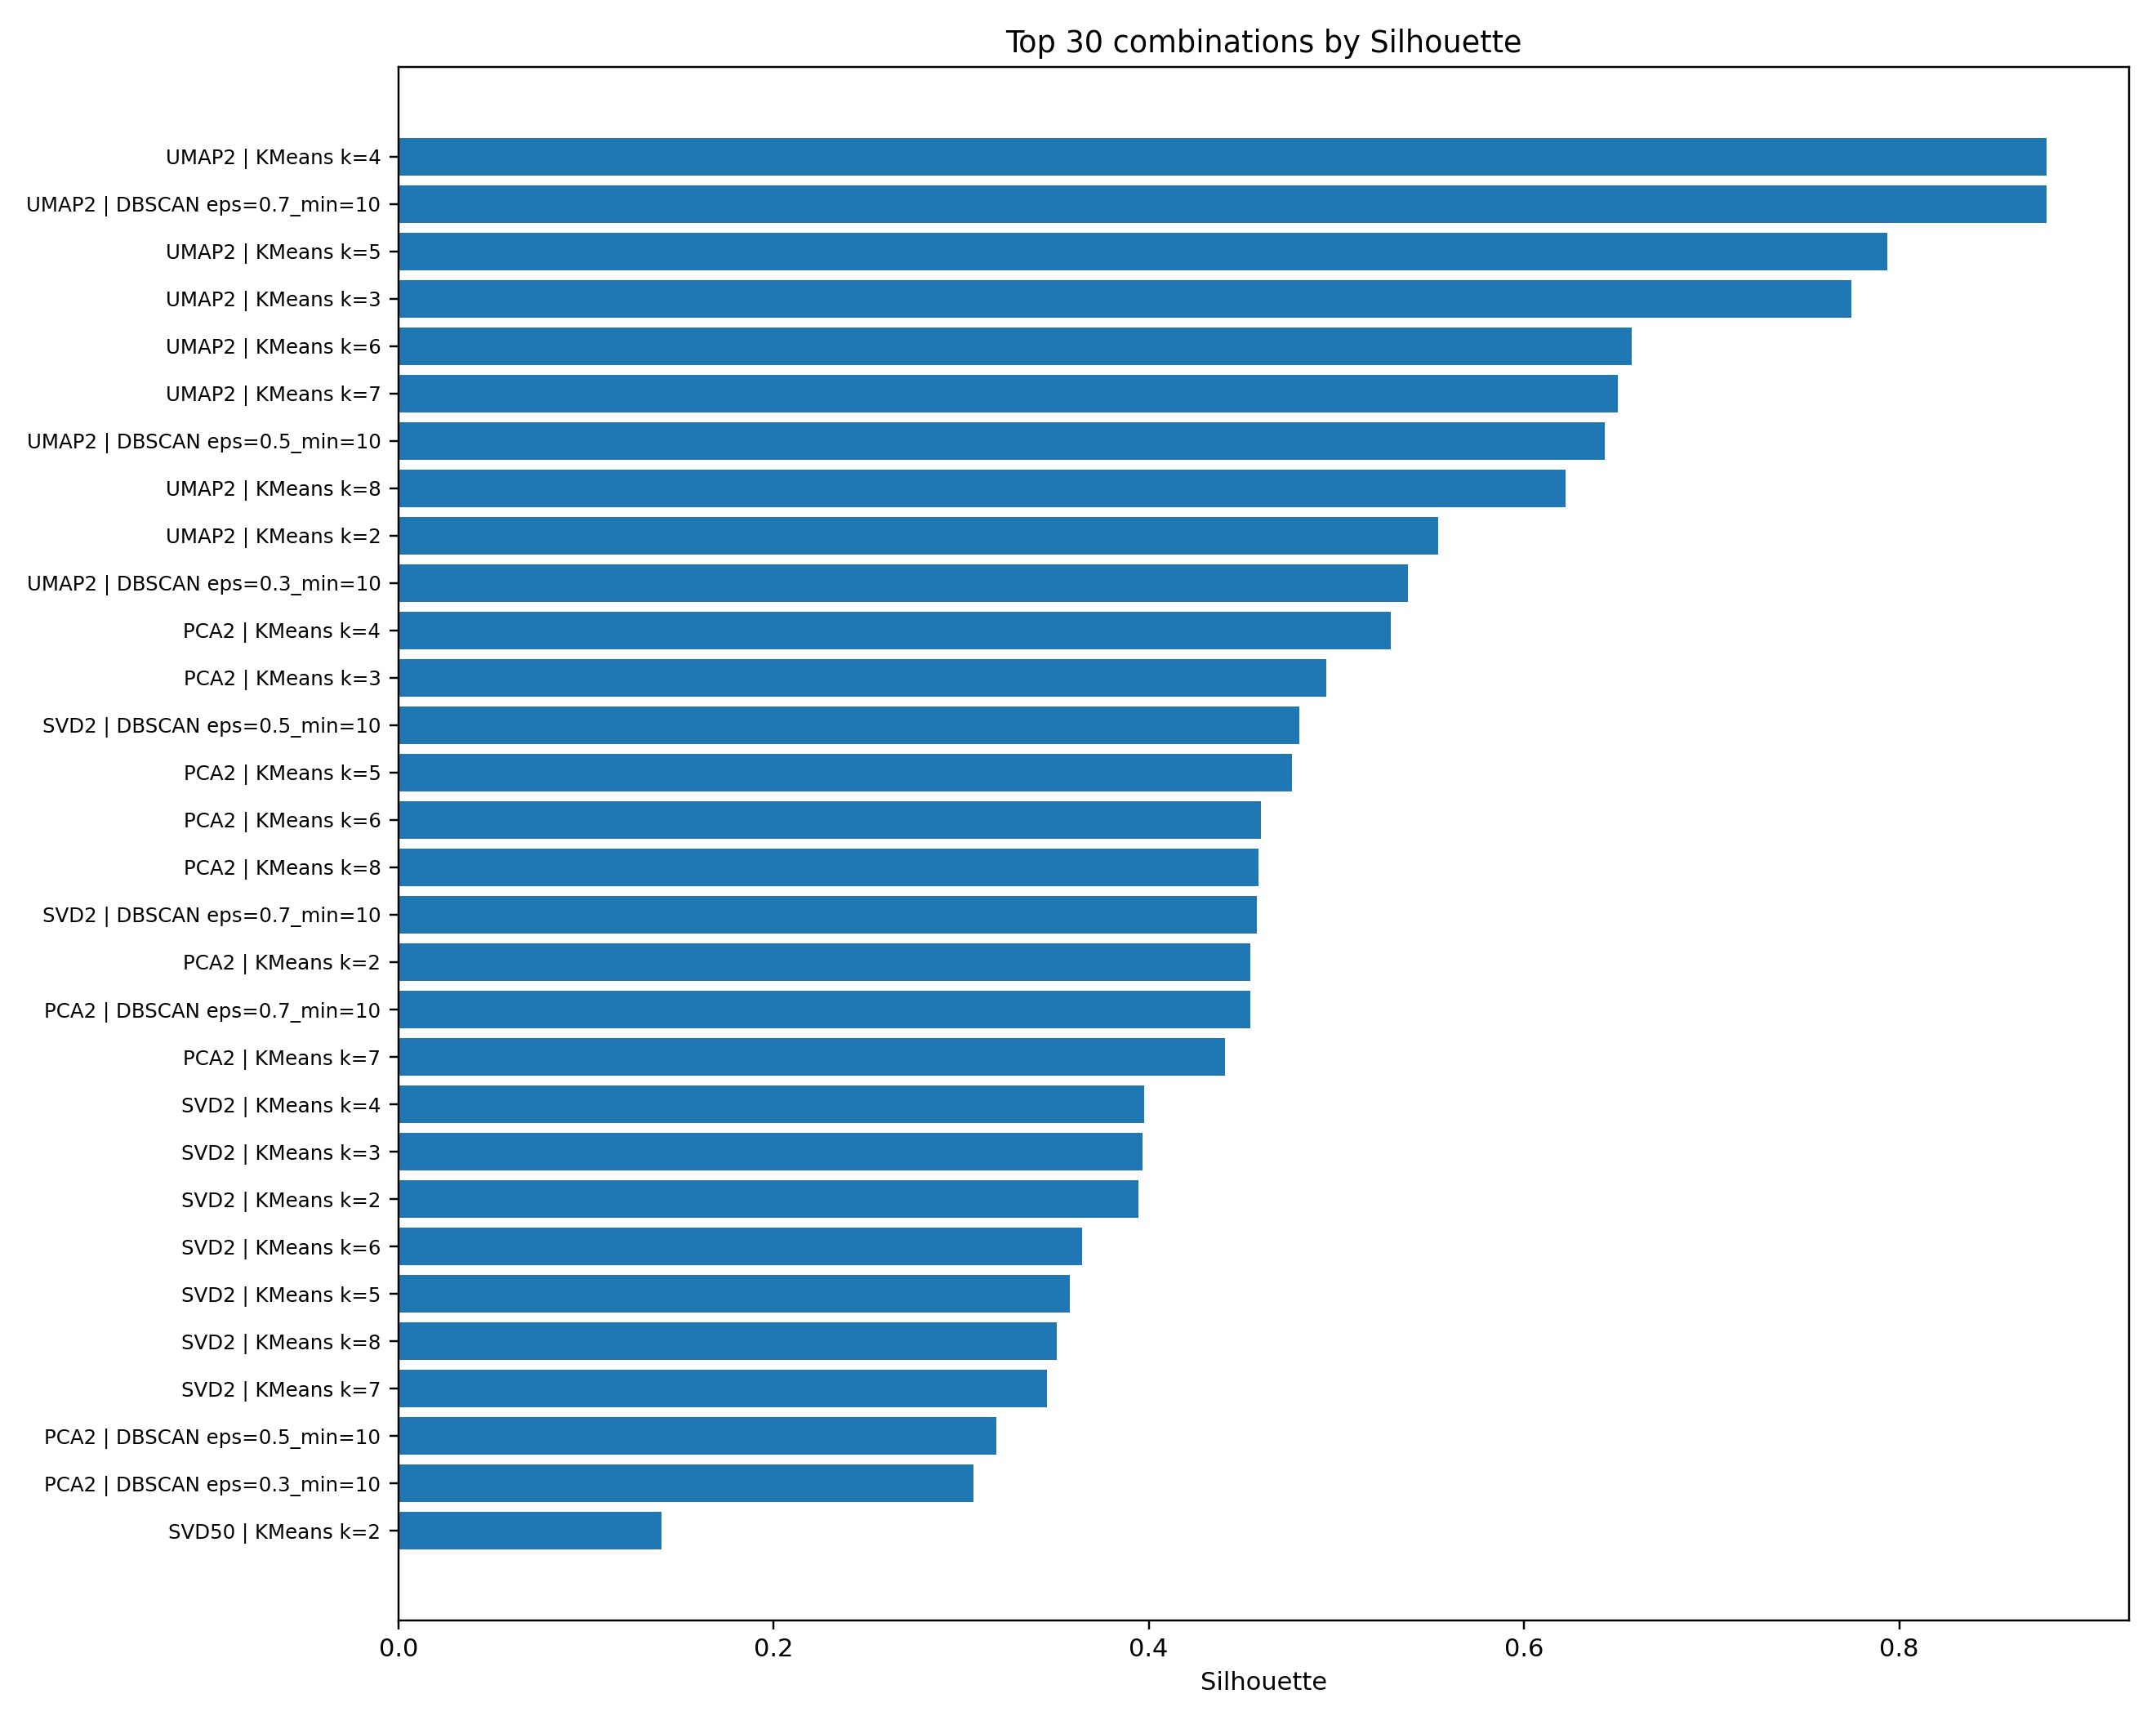

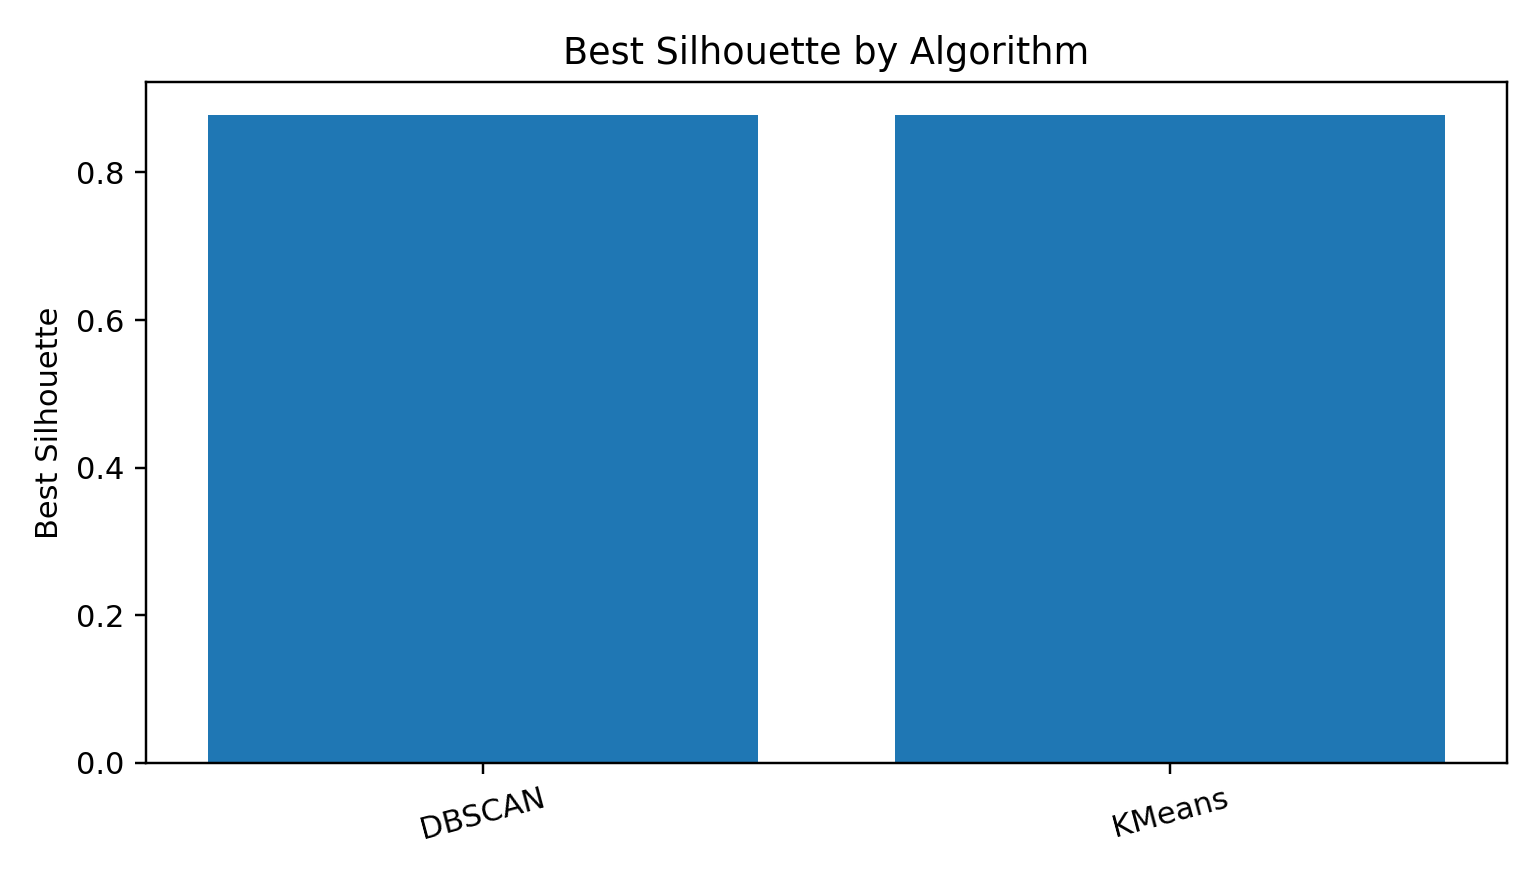

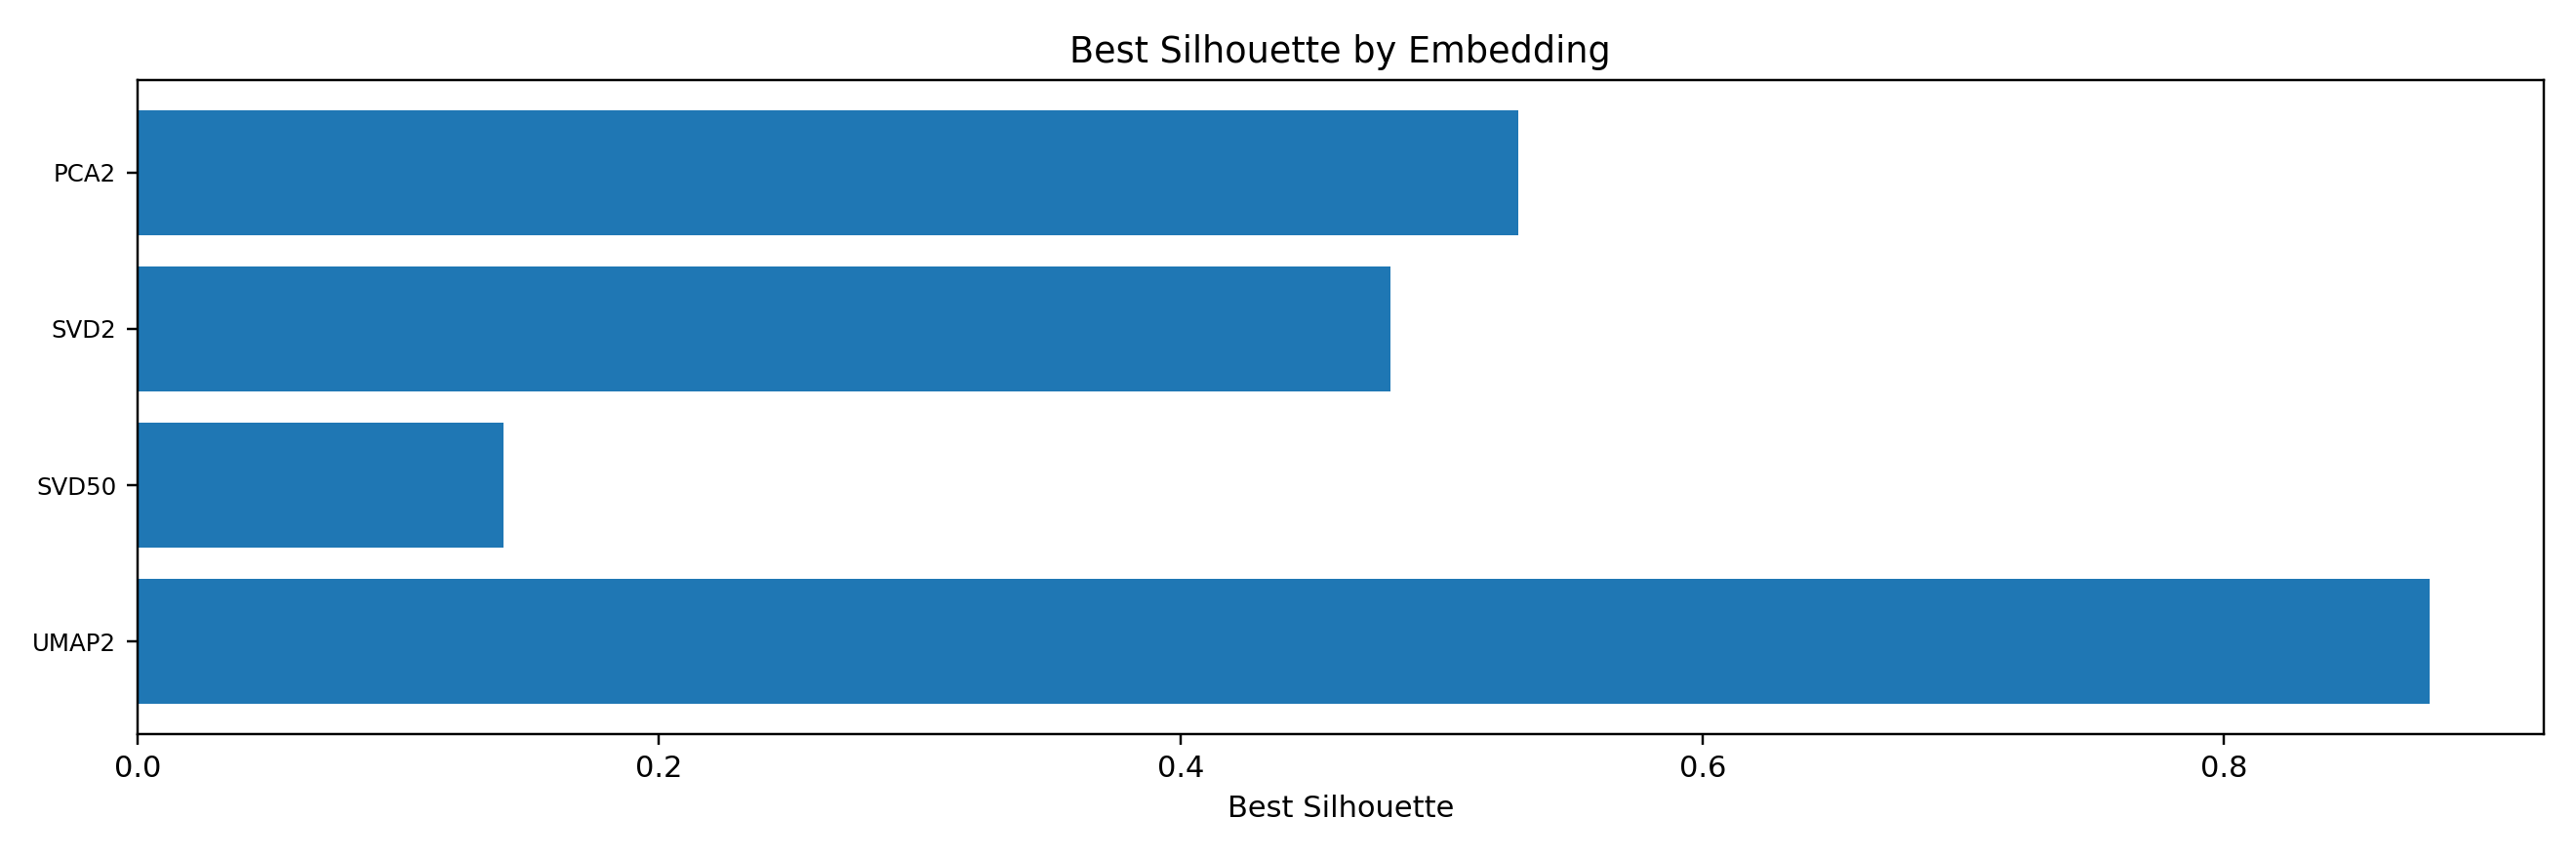

### Summary tables

embedding algorithm          config  embedding_dim  silhouette  \
32     UMAP2    KMeans             k=4              2    0.878574   
39     UMAP2    DBSCAN  eps=0.7_min=10              2    0.878574   
33     UMAP2    KMeans             k=5              2    0.793445   
31     UMAP2    KMeans             k=3              2    0.774336   
34     UMAP2    KMeans             k=6              2    0.657594   
35     UMAP2    KMeans             k=7              2    0.649976   
38     UMAP2    DBSCAN  eps=0.5_min=10              2    0.642919   
36     UMAP2    KMeans             k=8              2    0.622049   
30     UMAP2    KMeans             k=2              2    0.554341   
37     UMAP2    DBSCAN  eps=0.3_min=10              2    0.537915   
22      PCA2    KMeans             k=4              2    0.529191   
21      PCA2    KMeans             k=3              2    0.494613   
18      SVD2    DBSCAN  eps=0.5_min=10              2    0.480278   
23      PCA2    KMeans             k=5              2    0.476449   
24      PCA2    KMeans             k=6              2    0.459648   

    calinski_harabasz  davies_bouldin  n_clusters  n_noise  \
32       41110.097656        0.165247           4        0   
39       41110.097656        0.165247           4        0   
33       42278.304688        0.311604           5        0   
31        6450.632812        0.446404           3        0   
34       50282.039062        0.472131           6        0   
35       50406.832031        0.534462           7        0   
38       31646.787109        0.329394           5        0   
36       51444.863281        0.603290           8        0   
30        1916.563721        0.887982           2        0   
37       21271.718750        0.868516           8       20   
22        2669.137147        0.615480           4        0   
21        2133.920901        0.693967           3        0   
18           2.458027        3.287357           1        3   
23        2911.504902        0.707839           5        0   
24        2799.810503        0.798252           6        0   

                        combination  
32             UMAP2 + KMeans (k=4)  
39  UMAP2 + DBSCAN (eps=0.7_min=10)  
33             UMAP2 + KMeans (k=5)  
31             UMAP2 + KMeans (k=3)  
34             UMAP2 + KMeans (k=6)  
35             UMAP2 + KMeans (k=7)  
38  UMAP2 + DBSCAN (eps=0.5_min=10)  
36             UMAP2 + KMeans (k=8)  
30             UMAP2 + KMeans (k=2)  
37  UMAP2 + DBSCAN (eps=0.3_min=10)  
22              PCA2 + KMeans (k=4)  
21              PCA2 + KMeans (k=3)  
18   SVD2 + DBSCAN (eps=0.5_min=10)  
23              PCA2 + KMeans (k=5)  
24              PCA2 + KMeans (k=6)

### High-performance combinations

embedding algorithm          config  embedding_dim  silhouette  \
1     UMAP2    KMeans             k=4              2    0.878574   
7     UMAP2    DBSCAN  eps=0.7_min=10              2    0.878574   
2     UMAP2    KMeans             k=5              2    0.793445   
0     UMAP2    KMeans             k=3              2    0.774336   
3     UMAP2    KMeans             k=6              2    0.657594   
4     UMAP2    KMeans             k=7              2    0.649976   
6     UMAP2    DBSCAN  eps=0.5_min=10              2    0.642919   
5     UMAP2    KMeans             k=8              2    0.622049   

   calinski_harabasz  davies_bouldin  n_clusters  n_noise  \
1       41110.097656        0.165247           4        0   
7       41110.097656        0.165247           4        0   
2       42278.304688        0.311604           5        0   
0        6450.632812        0.446404           3        0   
3       50282.039062        0.472131           6        0   
4       50406.832031        0.534462           7        0   
6       31646.787109        0.329394           5        0   
5       51444.863281        0.603290           8        0   

                       combination  
1             UMAP2 + KMeans (k=4)  
7  UMAP2 + DBSCAN (eps=0.7_min=10)  
2             UMAP2 + KMeans (k=5)  
0             UMAP2 + KMeans (k=3)  
3             UMAP2 + KMeans (k=6)  
4             UMAP2 + KMeans (k=7)  
6  UMAP2 + DBSCAN (eps=0.5_min=10)  
5             UMAP2 + KMeans (k=8)

### Saved figures

- `best_combination_visualization.png`

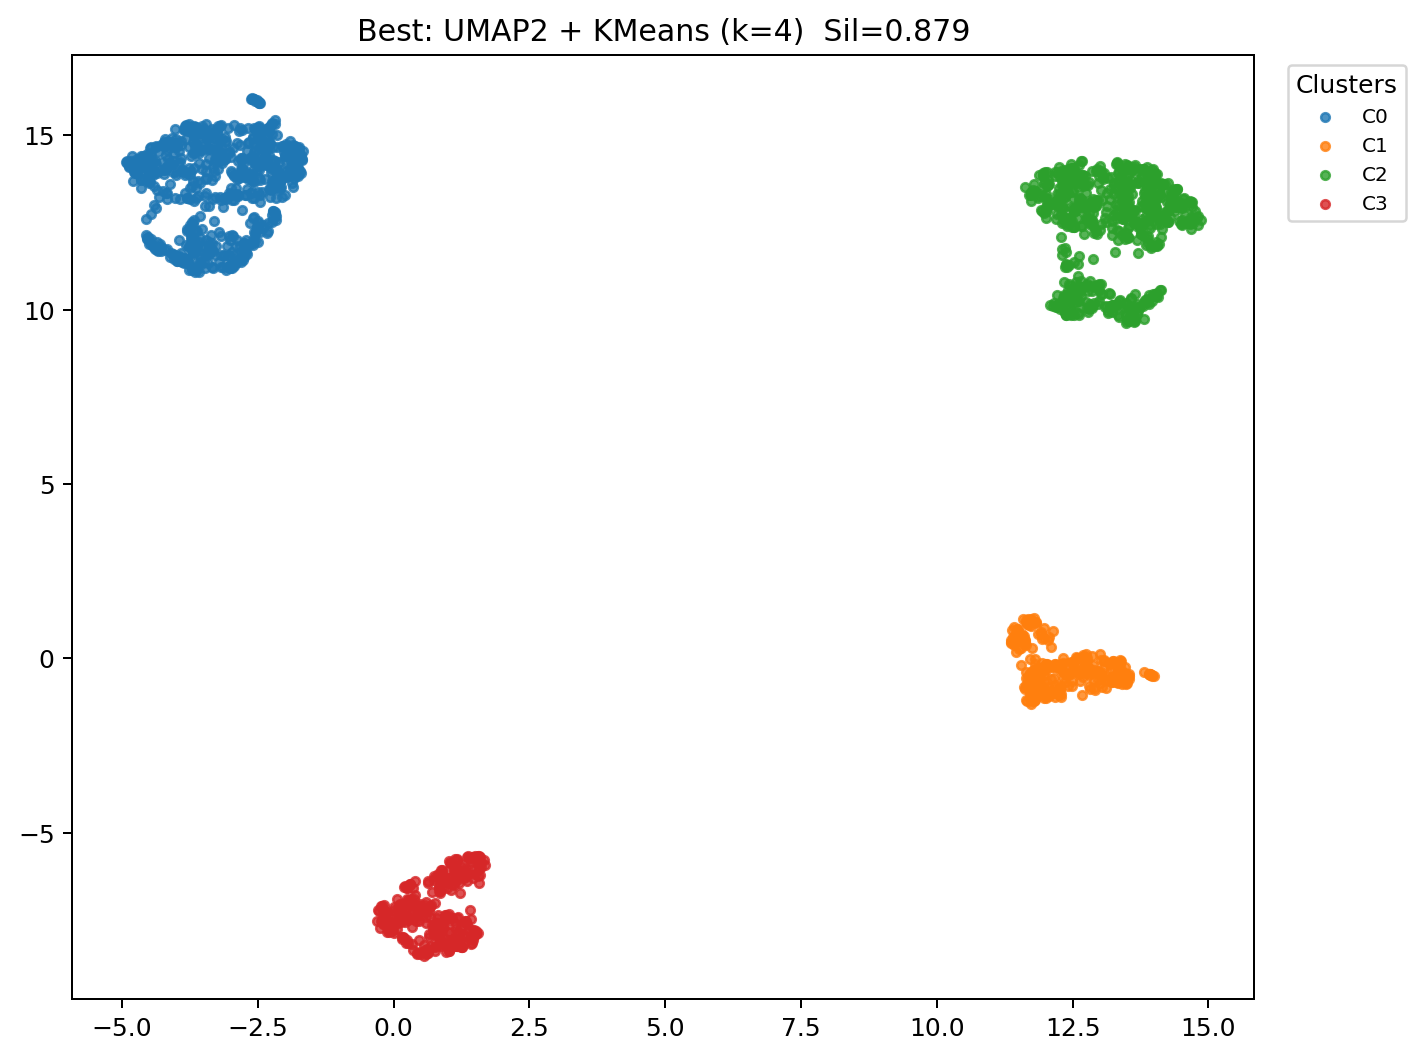

### Cluster interpretation index

combo  silhouette
0             UMAP2 + KMeans (k=4)    0.878574
1  UMAP2 + DBSCAN (eps=0.7_min=10)    0.878574
2             UMAP2 + KMeans (k=5)    0.793445
3             UMAP2 + KMeans (k=3)    0.774336
4             UMAP2 + KMeans (k=6)    0.657594
5             UMAP2 + KMeans (k=7)    0.649976
6  UMAP2 + DBSCAN (eps=0.5_min=10)    0.642919
7             UMAP2 + KMeans (k=8)    0.622049
8             UMAP2 + KMeans (k=2)    0.554341
9  UMAP2 + DBSCAN (eps=0.3_min=10)    0.537915


Overview charts saved → /content/unsup_results/charts_overview


In [9]:
# Run your analysis
from unsupervised import run_unsupervised

OUT_DIR = "/content/unsup_results"

run_unsupervised(
    data="/content/lapd_clean_final.parquet",
    output=OUT_DIR,
    max_samples=5000,
    seed=42,
    interpret=True,
    top_n=10,
)

# ---------- Visualize everything saved in OUT_DIR ----------
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown

def visualize_unsup_results(out_dir: str, topN: int = 30):
    os.makedirs(out_dir, exist_ok=True)
    charts_dir = os.path.join(out_dir, "charts_overview")
    os.makedirs(charts_dir, exist_ok=True)

    all_path  = os.path.join(out_dir, "all_combinations_results.csv")
    high_path = os.path.join(out_dir, "high_performance_combinations.csv")
    idx_json  = os.path.join(out_dir, "cluster_interpretations_index.json")

    # 1) Load results
    df_all = pd.read_csv(all_path) if os.path.exists(all_path) else None
    df_hi  = pd.read_csv(high_path) if os.path.exists(high_path) else None

    if df_all is not None:
        # Ensure helpful derived column exists
        if "combination" not in df_all.columns and {"embedding","algorithm","config"}.issubset(df_all.columns):
            df_all["combination"] = df_all["embedding"] + " + " + df_all["algorithm"] + " (" + df_all["config"] + ")"

        # 2) Top-N silhouettes (barh)
        topN = min(topN, len(df_all))
        tdf = (df_all.dropna(subset=["silhouette"])
                      .nlargest(topN, "silhouette")
                      .copy())
        if len(tdf):
            plt.figure(figsize=(12, max(4, 0.32*len(tdf))))
            ylabels = [f"{r.embedding} | {r.algorithm} {r.config}" for _, r in tdf.iterrows()]
            plt.barh(range(len(tdf)), tdf["silhouette"].values)
            plt.yticks(range(len(tdf)), ylabels, fontsize=8)
            plt.gca().invert_yaxis()
            plt.xlabel("Silhouette")
            plt.title(f"Top {len(tdf)} combinations by Silhouette")
            plt.tight_layout()
            p = os.path.join(charts_dir, "top_silhouette_barh.png")
            plt.savefig(p, dpi=220); plt.close()
            display(Image(p))

        # 3) Best silhouette by algorithm (bar)
        if "algorithm" in df_all.columns:
            best_by_algo = (df_all.dropna(subset=["silhouette"])
                                   .sort_values("silhouette", ascending=False)
                                   .groupby("algorithm", as_index=False)
                                   .first()[["algorithm","silhouette"]])
            if len(best_by_algo):
                plt.figure(figsize=(7,4))
                plt.bar(best_by_algo["algorithm"], best_by_algo["silhouette"])
                plt.ylabel("Best Silhouette")
                plt.title("Best Silhouette by Algorithm")
                plt.xticks(rotation=15)
                plt.tight_layout()
                p = os.path.join(charts_dir, "best_by_algorithm.png")
                plt.savefig(p, dpi=220); plt.close()
                display(Image(p))

        # 4) Best silhouette by embedding (barh)
        if "embedding" in df_all.columns:
            best_by_emb = (df_all.dropna(subset=["silhouette"])
                                  .sort_values("silhouette", ascending=False)
                                  .groupby("embedding", as_index=False)
                                  .first()[["embedding","silhouette"]])
            if len(best_by_emb):
                plt.figure(figsize=(12, max(4, 0.28*len(best_by_emb))))
                plt.barh(range(len(best_by_emb)), best_by_emb["silhouette"])
                plt.yticks(range(len(best_by_emb)), best_by_emb["embedding"], fontsize=8)
                plt.gca().invert_yaxis()
                plt.xlabel("Best Silhouette")
                plt.title("Best Silhouette by Embedding")
                plt.tight_layout()
                p = os.path.join(charts_dir, "best_by_embedding.png")
                plt.savefig(p, dpi=220); plt.close()
                display(Image(p))

        # 5) Print small tables
        display(Markdown("### Summary tables"))
        display(df_all.sort_values("silhouette", ascending=False).head(15))

    if df_hi is not None and len(df_hi):
        display(Markdown("### High-performance combinations"))
        display(df_hi.sort_values("silhouette", ascending=False))

    # 6) Show any images the pipeline already saved (best plot, etc.)
    imgs = sorted(glob.glob(os.path.join(out_dir, "*.png")))
    if imgs:
        display(Markdown("### Saved figures"))
        for img in imgs:
            display(Markdown(f"- `{os.path.basename(img)}`"))
            display(Image(img))

    # 7) Show interpretation index (if present)
    if os.path.exists(idx_json):
        try:
            with open(idx_json, "r") as f:
                idx = json.load(f)
            display(Markdown("### Cluster interpretation index"))
            display(pd.DataFrame(idx))
        except Exception:
            pass

    print(f"\nOverview charts saved → {charts_dir}")

visualize_unsup_results(OUT_DIR, topN=30)


#meaning


In [ ]:
# ===============================================================================
# MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS
# Calculates MI/NMI for features vs cluster labels + creates visualizations
# ===============================================================================

import os, re, json, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency
import umap

# ==================== CONFIGURATION ====================
CLEAN_PATH = "/content/lapd_clean_5k.parquet"  # Your cleaned data
OUT_BASE = "/content/cluster_interpretation"
FIG_BASE = "/content/figs_comprehensive_unsup/charts"
RANDOM_STATE = 42
MAX_CAT_CARD = 30

# Top-10 combinations (from your results)
TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

# Color palette for clusters
CLUSTER_COLORS = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00',
                  '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5']

os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(FIG_BASE, exist_ok=True)

# ==================== HELPER FUNCTIONS ====================
def load_data(path):
    """Load parquet or CSV data"""
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    # Try CSV fallback
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Data not found at {path} or {alt}")

def prepare_feature_matrix(df):
    """Prepare feature matrix for embedding (same as your original pipeline)"""
    # Remove constant columns
    const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
    if const_cols:
        print(f"[CLEAN] Dropping constant columns: {const_cols}")
        df = df.drop(columns=const_cols)

    # Separate numeric and categorical
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_all = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

    # Drop specific columns as per your original pipeline
    DROP_LIKE = {
        "victim_sex", "victim_age", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Crime Code",
        "Crime Code Description", "ARREST MADE", "Status", "Status Desc"
    }
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
    Xdf = df[use_cols].copy()

    # Convert boolean to int
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    return Xdf

def build_preprocessor():
    """Build the same preprocessor as your pipeline"""
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    def make_preprocessor(Xdf):
        num_features = [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]
        cat_features = [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]

        return ColumnTransformer(
            transformers=[
                ("num", StandardScaler(with_mean=False), num_features),
                ("cat", ohe, cat_features),
            ],
            remainder="drop",
        )

    return make_preprocessor

def parse_combo_string(combo_str):
    """Parse combination string to extract UMAP and KMeans parameters"""
    # "UMAP5_n15_d0.1 + KMeans (k=3)"
    pattern = r"(UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+))\s+\+\s+KMeans\s+\(k=(\d+)\)"
    match = re.match(pattern, combo_str.strip())

    if not match:
        raise ValueError(f"Cannot parse combo: {combo_str}")

    umap_tag = match.group(1)
    n_components = int(match.group(2))
    n_neighbors = int(match.group(3))
    min_dist = float(match.group(4))
    k_clusters = int(match.group(5))

    return {
        'umap_tag': umap_tag,
        'n_components': n_components,
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'k_clusters': k_clusters
    }

def build_umap_embedding(X_input, n_components, n_neighbors, min_dist):
    """Build UMAP embedding with specified parameters"""
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=RANDOM_STATE,
        verbose=False,
    )
    return reducer.fit_transform(X_input)

def calculate_mutual_information(df, labels, min_samples=10):
    """Calculate MI/NMI for all features vs cluster labels"""
    results = []

    for col in df.columns:
        if col in ['__cluster', '__labels']:
            continue

        series = df[col]

        # Skip if too few non-null values
        valid_mask = series.notna()
        if valid_mask.sum() < min_samples:
            continue

        try:
            if pd.api.types.is_numeric_dtype(series):
                # For numeric features, use mutual_info_classif
                X_col = pd.to_numeric(series, errors='coerce').values.reshape(-1, 1)
                y_labels = labels.astype(int)

                # Remove NaN values
                valid_indices = ~np.isnan(X_col[:, 0])
                if valid_indices.sum() < min_samples:
                    continue

                X_valid = X_col[valid_indices]
                y_valid = y_labels[valid_indices]

                # Ensure we have multiple clusters
                if len(np.unique(y_valid)) <= 1:
                    continue

                mi_score = mutual_info_classif(
                    X_valid, y_valid,
                    discrete_features=False,
                    random_state=RANDOM_STATE
                )[0]

                results.append({
                    'feature': col,
                    'MI_score': float(mi_score),
                    'type': 'numeric',
                    'n_valid': int(valid_indices.sum())
                })

            else:
                # For categorical features, use normalized mutual information
                series_clean = series.astype(str).fillna("__MISSING__")

                nmi_score = normalized_mutual_info_score(
                    series_clean, labels, average_method='arithmetic'
                )

                results.append({
                    'feature': col,
                    'MI_score': float(nmi_score),
                    'type': 'categorical',
                    'n_valid': int(valid_mask.sum())
                })

        except Exception as e:
            print(f"[WARN] Failed to calculate MI for {col}: {e}")
            continue

    return pd.DataFrame(results).sort_values('MI_score', ascending=False)

def create_mi_visualization(mi_df, combo_name, output_path, top_n=20):
    """Create horizontal bar chart for MI scores"""
    top_features = mi_df.head(top_n)

    # Color by feature type
    colors = ['#2E86AB' if t == 'numeric' else '#A23B72' for t in top_features['type']]

    plt.figure(figsize=(12, max(6, len(top_features) * 0.4)))
    bars = plt.barh(range(len(top_features)), top_features['MI_score'], color=colors)

    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.title(f'Top {top_n} Features by Mutual Information\n{combo_name}', fontsize=14, pad=20)
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_features['MI_score'])):
        plt.text(score + max(top_features['MI_score']) * 0.01, i,
                f'{score:.4f}', va='center', fontsize=9)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2E86AB', label='Numeric'),
        Patch(facecolor='#A23B72', label='Categorical')
    ]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

def create_cluster_scatter(X_embedding, labels, combo_name, output_path):
    """Create scatter plot of embedding colored by cluster"""
    if X_embedding.shape[1] < 2:
        print(f"[WARN] Cannot create scatter for {combo_name}: embedding has {X_embedding.shape[1]} dimensions")
        return None

    unique_labels = sorted(set(labels))
    n_clusters = len([l for l in unique_labels if l >= 0])

    plt.figure(figsize=(10, 8))

    for i, label in enumerate(unique_labels):
        mask = labels == label
        color = CLUSTER_COLORS[i % len(CLUSTER_COLORS)]

        if label == -1:  # Noise points
            plt.scatter(X_embedding[mask, 0], X_embedding[mask, 1],
                       c='gray', s=20, alpha=0.5, label='Noise')
        else:
            plt.scatter(X_embedding[mask, 0], X_embedding[mask, 1],
                       c=color, s=30, alpha=0.7, label=f'Cluster {label}')

    plt.xlabel(f'UMAP Dimension 1', fontsize=12)
    plt.ylabel(f'UMAP Dimension 2', fontsize=12)
    plt.title(f'Cluster Visualization\n{combo_name}', fontsize=14, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add cluster statistics
    stats_text = f'Total points: {len(labels)}\nClusters: {n_clusters}'
    if -1 in labels:
        noise_count = np.sum(labels == -1)
        stats_text += f'\nNoise points: {noise_count}'

    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

def create_feature_correlation_heatmap(mi_df, df, labels, combo_name, output_path, top_n=15):
    """Create correlation heatmap for top MI features across clusters"""
    top_features = mi_df.head(top_n)

    # Calculate feature means by cluster
    df_with_clusters = df.copy()
    df_with_clusters['__cluster'] = labels

    cluster_means = []
    feature_names = []

    for _, row in top_features.iterrows():
        feature = row['feature']
        if feature not in df.columns:
            continue

        if row['type'] == 'numeric':
            means = df_with_clusters.groupby('__cluster')[feature].mean()
            cluster_means.append(means.values)
            feature_names.append(feature)
        else:
            # For categorical, use mode or most frequent category proportion
            try:
                proportions = df_with_clusters.groupby('__cluster')[feature].apply(
                    lambda x: x.value_counts(normalize=True).iloc[0] if len(x) > 0 else 0
                )
                cluster_means.append(proportions.values)
                feature_names.append(f"{feature} (prop)")
            except:
                continue

    if not cluster_means:
        return None

    # Create matrix
    cluster_matrix = np.array(cluster_means)
    unique_clusters = sorted(set(labels) - {-1})  # Exclude noise

    plt.figure(figsize=(max(8, len(unique_clusters) * 1.2), max(6, len(feature_names) * 0.5)))

    # Normalize each row for better visualization
    normalized_matrix = (cluster_matrix - cluster_matrix.mean(axis=1, keepdims=True)) / (cluster_matrix.std(axis=1, keepdims=True) + 1e-8)

    im = plt.imshow(normalized_matrix, aspect='auto', cmap='RdYlBu_r')
    plt.colorbar(im, label='Standardized Feature Value')

    plt.yticks(range(len(feature_names)), feature_names, fontsize=10)
    plt.xticks(range(len(unique_clusters)), [f'Cluster {c}' for c in unique_clusters], fontsize=10)
    plt.title(f'Feature Profiles Across Clusters\n{combo_name}', fontsize=14, pad=20)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    return output_path

# ==================== MAIN PROCESSING ====================
def main():
    print("="*80)
    print("MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS")
    print("="*80)

    # Load data
    df = load_data(CLEAN_PATH)
    print(f"Loaded data: {df.shape}")

    # Prepare feature matrix
    Xdf = prepare_feature_matrix(df)
    preprocessor_builder = build_preprocessor()
    preprocessor = preprocessor_builder(Xdf)

    X_sparse = preprocessor.fit_transform(Xdf)
    print(f"Feature matrix: {X_sparse.shape}")

    # Apply SVD for dimensionality reduction (as in your pipeline)
    svd_components = min(50, max(2, X_sparse.shape[1] - 1))
    svd = TruncatedSVD(n_components=svd_components, random_state=RANDOM_STATE)
    X_svd = svd.fit_transform(X_sparse)
    print(f"SVD reduction: {X_svd.shape}, explained variance: {svd.explained_variance_ratio_.sum():.3f}")

    # Process each combination
    all_results = []

    for rank, combo in enumerate(TOP10, 1):
        print(f"\n[{rank}/10] Processing: {combo}")

        try:
            # Parse combination parameters
            params = parse_combo_string(combo)
            combo_slug = re.sub(r'[^\w\-_]', '_', combo)

            # Create output directory
            combo_dir = os.path.join(OUT_BASE, combo_slug)
            os.makedirs(combo_dir, exist_ok=True)

            # Build UMAP embedding
            X_embedding = build_umap_embedding(
                X_svd,
                params['n_components'],
                params['n_neighbors'],
                params['min_dist']
            )

            # Perform clustering
            kmeans = KMeans(n_clusters=params['k_clusters'], n_init=10, random_state=RANDOM_STATE)
            labels = kmeans.fit_predict(X_embedding)

            # Calculate mutual information
            mi_df = calculate_mutual_information(df, labels)

            # Save results
            mi_path = os.path.join(combo_dir, 'mutual_information_results.csv')
            mi_df.to_csv(mi_path, index=False)

            # Create visualizations
            print(f"  Creating visualizations...")

            # 1. MI bar chart
            mi_plot_path = os.path.join(FIG_BASE, f'{combo_slug}_mi_scores.png')
            create_mi_visualization(mi_df, combo, mi_plot_path)

            # 2. Cluster scatter (if 2D+)
            if X_embedding.shape[1] >= 2:
                scatter_path = os.path.join(FIG_BASE, f'{combo_slug}_cluster_scatter.png')
                create_cluster_scatter(X_embedding, labels, combo, scatter_path)

            # 3. Feature correlation heatmap
            heatmap_path = os.path.join(FIG_BASE, f'{combo_slug}_feature_heatmap.png')
            create_feature_correlation_heatmap(mi_df, df, labels, combo, heatmap_path)

            # Save cluster labels
            labels_df = pd.DataFrame({
                'index': range(len(labels)),
                'cluster_label': labels
            })
            labels_path = os.path.join(combo_dir, 'cluster_labels.csv')
            labels_df.to_csv(labels_path, index=False)

            # Collect summary statistics
            n_features_significant = len(mi_df[mi_df['MI_score'] > 0.01])  # Arbitrary threshold
            max_mi = mi_df['MI_score'].max() if len(mi_df) > 0 else 0

            all_results.append({
                'rank': rank,
                'combination': combo,
                'n_clusters': params['k_clusters'],
                'embedding_dim': params['n_components'],
                'n_features_analyzed': len(mi_df),
                'n_features_significant': n_features_significant,
                'max_mi_score': max_mi,
                'top_feature': mi_df.iloc[0]['feature'] if len(mi_df) > 0 else None,
                'mi_file': mi_path,
                'visualizations': [mi_plot_path, scatter_path if X_embedding.shape[1] >= 2 else None, heatmap_path]
            })

            print(f"  ✓ MI results: {len(mi_df)} features, max MI: {max_mi:.4f}")

        except Exception as e:
            print(f"  ✗ Error processing {combo}: {e}")
            continue

    # Save summary
    summary_df = pd.DataFrame(all_results)
    summary_path = os.path.join(OUT_BASE, 'top10_mi_summary.csv')
    summary_df.to_csv(summary_path, index=False)

    # Print results summary
    print("\n" + "="*80)
    print("MUTUAL INFORMATION ANALYSIS SUMMARY")
    print("="*80)
    print(summary_df[['rank', 'combination', 'n_features_analyzed', 'max_mi_score', 'top_feature']].to_string(index=False))

    print(f"\n✓ Analysis complete!")
    print(f"  • Results saved to: {OUT_BASE}")
    print(f"  • Visualizations saved to: {FIG_BASE}")
    print(f"  • Summary: {summary_path}")

if __name__ == "__main__":
    main()

MUTUAL INFORMATION ANALYSIS FOR TOP-10 CLUSTERING COMBINATIONS
[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
Loaded data: (1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
Feature matrix: (1651, 38)
SVD reduction: (1651, 37), explained variance: 1.000

[1/10] Processing: UMAP5_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[2/10] Processing: UMAP7_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[3/10] Processing: UMAP8_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6995

[4/10] Processing: UMAP4_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[5/10] Processing: UMAP6_n15_d0.1 + KMeans (k=3)
  Creating visualizations...
  ✓ MI results: 23 features, max MI: 0.6985

[6/10] Processing: UMAP3_n15_d0.1 + KMeans (k=3)
  C

In [ ]:
#version2
# ===============================================================================
# STATISTICAL SIGNIFICANCE ANALYSIS FOR TOP-10 CLUSTERING RESULTS
# Enhanced MI analysis with significance testing and publication-ready plots
# ===============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import normalized_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def calculate_statistical_significance(df, labels, alpha=0.05):
    """
    Calculate statistical significance for features vs clusters using appropriate tests
    Returns MI scores with p-values and significance indicators
    """
    results = []
    unique_clusters = np.unique(labels[labels >= 0])  # Exclude noise (-1)

    if len(unique_clusters) < 2:
        print("Warning: Less than 2 clusters found, skipping significance tests")
        return pd.DataFrame()

    for col in df.columns:
        if col.startswith('__'):
            continue

        series = df[col].copy()
        valid_mask = series.notna() & (labels >= 0)  # Exclude noise and NaN

        if valid_mask.sum() < 10:  # Minimum sample size
            continue

        series_valid = series[valid_mask]
        labels_valid = labels[valid_mask]

        try:
            if pd.api.types.is_numeric_dtype(series):
                # Numeric feature: Use ANOVA F-test and MI
                cluster_groups = [series_valid[labels_valid == c] for c in unique_clusters]
                cluster_groups = [g for g in cluster_groups if len(g) > 0]

                if len(cluster_groups) < 2:
                    continue

                # F-test (ANOVA)
                f_stat, p_value = f_oneway(*cluster_groups)

                # Mutual Information
                X_col = series_valid.values.reshape(-1, 1)
                mi_score = mutual_info_classif(X_col, labels_valid,
                                             discrete_features=False,
                                             random_state=42)[0]

                # Effect size (eta-squared)
                ss_total = np.sum((series_valid - series_valid.mean())**2)
                ss_within = sum(np.sum((group - group.mean())**2) for group in cluster_groups)
                eta_squared = (ss_total - ss_within) / ss_total if ss_total > 0 else 0

                results.append({
                    'feature': col,
                    'type': 'numeric',
                    'test_statistic': f_stat,
                    'p_value': p_value,
                    'mi_score': mi_score,
                    'effect_size': eta_squared,
                    'n_valid': len(series_valid),
                    'significant': p_value < alpha
                })

            else:
                # Categorical feature: Use Chi-square test and NMI
                contingency_table = pd.crosstab(series_valid, labels_valid)

                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
                    continue

                # Chi-square test
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)

                # Normalized Mutual Information
                nmi_score = normalized_mutual_info_score(series_valid, labels_valid)

                # Cramér's V (effect size for categorical)
                n = contingency_table.sum().sum()
                cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

                results.append({
                    'feature': col,
                    'type': 'categorical',
                    'test_statistic': chi2,
                    'p_value': p_value,
                    'mi_score': nmi_score,
                    'effect_size': cramers_v,
                    'n_valid': len(series_valid),
                    'significant': p_value < alpha
                })

        except Exception as e:
            print(f"Error processing {col}: {e}")
            continue

    return pd.DataFrame(results).sort_values('mi_score', ascending=False)

def create_enhanced_mi_plot(results_df, combo_name, save_path, top_n=20):
    """Create enhanced MI plot with significance indicators"""
    top_results = results_df.head(top_n)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(top_results) * 0.4)))

    # Left plot: MI scores with significance
    colors = ['#d62728' if sig else '#1f77b4' for sig in top_results['significant']]
    bars1 = ax1.barh(range(len(top_results)), top_results['mi_score'], color=colors, alpha=0.7)

    ax1.set_yticks(range(len(top_results)))
    ax1.set_yticklabels(top_results['feature'], fontsize=10)
    ax1.set_xlabel('Mutual Information Score', fontsize=12)
    ax1.set_title('MI Scores (Red = Significant)', fontsize=12)
    ax1.invert_yaxis()

    # Add significance markers
    for i, (bar, pval) in enumerate(zip(bars1, top_results['p_value'])):
        if pval < 0.001:
            marker = '***'
        elif pval < 0.01:
            marker = '**'
        elif pval < 0.05:
            marker = '*'
        else:
            marker = ''

        if marker:
            ax1.text(bar.get_width() + max(top_results['mi_score']) * 0.01, i,
                    marker, va='center', fontsize=12, weight='bold')

    # Right plot: Effect sizes
    effect_colors = ['#2ca02c' if t == 'numeric' else '#ff7f0e' for t in top_results['type']]
    bars2 = ax2.barh(range(len(top_results)), top_results['effect_size'], color=effect_colors, alpha=0.7)

    ax2.set_yticks(range(len(top_results)))
    ax2.set_yticklabels([''] * len(top_results))  # Empty labels to avoid duplication
    ax2.set_xlabel('Effect Size (η² or Cramér\'s V)', fontsize=12)
    ax2.set_title('Effect Sizes', fontsize=12)
    ax2.invert_yaxis()

    # Add legends
    from matplotlib.patches import Patch
    legend1 = [Patch(facecolor='#d62728', alpha=0.7, label='Significant (p<0.05)'),
              Patch(facecolor='#1f77b4', alpha=0.7, label='Not Significant')]
    ax1.legend(handles=legend1, loc='lower right', fontsize=10)

    legend2 = [Patch(facecolor='#2ca02c', alpha=0.7, label='Numeric (η²)'),
              Patch(facecolor='#ff7f0e', alpha=0.7, label='Categorical (Cramér\'s V)')]
    ax2.legend(handles=legend2, loc='lower right', fontsize=10)

    plt.suptitle(f'Statistical Analysis: {combo_name}', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return save_path

def create_cluster_profile_heatmap(df, labels, top_features, combo_name, save_path):
    """Create detailed cluster profile heatmap"""
    df_analysis = df[top_features].copy()
    df_analysis['__cluster'] = labels

    # Filter out noise points
    valid_mask = labels >= 0
    df_clean = df_analysis[valid_mask]

    cluster_profiles = []
    feature_names = []

    for feature in top_features:
        if feature not in df.columns:
            continue

        if pd.api.types.is_numeric_dtype(df[feature]):
            # For numeric: calculate standardized means
            cluster_means = df_clean.groupby('__cluster')[feature].mean()
            # Standardize across clusters
            std_means = (cluster_means - cluster_means.mean()) / (cluster_means.std() + 1e-8)
            cluster_profiles.append(std_means.values)
            feature_names.append(feature)
        else:
            # For categorical: calculate entropy or dominant category proportion
            try:
                cluster_entropy = df_clean.groupby('__cluster')[feature].apply(
                    lambda x: -np.sum((x.value_counts(normalize=True) *
                                     np.log2(x.value_counts(normalize=True) + 1e-8)).fillna(0))
                )
                # Invert entropy so higher values = more homogeneous
                homogeneity = 1 / (1 + cluster_entropy)
                cluster_profiles.append(homogeneity.values)
                feature_names.append(f"{feature}_homogeneity")
            except:
                continue

    if not cluster_profiles:
        return None

    # Create heatmap
    profile_matrix = np.array(cluster_profiles)
    unique_clusters = sorted(set(labels) - {-1})

    plt.figure(figsize=(max(8, len(unique_clusters) * 1.5), max(6, len(feature_names) * 0.6)))

    # Use diverging colormap
    im = plt.imshow(profile_matrix, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='Standardized Value', shrink=0.8)

    plt.yticks(range(len(feature_names)), feature_names, fontsize=11)
    plt.xticks(range(len(unique_clusters)), [f'Cluster {c}' for c in unique_clusters], fontsize=11)

    # Add value annotations
    for i in range(len(feature_names)):
        for j in range(len(unique_clusters)):
            text = f'{profile_matrix[i, j]:.2f}'
            plt.text(j, i, text, ha='center', va='center',
                    color='white' if abs(profile_matrix[i, j]) > 1 else 'black',
                    fontsize=9, weight='bold')

    plt.title(f'Cluster Profiles Heatmap\n{combo_name}', fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return save_path

def create_significance_summary_plot(all_combo_results, save_path):
    """Create summary plot across all combinations"""
    summary_data = []

    for combo, results_df in all_combo_results.items():
        if len(results_df) == 0:
            continue

        n_significant = results_df['significant'].sum()
        n_total = len(results_df)
        max_mi = results_df['mi_score'].max()
        mean_mi = results_df['mi_score'].mean()

        summary_data.append({
            'combination': combo,
            'n_significant': n_significant,
            'n_total': n_total,
            'prop_significant': n_significant / n_total if n_total > 0 else 0,
            'max_mi': max_mi,
            'mean_mi': mean_mi
        })

    summary_df = pd.DataFrame(summary_data)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Number of significant features
    ax1.barh(range(len(summary_df)), summary_df['n_significant'],
             color=plt.cm.viridis(summary_df['prop_significant']))
    ax1.set_yticks(range(len(summary_df)))
    ax1.set_yticklabels([c.replace(' + ', '\n') for c in summary_df['combination']], fontsize=9)
    ax1.set_xlabel('Number of Significant Features')
    ax1.set_title('Significant Features by Combination')
    ax1.invert_yaxis()

    # Plot 2: Proportion significant
    ax2.barh(range(len(summary_df)), summary_df['prop_significant'],
             color=plt.cm.plasma(summary_df['prop_significant']))
    ax2.set_yticks(range(len(summary_df)))
    ax2.set_yticklabels([''] * len(summary_df))
    ax2.set_xlabel('Proportion of Features Significant')
    ax2.set_title('Significance Rate by Combination')
    ax2.invert_yaxis()

    # Plot 3: Maximum MI score
    ax3.barh(range(len(summary_df)), summary_df['max_mi'],
             color=plt.cm.coolwarm(summary_df['max_mi'] / summary_df['max_mi'].max()))
    ax3.set_yticks(range(len(summary_df)))
    ax3.set_yticklabels([''] * len(summary_df))
    ax3.set_xlabel('Maximum MI Score')
    ax3.set_title('Highest MI Score by Combination')
    ax3.invert_yaxis()

    # Plot 4: Mean MI score
    ax4.barh(range(len(summary_df)), summary_df['mean_mi'],
             color=plt.cm.inferno(summary_df['mean_mi'] / summary_df['mean_mi'].max()))
    ax4.set_yticks(range(len(summary_df)))
    ax4.set_yticklabels([''] * len(summary_df))
    ax4.set_xlabel('Mean MI Score')
    ax4.set_title('Average MI Score by Combination')
    ax4.invert_yaxis()

    plt.suptitle('Statistical Significance Summary Across Top-10 Combinations',
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    return summary_df

def run_enhanced_analysis(df, top10_combinations, preprocessed_data):
    """
    Main function to run enhanced MI analysis with statistical significance

    Args:
        df: Original dataframe
        top10_combinations: List of top 10 combination strings
        preprocessed_data: Dictionary with embeddings and labels for each combination
    """

    print("="*80)
    print("ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*80)

    all_results = {}
    all_summaries = []

    for i, combo in enumerate(top10_combinations, 1):
        print(f"\n[{i}/10] Analyzing: {combo}")

        # Get embedding and labels (you'll need to pass these from your main analysis)
        # For now, assuming they're available in preprocessed_data dict
        if combo not in preprocessed_data:
            print(f"  Warning: No preprocessed data found for {combo}")
            continue

        labels = preprocessed_data[combo]['labels']

        # Calculate statistical significance
        results_df = calculate_statistical_significance(df, labels)

        if len(results_df) == 0:
            print(f"  No significant results found for {combo}")
            continue

        all_results[combo] = results_df

        # Create visualizations
        combo_slug = combo.replace(' + ', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')

        # Enhanced MI plot
        mi_plot_path = f"/content/figs_comprehensive_unsup/charts/{combo_slug}_enhanced_mi.png"
        create_enhanced_mi_plot(results_df, combo, mi_plot_path)

        # Cluster profile heatmap
        top_features = results_df.head(15)['feature'].tolist()
        heatmap_path = f"/content/figs_comprehensive_unsup/charts/{combo_slug}_profile_heatmap.png"
        create_cluster_profile_heatmap(df, labels, top_features, combo, heatmap_path)

        # Summary statistics
        n_significant = results_df['significant'].sum()
        max_mi = results_df['mi_score'].max()
        top_feature = results_df.iloc[0]['feature']

        summary = {
            'rank': i,
            'combination': combo,
            'n_features': len(results_df),
            'n_significant': n_significant,
            'significance_rate': n_significant / len(results_df),
            'max_mi_score': max_mi,
            'top_feature': top_feature,
            'top_feature_pvalue': results_df.iloc[0]['p_value']
        }
        all_summaries.append(summary)

        print(f"  ✓ Features analyzed: {len(results_df)}")
        print(f"  ✓ Significant features: {n_significant} ({n_significant/len(results_df)*100:.1f}%)")
        print(f"  ✓ Top feature: {top_feature} (MI={max_mi:.4f})")

        # Save individual results
        results_path = f"/content/cluster_interpretation/{combo_slug}_statistical_analysis.csv"
        results_df.to_csv(results_path, index=False)

    # Create summary visualization
    if all_results:
        summary_plot_path = "/content/figs_comprehensive_unsup/charts/significance_summary_all_combos.png"
        summary_df = create_significance_summary_plot(all_results, summary_plot_path)

        # Save overall summary
        summary_df_full = pd.DataFrame(all_summaries)
        summary_path = "/content/cluster_interpretation/statistical_significance_summary.csv"
        summary_df_full.to_csv(summary_path, index=False)

        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE SUMMARY")
        print("="*80)
        print(summary_df_full.to_string(index=False, float_format='%.4f'))

        print(f"\n✓ Enhanced analysis complete!")
        print(f"  • Individual results: /content/cluster_interpretation/")
        print(f"  • Visualizations: /content/figs_comprehensive_unsup/charts/")
        print(f"  • Summary: {summary_path}")

    return all_results, all_summaries

# ===============================================================================
# INTEGRATION HELPER FUNCTION
# ===============================================================================

def integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE):
    """
    Integration function that works with your existing pipeline
    """
    import os, re
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.cluster import KMeans
    from sklearn.decomposition import TruncatedSVD
    import umap

    # Load and prepare data (same as your pipeline)
    if CLEAN_PATH.endswith('.parquet'):
        df = pd.read_parquet(CLEAN_PATH)
    else:
        df = pd.read_csv(CLEAN_PATH, low_memory=False)

    print(f"Loaded data: {df.shape}")

    # Feature preparation (simplified version of your pipeline)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])
                and df[c].nunique() <= 30]

    DROP_LIKE = {"victim_sex", "victim_age", "Part 1-2", "Crm Cd", "Crm Cd Desc",
                 "Crime Code", "Crime Code Description", "ARREST MADE", "Status", "Status Desc"}
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]

    Xdf = df[use_cols].copy()
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    # Preprocessing
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", ohe, [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ], remainder="drop")

    X_sparse = preprocessor.fit_transform(Xdf)

    # SVD
    svd_comp = min(50, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=svd_comp, random_state=42)
    X_svd = svd.fit_transform(X_sparse)

    # Process each combination and collect results
    preprocessed_data = {}

    def parse_combo(combo_str):
        pattern = r"(UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+))\s+\+\s+KMeans\s+\(k=(\d+)\)"
        match = re.match(pattern, combo_str.strip())
        if not match:
            raise ValueError(f"Cannot parse: {combo_str}")
        return {
            'n_components': int(match.group(2)),
            'n_neighbors': int(match.group(3)),
            'min_dist': float(match.group(4)),
            'k_clusters': int(match.group(5))
        }

    for combo in TOP10:
        try:
            params = parse_combo(combo)

            # Build UMAP
            reducer = umap.UMAP(
                n_components=params['n_components'],
                n_neighbors=params['n_neighbors'],
                min_dist=params['min_dist'],
                metric="euclidean",
                random_state=42,
                verbose=False
            )
            X_emb = reducer.fit_transform(X_svd)

            # Cluster
            kmeans = KMeans(n_clusters=params['k_clusters'], n_init=10, random_state=42)
            labels = kmeans.fit_predict(X_emb)

            preprocessed_data[combo] = {
                'embedding': X_emb,
                'labels': labels,
                'params': params
            }

        except Exception as e:
            print(f"Error processing {combo}: {e}")
            continue

    # Run enhanced analysis
    os.makedirs(OUT_BASE, exist_ok=True)
    os.makedirs(FIG_BASE, exist_ok=True)

    results, summaries = run_enhanced_analysis(df, TOP10, preprocessed_data)

    return results, summaries

# Example usage:
if __name__ == "__main__":
    # Define your paths and parameters
    CLEAN_PATH = "/content/lapd_clean_5k.parquet"
    OUT_BASE = "/content/cluster_interpretation"
    FIG_BASE = "/content/figs_comprehensive_unsup/charts"

    TOP10 = [
        "UMAP5_n15_d0.1 + KMeans (k=3)",
        "UMAP7_n15_d0.1 + KMeans (k=3)",
        "UMAP8_n15_d0.1 + KMeans (k=3)",
        "UMAP4_n15_d0.1 + KMeans (k=3)",
        "UMAP6_n15_d0.1 + KMeans (k=3)",
        "UMAP3_n15_d0.1 + KMeans (k=3)",
        "UMAP5_n30_d0.1 + KMeans (k=2)",
        "UMAP6_n30_d0.1 + KMeans (k=2)",
        "UMAP7_n30_d0.1 + KMeans (k=2)",
        "UMAP8_n30_d0.1 + KMeans (k=2)",
    ]

    # Run the integrated analysis
    results, summaries = integrate_with_existing_pipeline(
        CLEAN_PATH=CLEAN_PATH,
        TOP10=TOP10,
        OUT_BASE=OUT_BASE,
        FIG_BASE=FIG_BASE
    )

Loaded data: (1651, 23)
ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS

[1/10] Analyzing: UMAP5_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[2/10] Analyzing: UMAP7_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[3/10] Analyzing: UMAP8_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[4/10] Analyzing: UMAP4_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[5/10] Analyzing: UMAP6_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[6/10] Analyzing: UMAP3_n15_d0.1 + KMeans (k=3)
  ✓ Features analyzed: 22
  ✓ Significant features: 7 (31.8%)
  ✓ Top feature: lat (MI=0.6985)

[7/10] Analyzing: UMAP5_n30_d0.1 + KMeans (k=2)
  ✓ Features analyze

[DATA] Loaded: (1651, 23)

ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS (Top-10)

[1/10] UMAP5_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         m

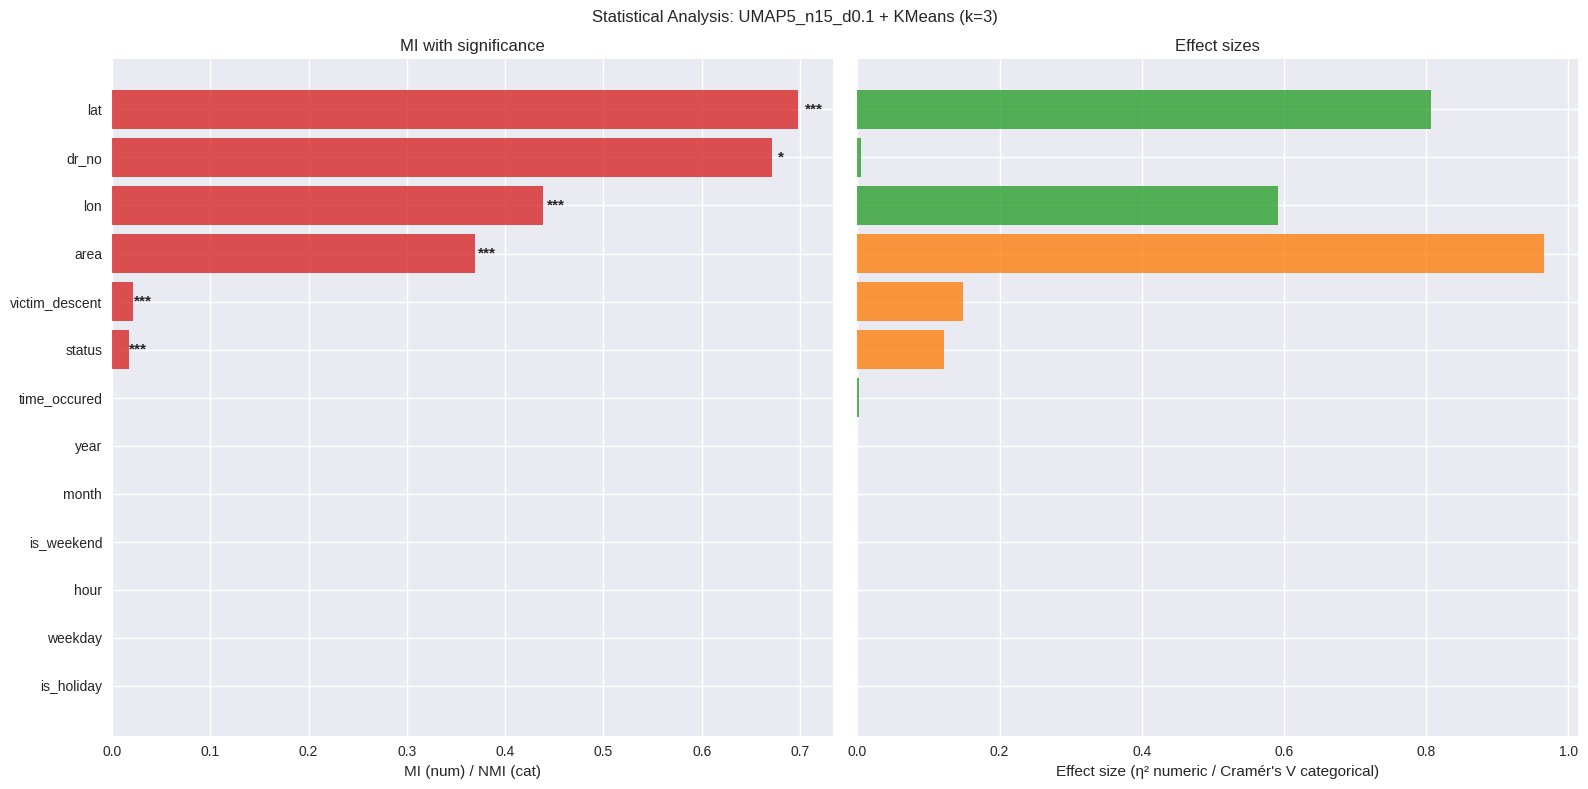


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP5_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

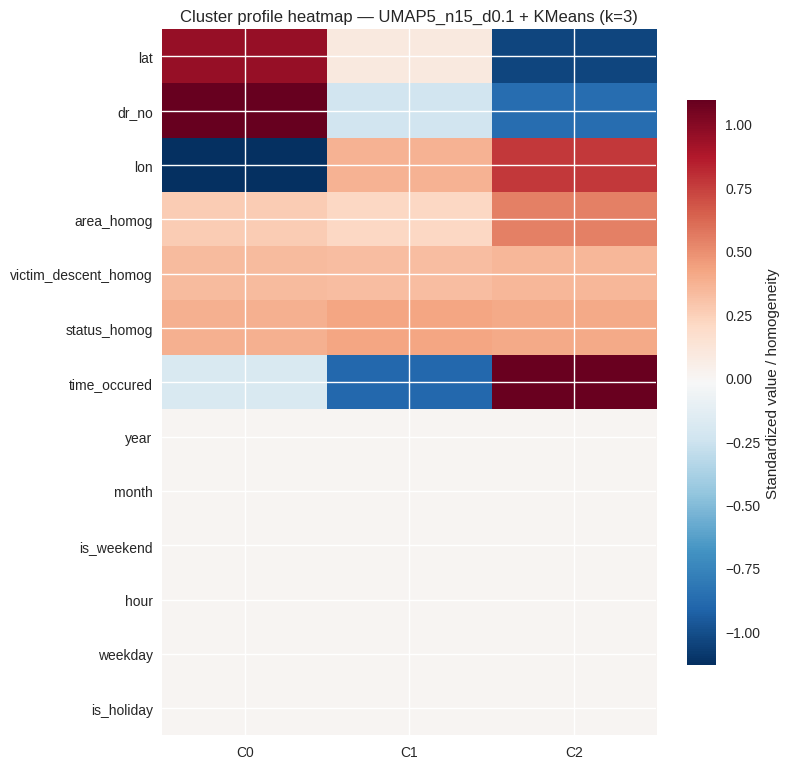


[2/10] UMAP7_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

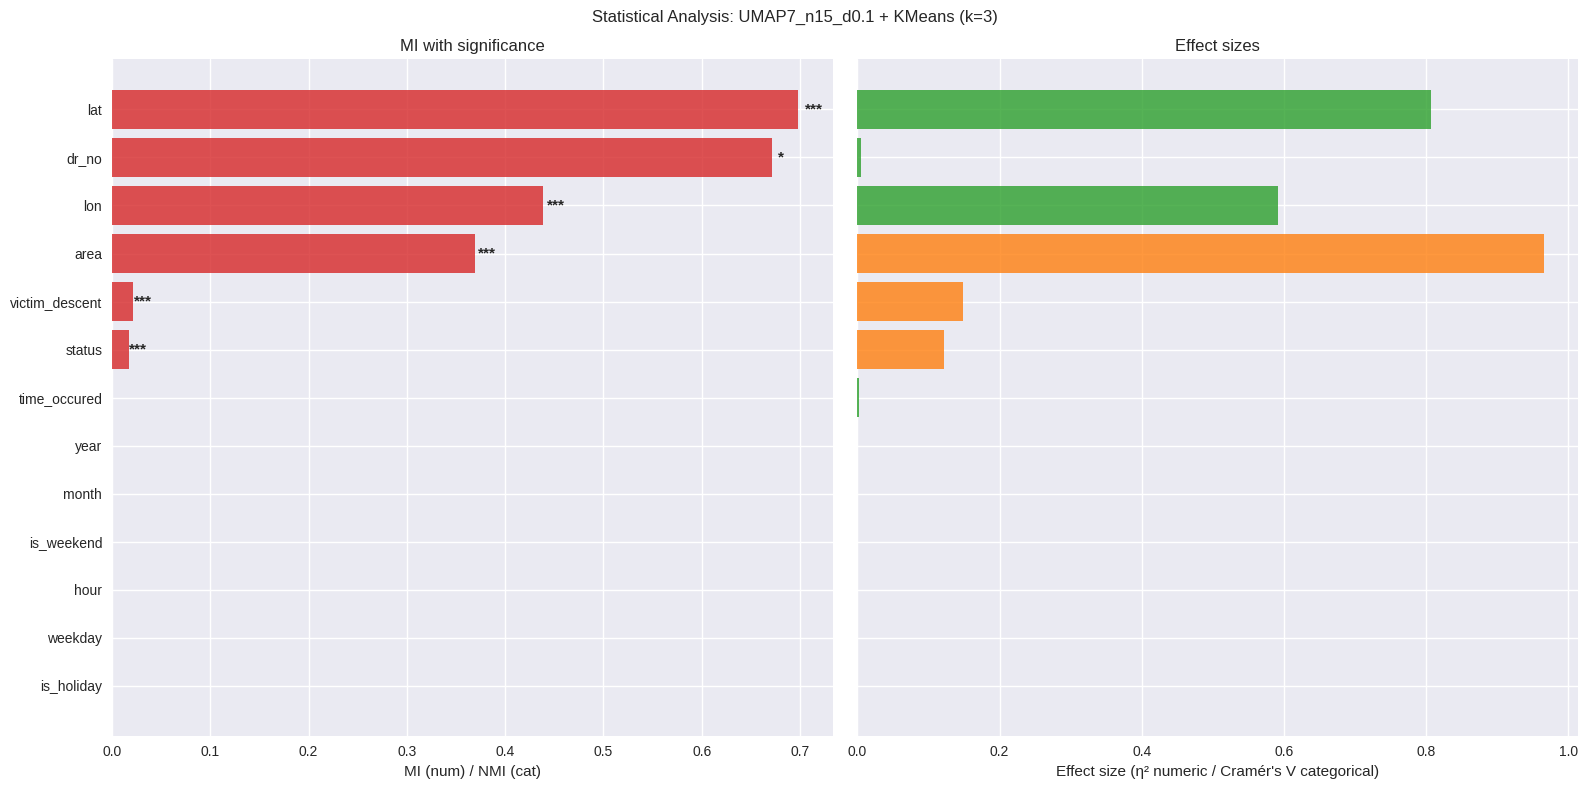


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP7_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

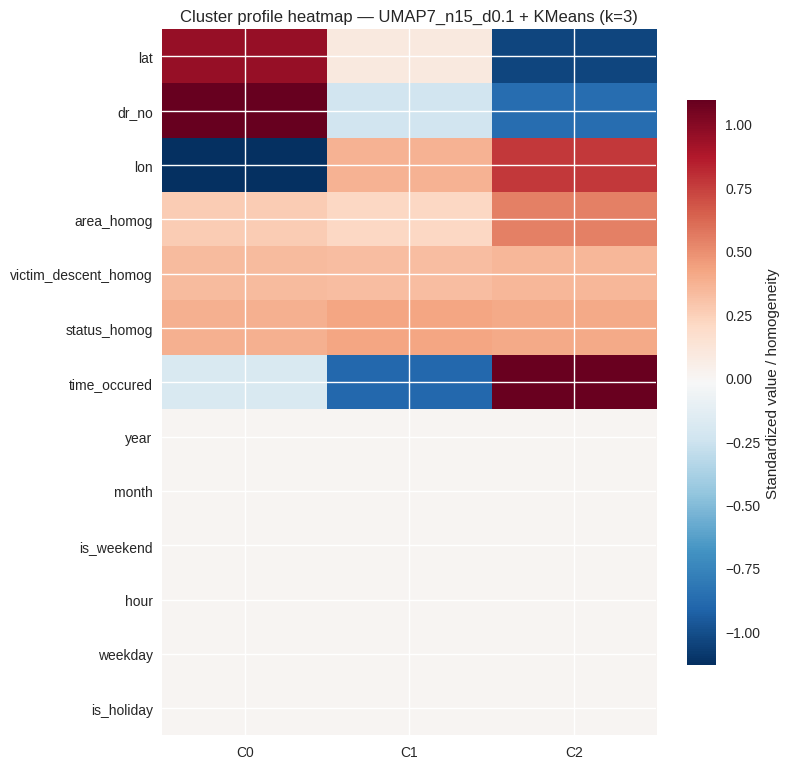


[3/10] UMAP8_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

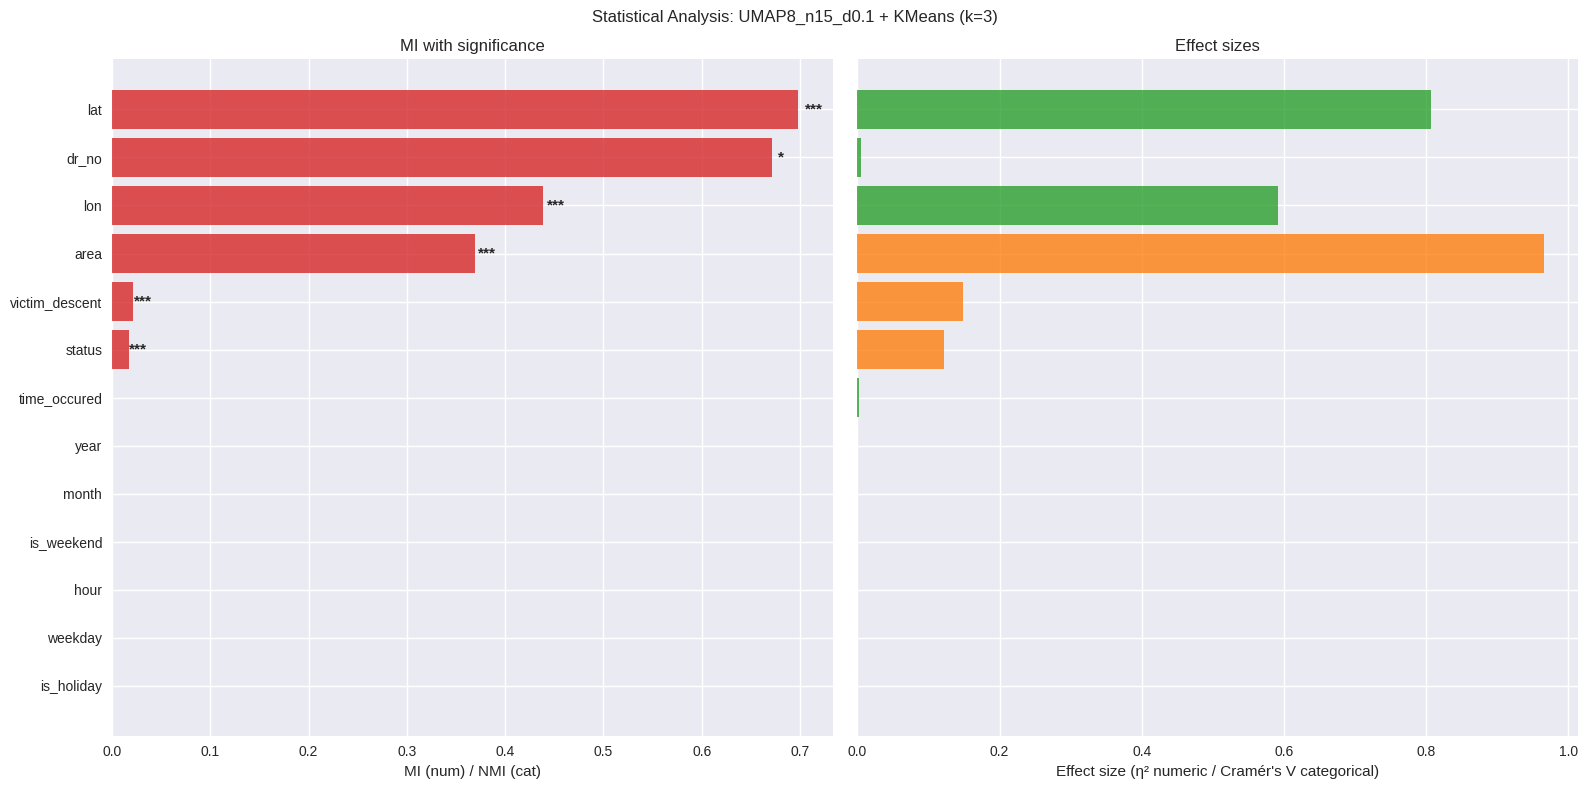


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP8_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

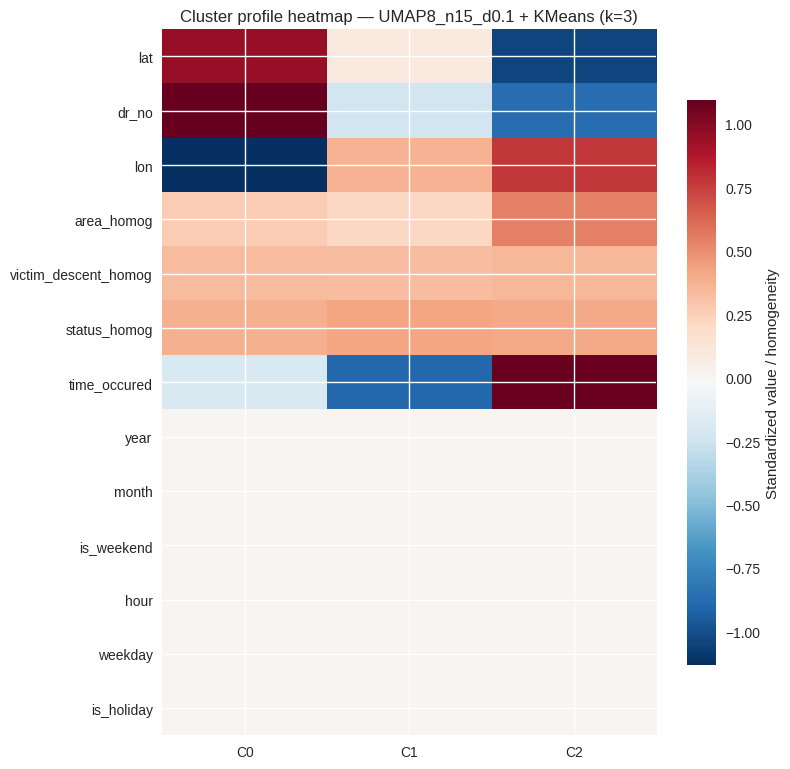


[4/10] UMAP4_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

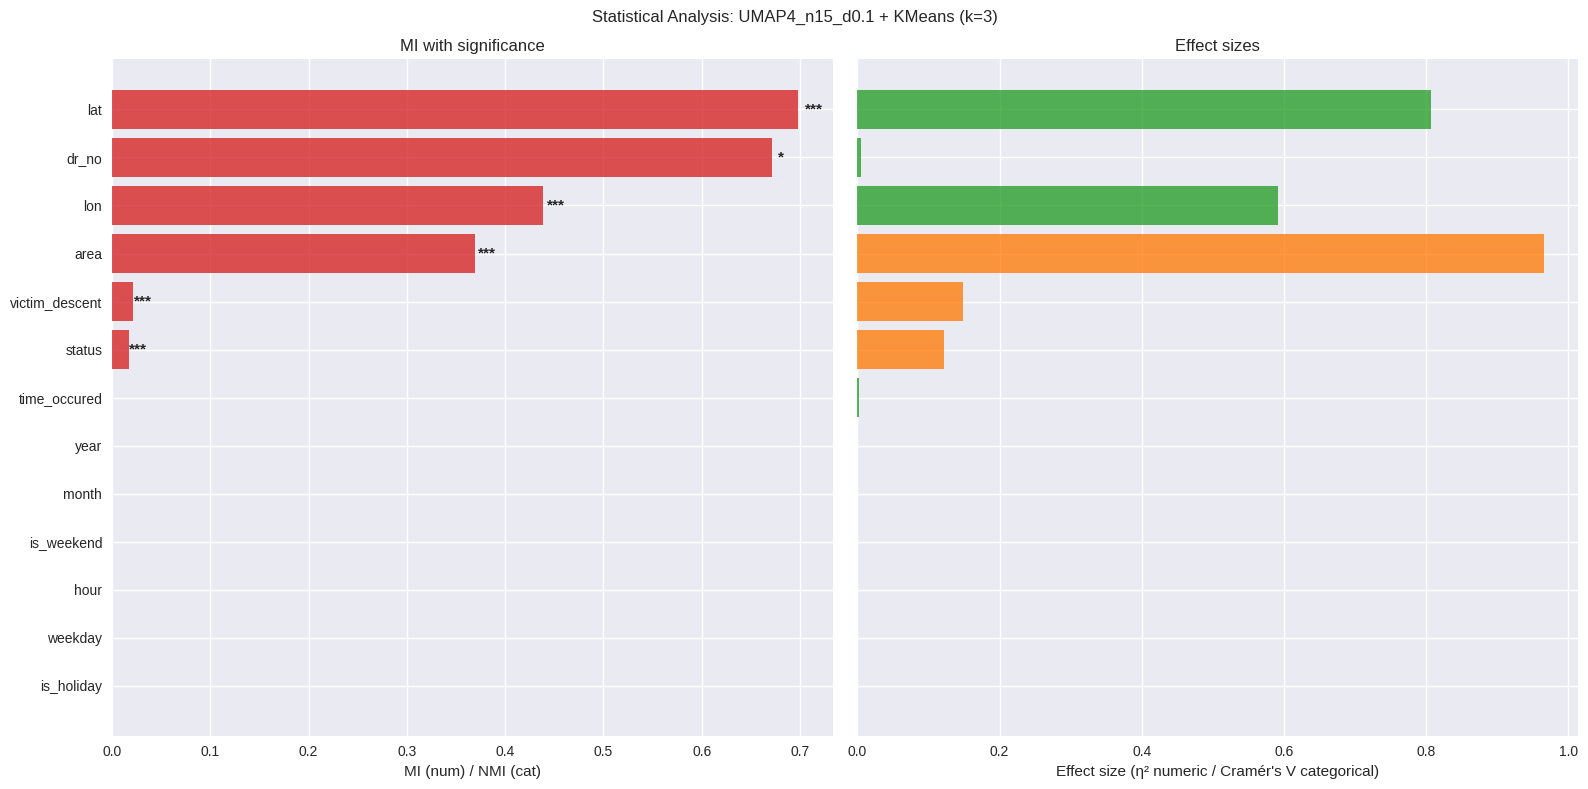


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP4_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

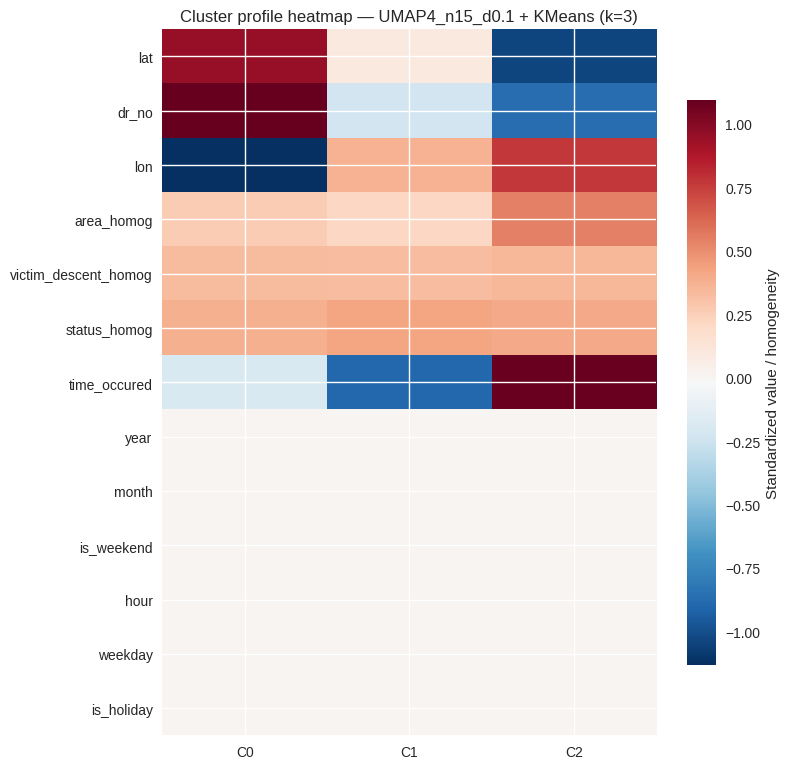


[5/10] UMAP6_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

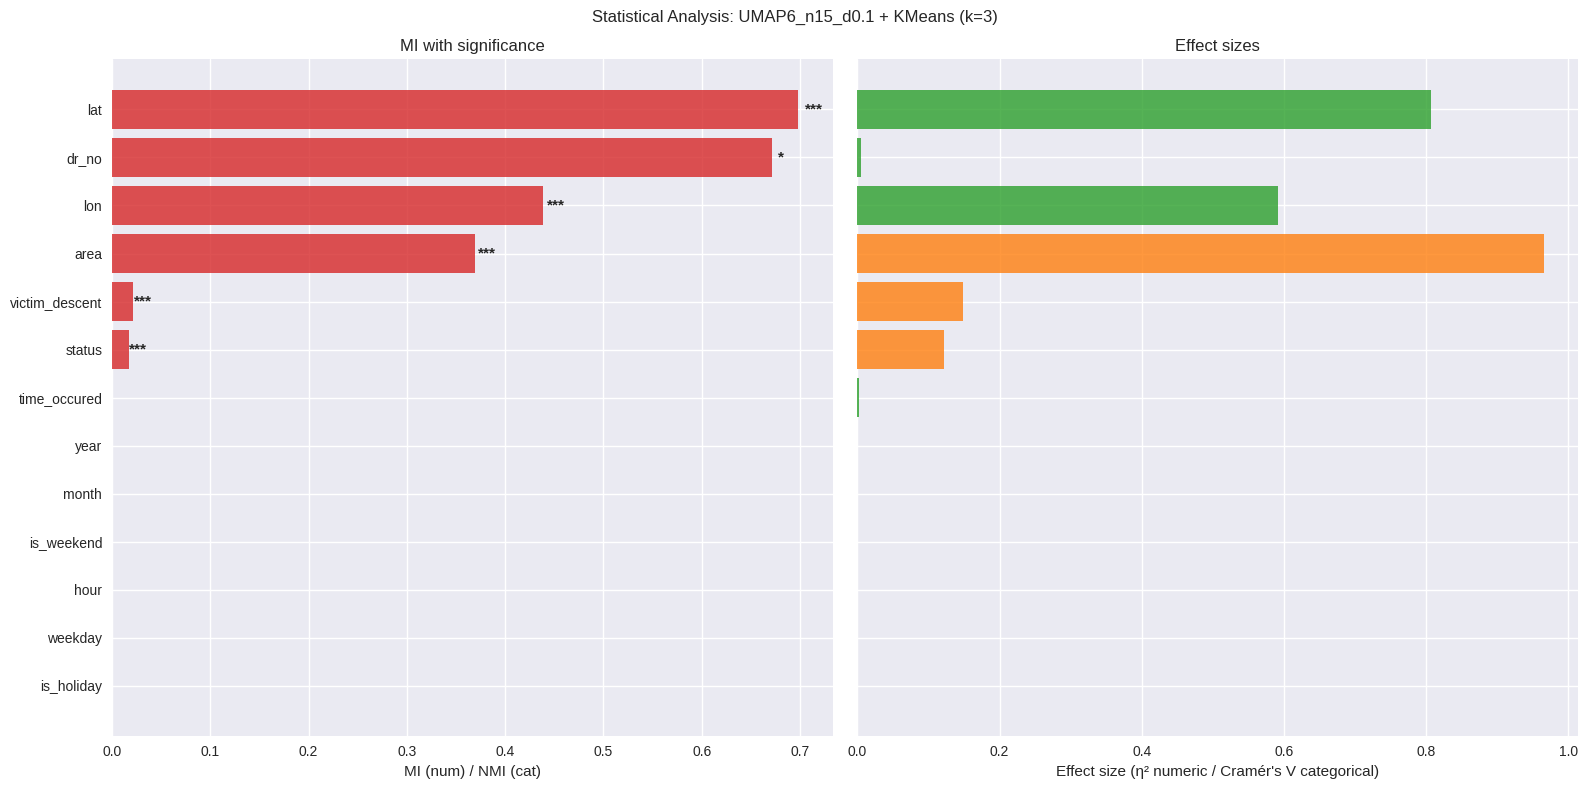


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP6_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

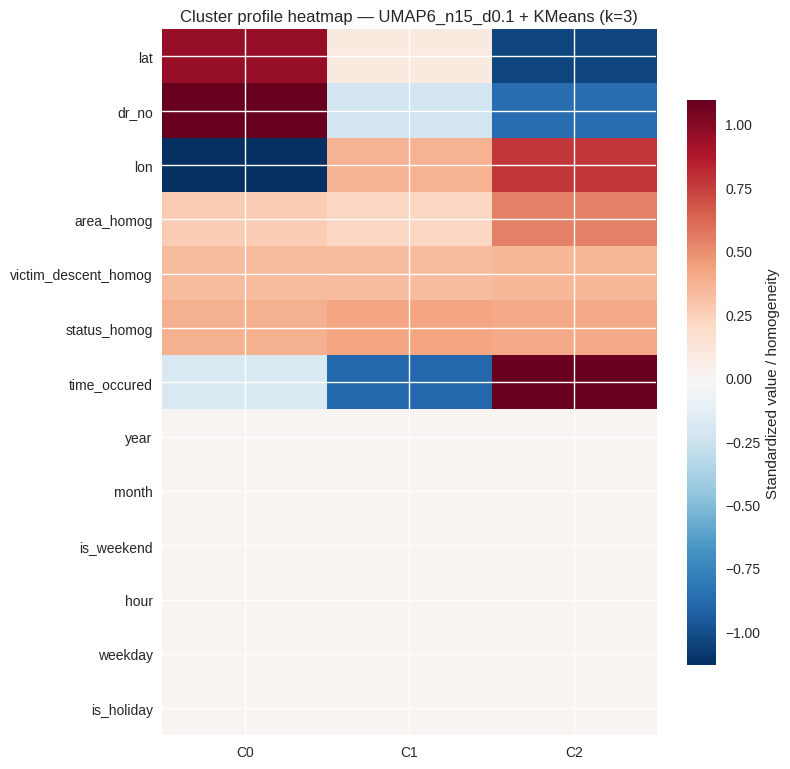


[6/10] UMAP3_n15_d0.1 + KMeans (k=3)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       3457.2934   0.0000    0.6985       0.8075     1651         True
         dr_no     numeric          4.2344   0.0146    0.6712       0.0051     1651         True
           lon     numeric       1193.2583   0.0000    0.4381       0.5915     1651         True
          area categorical       3079.9547   0.0000    0.3691       0.9658     1651         True
victim_descent categorical         72.5055   0.0000    0.0219       0.1482     1651         True
        status categorical         48.8744   0.0000    0.0170       0.1217     1651         True
  time_occured     numeric          1.7040   0.1823    0.0000       0.0021     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

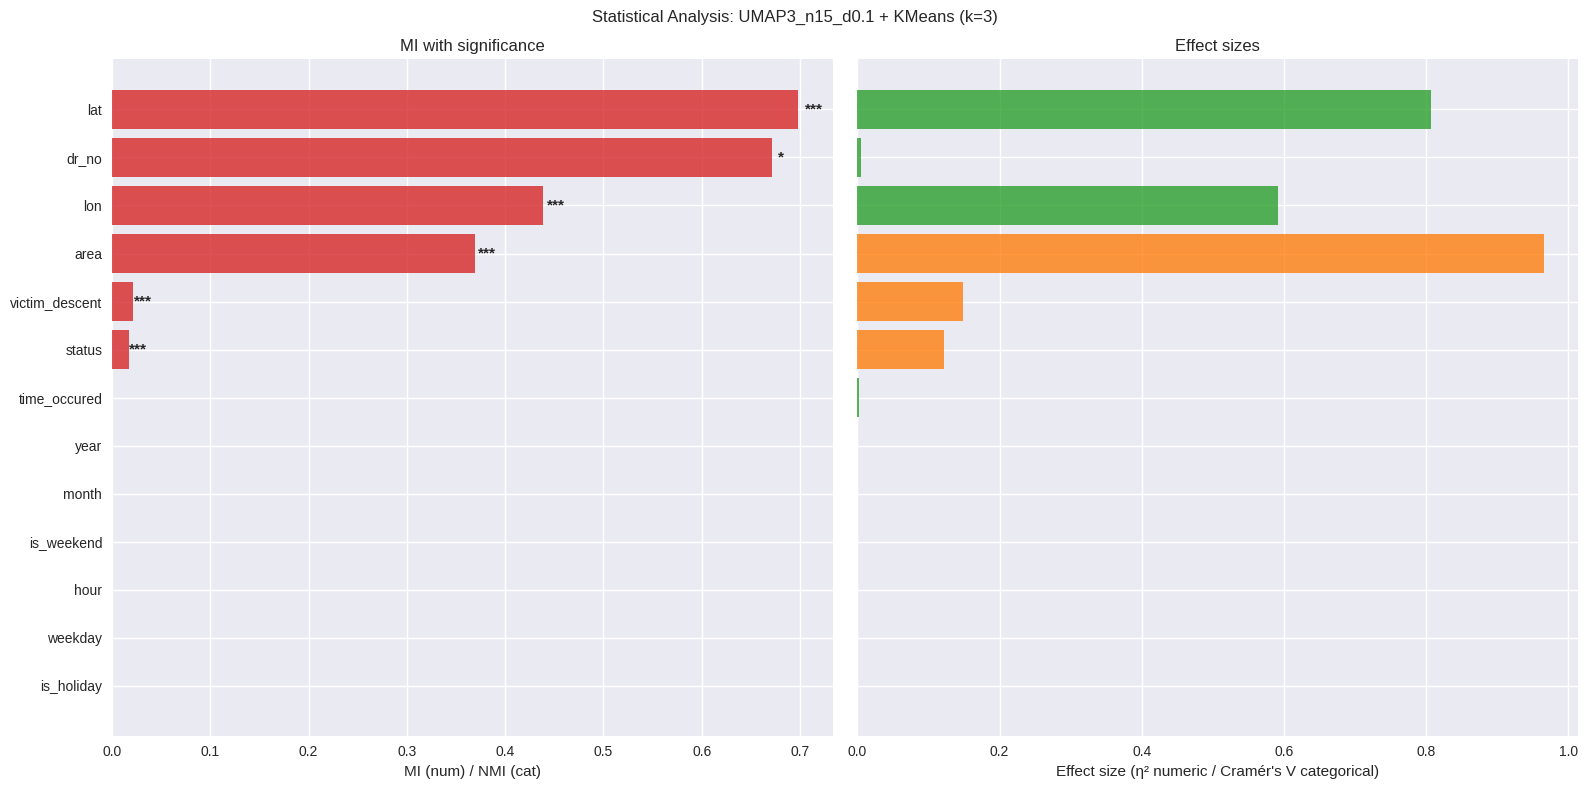


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP3_n15_d0.1 + KMeans (k=3)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.699, p=0
  [NUM] lon: z=-1.40 (low), MI=0.438, p=3.99e-321
  [NUM] dr_no: z=0.13 (high), MI=0.671, p=0.0146
  [CAT] victim_descent: top='H' (49.3%), MI=0.022, p=6.77e-10
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=6.72e-08
  [CAT] area: top='Mission' (17.9%), MI=0.369, p=0

Cluster 1  color=#8c564b  (#features=6)
  [NUM] lon: z=0.39 (high), MI=0.438, p=3.99e-321
  [NUM] lat: z=-0.29 (low), MI=0.699, p=0
  [NUM] dr_no: z=-0.03 (low), MI=0.671, p=0.0146
  [CAT] status: top='Invest Cont' (64.0%), MI=0.017, p=6.72e-08
  [CAT] victim_descent: top='H' (45.6%), MI=0.022, p=6.77e-10
  [CAT] area: top='77th Street' (11.8%), MI=0.369, p=0

Cluster 2  color=#9edae5  (#features=6

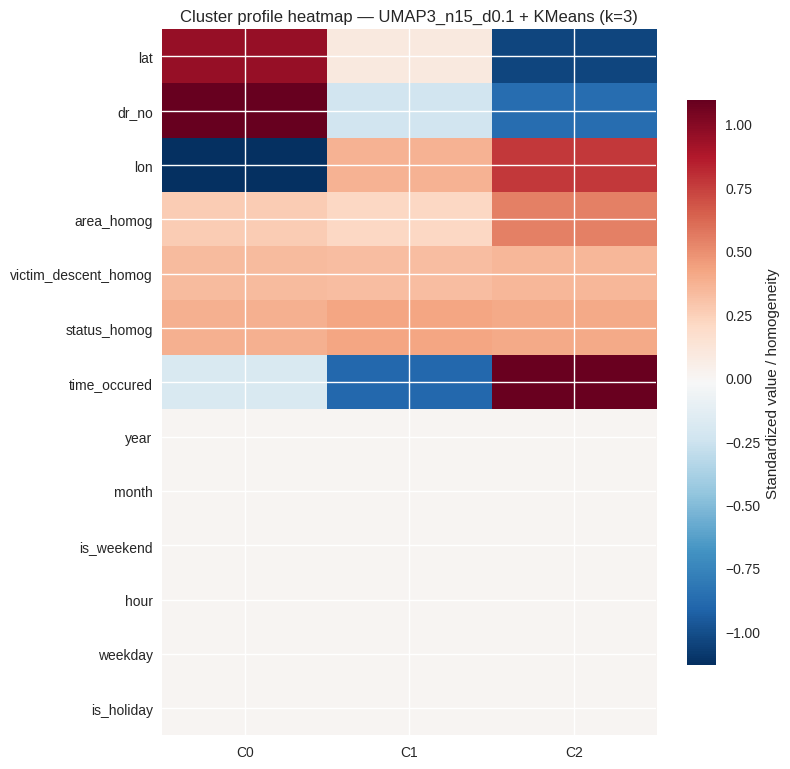


[7/10] UMAP5_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2454.9867   0.0000    0.5310       0.5982     1651         True
         dr_no     numeric          7.7194   0.0055    0.5271       0.0047     1651         True
           lon     numeric       2304.4237   0.0000    0.3817       0.5829     1651         True
          area categorical       1623.4325   0.0000    0.2972       0.9916     1651         True
victim_descent categorical         63.6695   0.0000    0.0205       0.1964     1651         True
        status categorical         44.8944   0.0000    0.0172       0.1649     1651         True
  time_occured     numeric          0.7917   0.3737    0.0057       0.0005     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

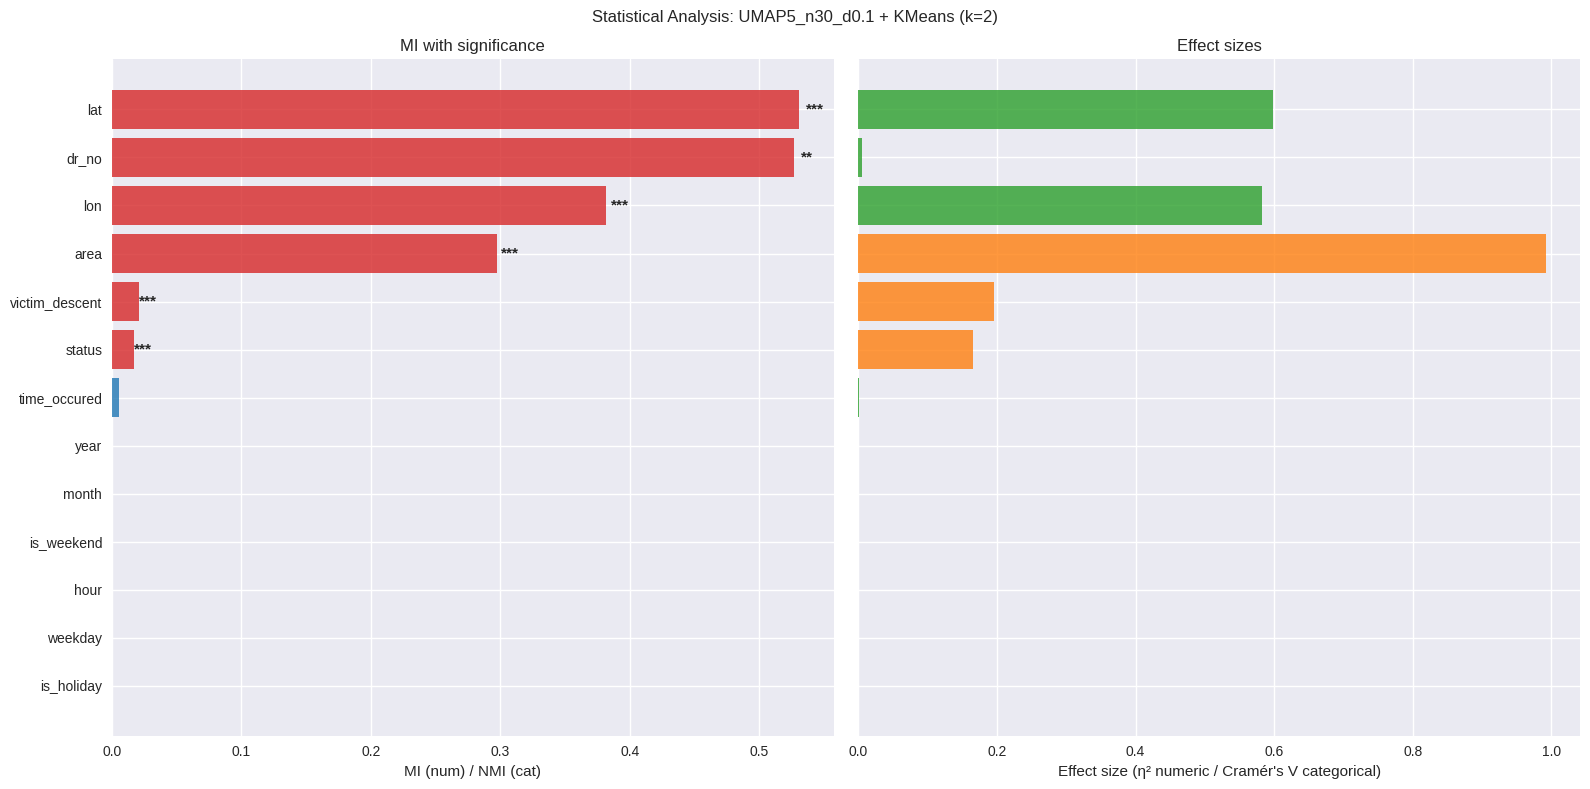


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP5_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.531, p=0
  [NUM] lon: z=-1.40 (low), MI=0.382, p=2.01e-315
  [NUM] dr_no: z=0.13 (high), MI=0.527, p=0.00552
  [CAT] victim_descent: top='H' (49.5%), MI=0.021, p=2.78e-11
  [CAT] status: top='Invest Cont' (44.7%), MI=0.017, p=4.18e-09
  [CAT] area: top='Mission' (18.0%), MI=0.297, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.531, p=0
  [NUM] lon: z=0.42 (high), MI=0.382, p=2.01e-315
  [NUM] dr_no: z=-0.04 (low), MI=0.527, p=0.00552
  [CAT] status: top='Invest Cont' (63.6%), MI=0.017, p=4.18e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.021, p=2.78e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.297, p=0


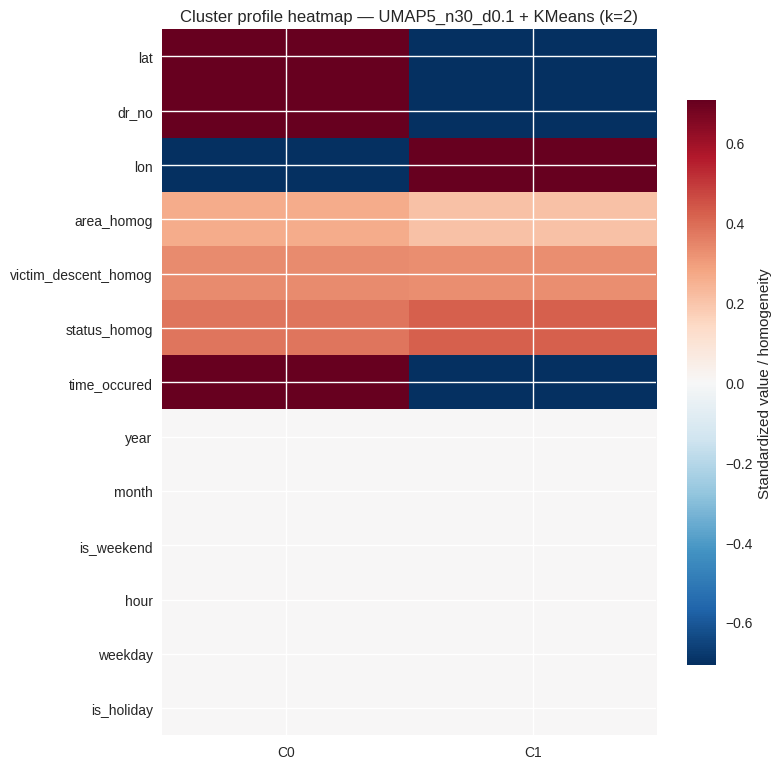


[8/10] UMAP6_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

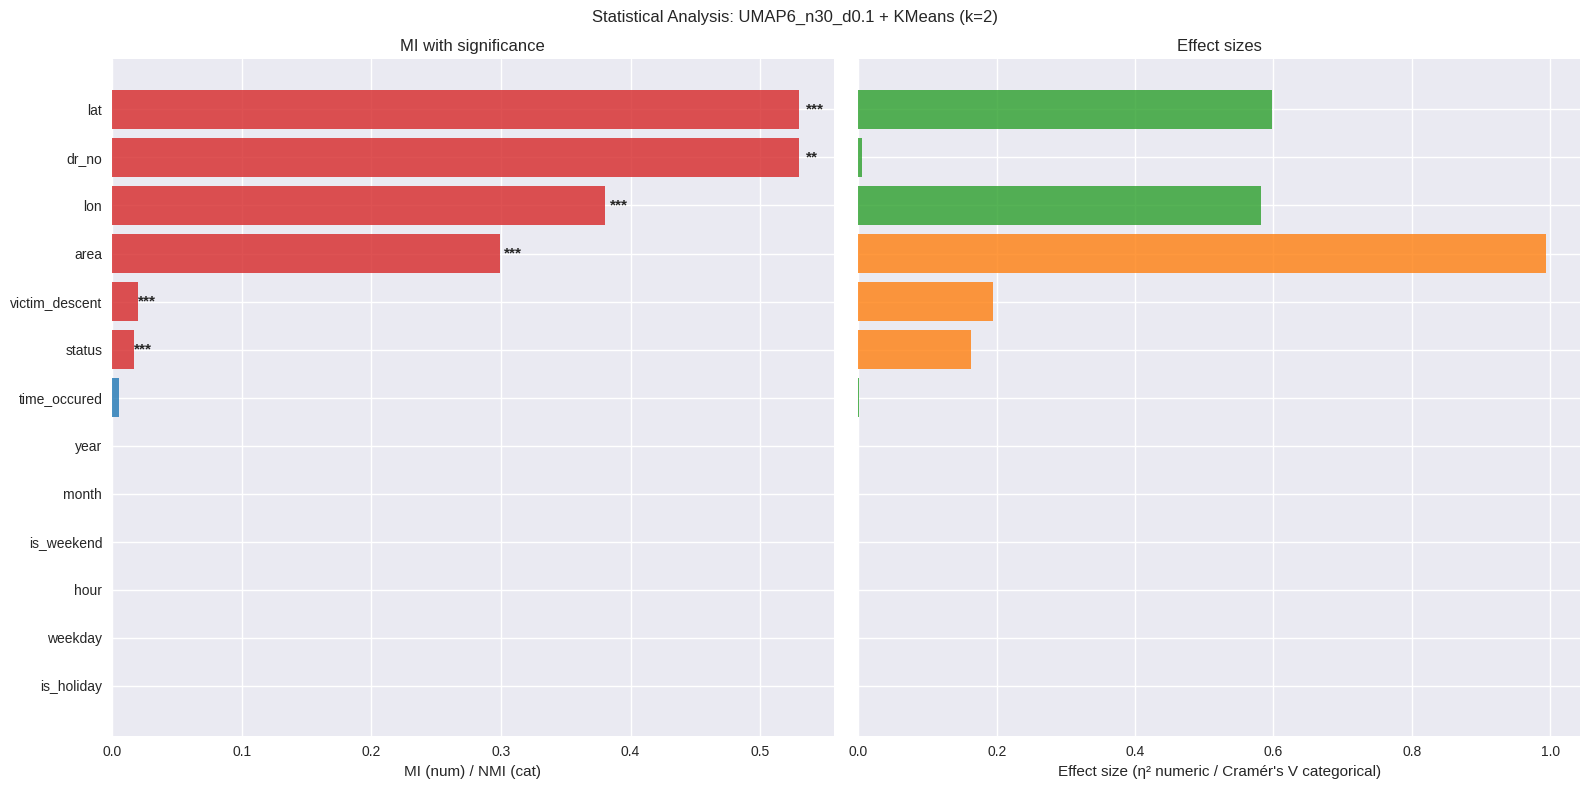


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP6_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


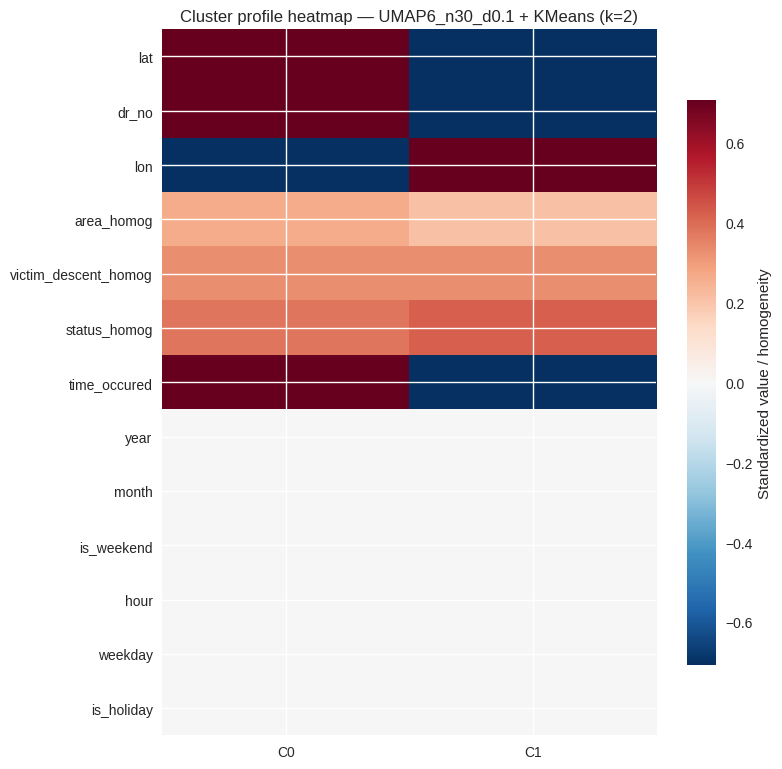


[9/10] UMAP7_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651      

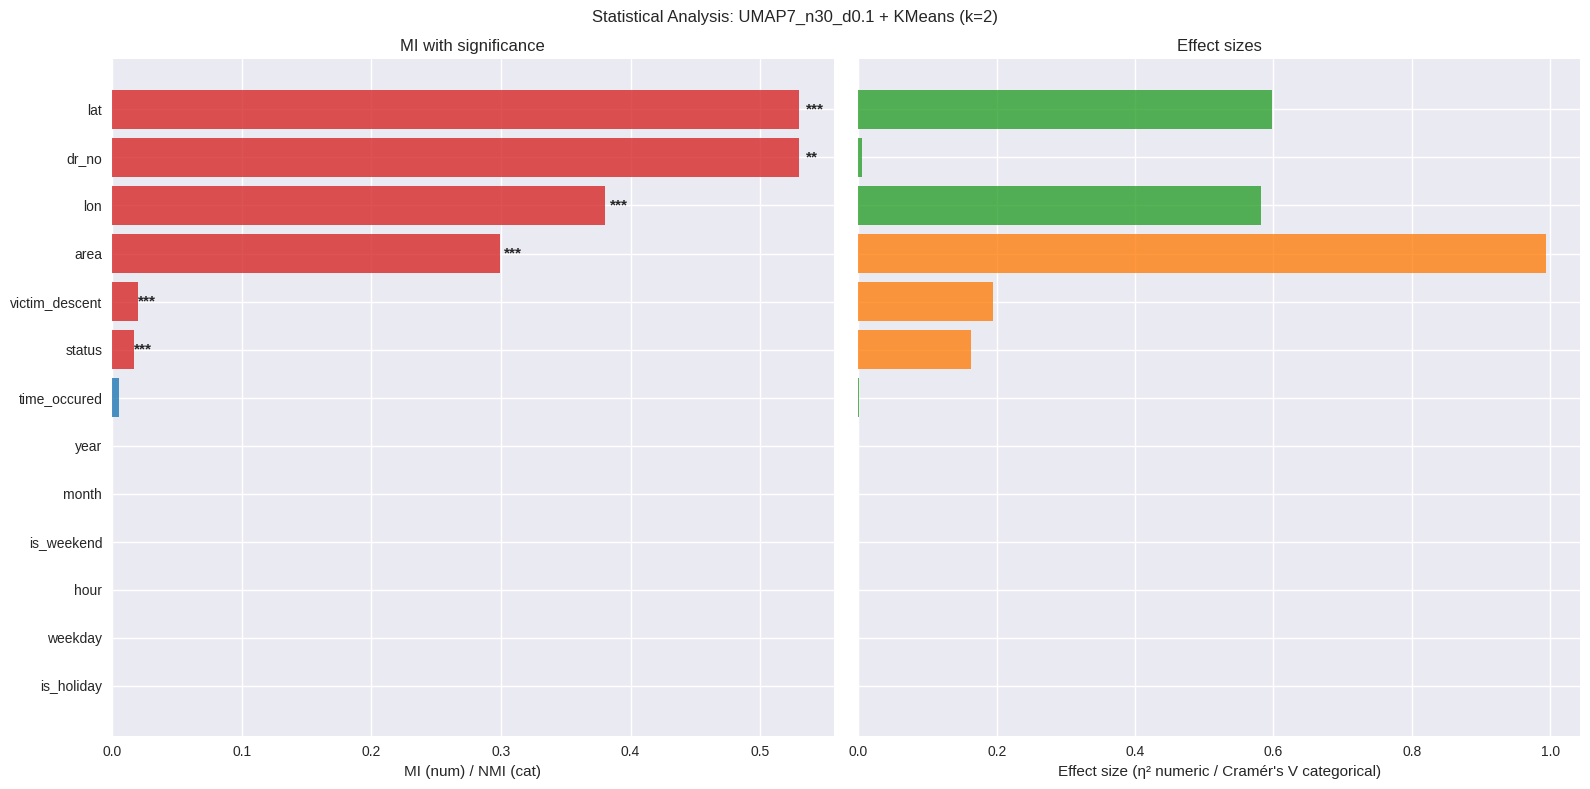


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP7_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


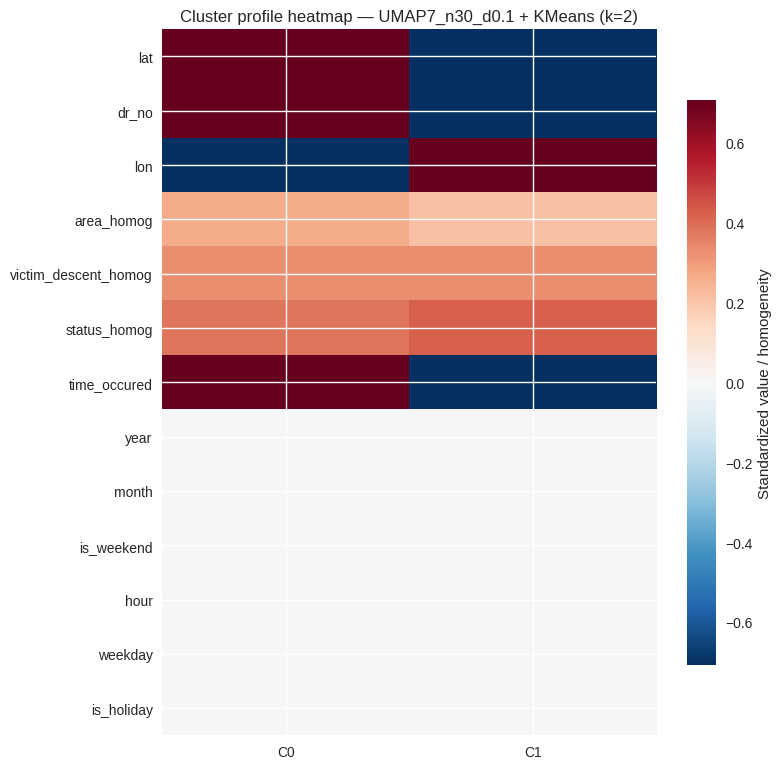


[10/10] UMAP8_n30_d0.1 + KMeans (k=2)
       feature        type  test_statistic  p_value  mi_score  effect_size  n_valid  significant
           lat     numeric       2458.6286   0.0000    0.5301       0.5986     1651         True
         dr_no     numeric          8.0528   0.0046    0.5298       0.0049     1651         True
           lon     numeric       2296.7455   0.0000    0.3803       0.5821     1651         True
          area categorical       1629.0270   0.0000    0.2993       0.9933     1651         True
victim_descent categorical         62.1569   0.0000    0.0200       0.1940     1651         True
        status categorical         44.1786   0.0000    0.0169       0.1636     1651         True
  time_occured     numeric          0.9461   0.3308    0.0053       0.0006     1651        False
          year     numeric             NaN      NaN    0.0000       0.0000     1651        False
         month     numeric             NaN      NaN    0.0000       0.0000     1651     

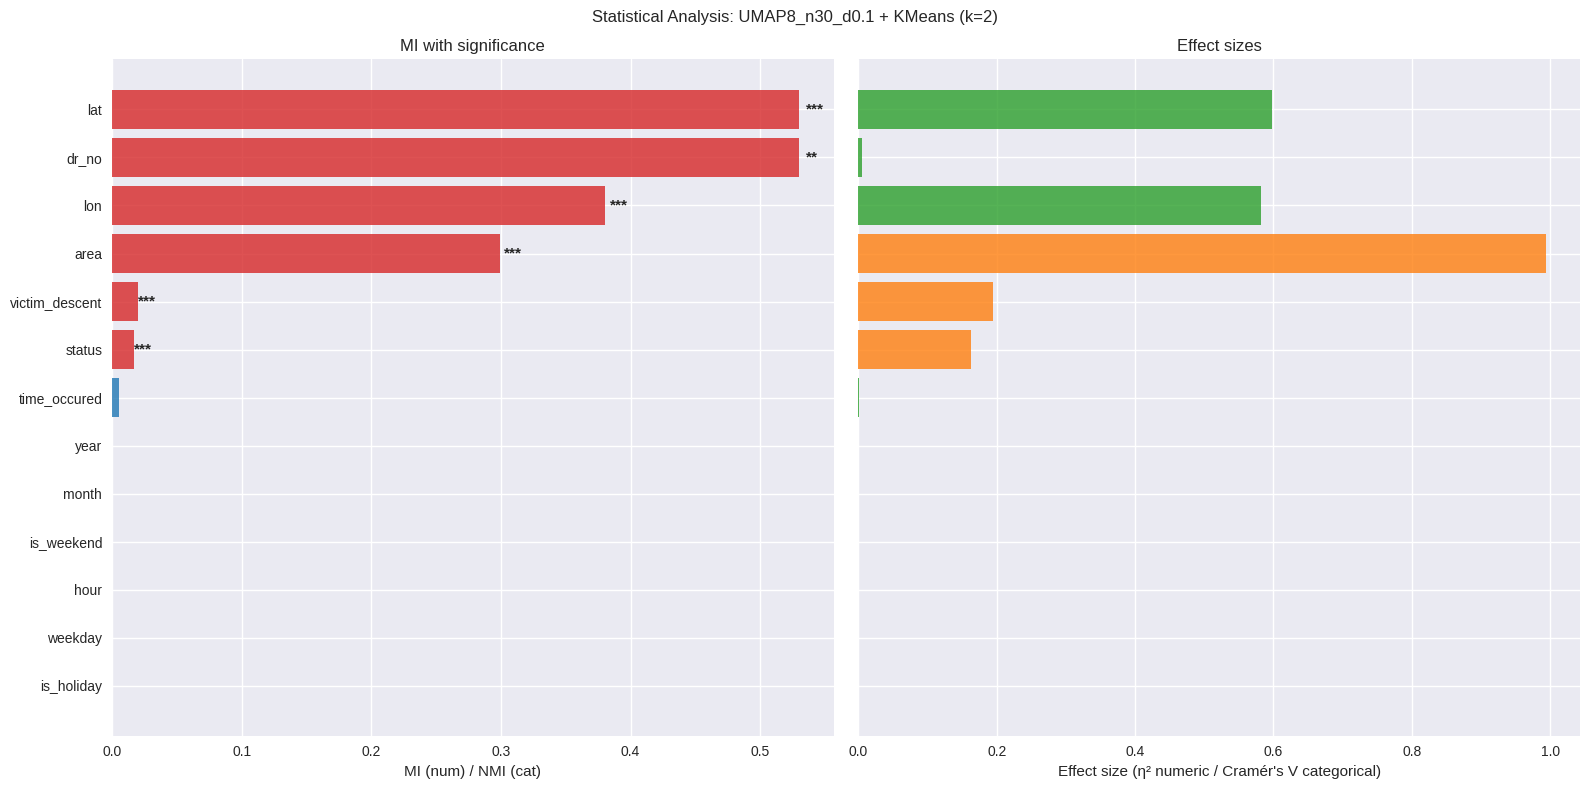


------------------------------------------------------------------------------------------
CLUSTER → FEATURE MAP  |  UMAP8_n30_d0.1 + KMeans (k=2)
------------------------------------------------------------------------------------------

Cluster 0  color=#1f77b4  (#features=6)
  [NUM] lat: z=1.42 (high), MI=0.530, p=0
  [NUM] lon: z=-1.40 (low), MI=0.380, p=1e-314
  [NUM] dr_no: z=0.13 (high), MI=0.530, p=0.0046
  [CAT] victim_descent: top='H' (49.3%), MI=0.020, p=5.59e-11
  [CAT] status: top='Invest Cont' (44.9%), MI=0.017, p=5.89e-09
  [CAT] area: top='Mission' (17.9%), MI=0.299, p=0

Cluster 1  color=#9edae5  (#features=6)
  [NUM] lat: z=-0.42 (low), MI=0.530, p=0
  [NUM] lon: z=0.42 (high), MI=0.380, p=1e-314
  [NUM] dr_no: z=-0.04 (low), MI=0.530, p=0.0046
  [CAT] status: top='Invest Cont' (63.5%), MI=0.017, p=5.89e-09
  [CAT] victim_descent: top='H' (46.1%), MI=0.020, p=5.59e-11
  [CAT] area: top='77th Street' (11.1%), MI=0.299, p=0


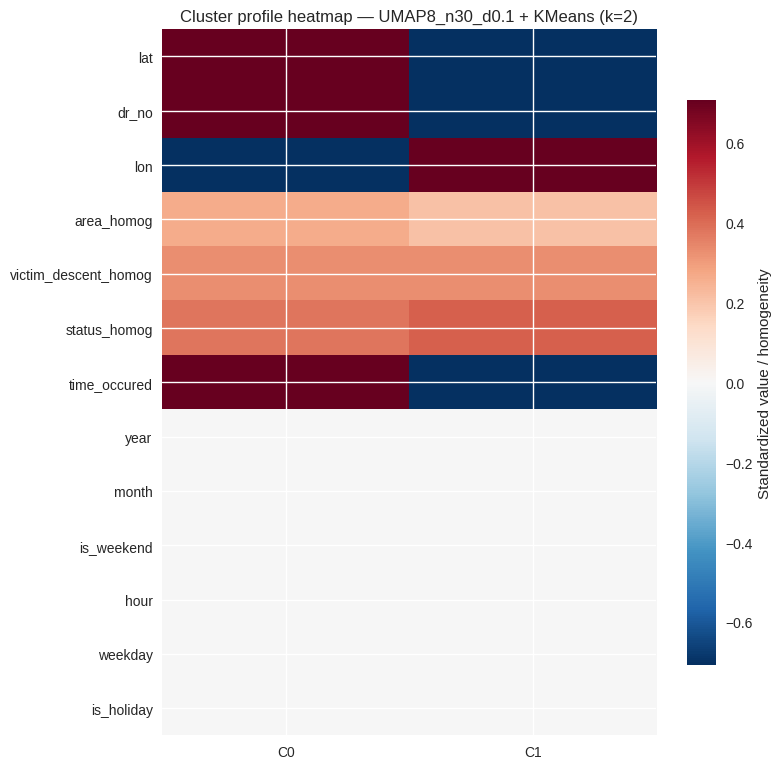


STATISTICAL SIGNIFICANCE SUMMARY (Top-10)
                  combination  n_features  n_significant  significance_rate  max_mi_score top_feature  top_feature_pvalue
UMAP5_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP7_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP8_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP4_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP6_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP3_n15_d0.1 + KMeans (k=3)          13              6             0.4615        0.6985         lat              0.0000
UMAP5_n30_d0.1 + KMeans (k=2)          13              6             0.4615        0.5310         lat  

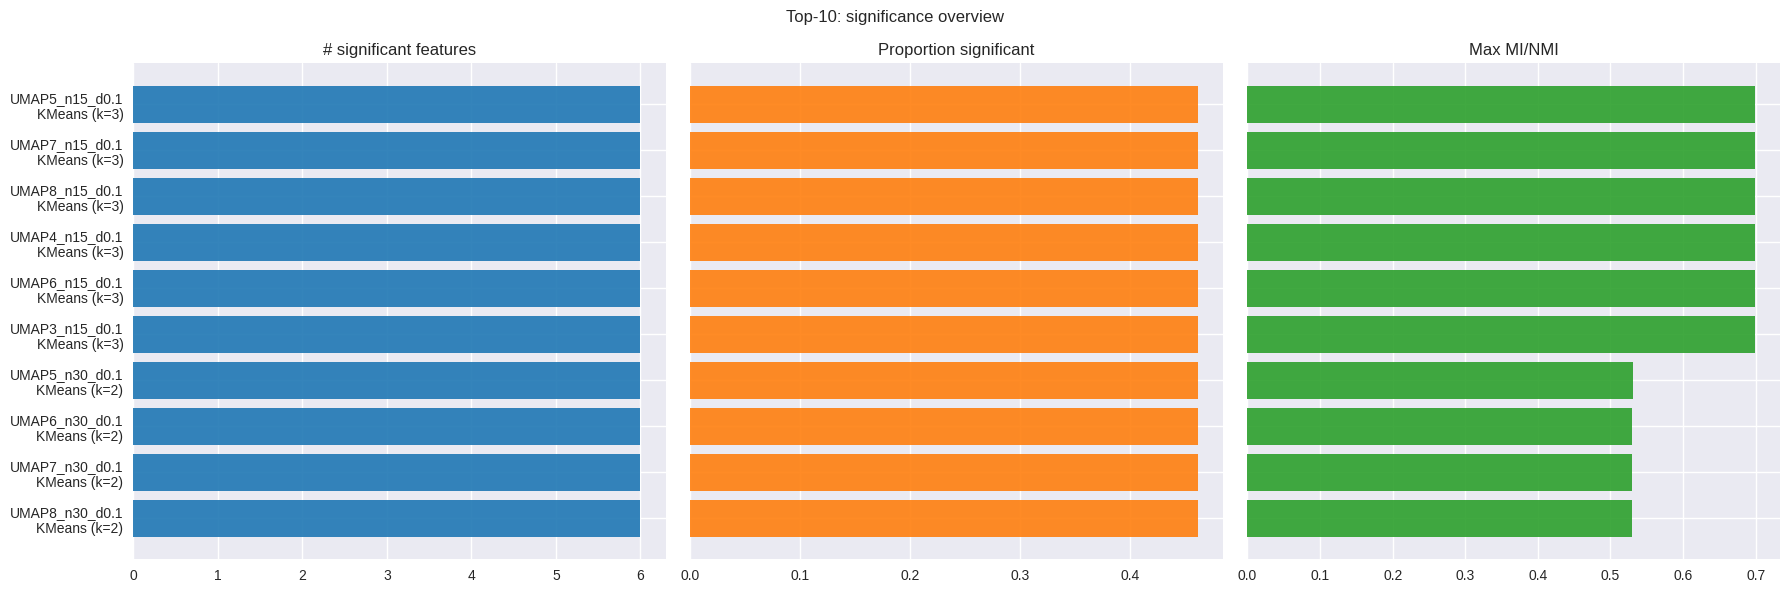

[Saved] /content/figs_comprehensive_unsup/charts/top10_significance_overview.png


In [ ]:
#version3
# =================================================================================================
# TOP-10 CLUSTER INTERPRETATION WITH STATISTICAL SIGNIFICANCE, PRINTED + PLOTTED
# - Fixes NameError (no more `your_top10_list`)
# - Prints all results inline (tables + summaries)
# - Adds per-cluster maps: cluster id + color + the significant features it’s most associated with
# =================================================================================================

import os, re, time, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import normalized_mutual_info_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ------------------------ PATHS & TOP10 (from your last run) ------------------------
CLEAN_PATH = "/content/lapd_clean_5k.parquet"
OUT_BASE   = "/content/cluster_interpretation"
FIG_BASE   = "/content/figs_comprehensive_unsup/charts"
os.makedirs(OUT_BASE, exist_ok=True)
os.makedirs(FIG_BASE, exist_ok=True)

TOP10 = [
    "UMAP5_n15_d0.1 + KMeans (k=3)",
    "UMAP7_n15_d0.1 + KMeans (k=3)",
    "UMAP8_n15_d0.1 + KMeans (k=3)",
    "UMAP4_n15_d0.1 + KMeans (k=3)",
    "UMAP6_n15_d0.1 + KMeans (k=3)",
    "UMAP3_n15_d0.1 + KMeans (k=3)",
    "UMAP5_n30_d0.1 + KMeans (k=2)",
    "UMAP6_n30_d0.1 + KMeans (k=2)",
    "UMAP7_n30_d0.1 + KMeans (k=2)",
    "UMAP8_n30_d0.1 + KMeans (k=2)",
]

# ------------------------ Significance helpers ------------------------
def calculate_statistical_significance(df, labels, alpha=0.05):
    """
    For every column in df vs cluster labels:
      - numeric: ANOVA p, MI (mutual_info_classif), eta^2
      - categorical: chi-square p, NMI, Cramér's V
    Returns sorted DataFrame (by MI/NMI).
    """
    results = []
    uniq = np.unique(labels[labels >= 0])
    if len(uniq) < 2:
        print("Warning: Less than 2 clusters found → skipping significance")
        return pd.DataFrame()

    for col in df.columns:
        if col.startswith("__"):  # skip internal
            continue

        s = df[col]
        valid = s.notna() & (labels >= 0)
        if valid.sum() < 10:
            continue

        s_val = s[valid]
        y_val = labels[valid]

        try:
            if pd.api.types.is_numeric_dtype(s):
                groups = [s_val[y_val == c] for c in uniq]
                groups = [g for g in groups if len(g) > 0]
                if len(groups) < 2:
                    continue

                f_stat, p_value = f_oneway(*groups)
                X_col = s_val.values.reshape(-1, 1)
                mi = mutual_info_classif(X_col, y_val, discrete_features=False, random_state=42)[0]

                ss_total = np.sum((s_val - s_val.mean())**2)
                ss_within = sum(np.sum((g - g.mean())**2) for g in groups)
                eta2 = (ss_total - ss_within) / ss_total if ss_total > 0 else 0.0

                results.append({
                    "feature": col, "type": "numeric",
                    "test_statistic": float(f_stat), "p_value": float(p_value),
                    "mi_score": float(mi), "effect_size": float(eta2),
                    "n_valid": int(len(s_val)), "significant": bool(p_value < alpha)
                })
            else:
                ct = pd.crosstab(s_val, y_val)
                if ct.shape[0] < 2 or ct.shape[1] < 2:
                    continue
                chi2, p_value, dof, exp = chi2_contingency(ct)
                nmi = normalized_mutual_info_score(s_val.astype(str), y_val)
                n = ct.values.sum()
                cramers_v = np.sqrt(chi2 / (n * (min(ct.shape) - 1)))

                results.append({
                    "feature": col, "type": "categorical",
                    "test_statistic": float(chi2), "p_value": float(p_value),
                    "mi_score": float(nmi), "effect_size": float(cramers_v),
                    "n_valid": int(len(s_val)), "significant": bool(p_value < alpha)
                })
        except Exception as e:
            print(f"[WARN] significance failed for {col}: {e}")

    res = pd.DataFrame(results)
    if len(res):
        res = res.sort_values("mi_score", ascending=False).reset_index(drop=True)
    return res

def plot_enhanced_mi(results_df, combo_name, save_path, top_n=20, show=True):
    top_df = results_df.head(top_n).copy()
    if len(top_df) == 0:
        return None
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(8, len(top_df) * 0.4)))
    colors = ['#d62728' if s else '#1f77b4' for s in top_df['significant']]
    bars1 = ax1.barh(range(len(top_df)), top_df['mi_score'], color=colors, alpha=0.8)
    ax1.set_yticks(range(len(top_df))); ax1.set_yticklabels(top_df['feature'])
    ax1.set_xlabel('MI (num) / NMI (cat)'); ax1.set_title('MI with significance')
    ax1.invert_yaxis()
    for i, (bar, p) in enumerate(zip(bars1, top_df['p_value'])):
        mark = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        if mark:
            ax1.text(bar.get_width()*1.01, i, mark, va='center', fontsize=11, weight='bold')
    eff_colors = ['#2ca02c' if t == 'numeric' else '#ff7f0e' for t in top_df['type']]
    ax2.barh(range(len(top_df)), top_df['effect_size'], color=eff_colors, alpha=0.8)
    ax2.set_yticks(range(len(top_df))); ax2.set_yticklabels(['']*len(top_df))
    ax2.set_xlabel("Effect size (η² numeric / Cramér's V categorical)")
    ax2.set_title('Effect sizes'); ax2.invert_yaxis()
    plt.suptitle(f'Statistical Analysis: {combo_name}', y=0.98)
    plt.tight_layout(); plt.savefig(save_path, dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()
    return save_path

def cluster_colors(labels):
    """Map cluster id -> color hex using tab20; -1 (noise) is gray."""
    uniq = sorted(list(set(labels)))
    base = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {}
    i = 0
    for u in uniq:
        if u == -1:
            cmap[u] = (0.6,0.6,0.6,0.7)
        else:
            cmap[u] = base[i % len(base)]
            i += 1
    # convert to hex
    cmap_hex = {k: '#%02x%02x%02x' % (int(v[0]*255), int(v[1]*255), int(v[2]*255)) for k,v in cmap.items()}
    return cmap_hex

def build_cluster_feature_map(df, labels, sig_df, top_k_per_feature=None):
    """
    For each cluster:
      - For significant numeric features: show z-score of cluster mean vs global mean
      - For significant categorical features: show dominant category + share
    Returns: dict(cluster -> list of dicts describing feature associations)
    """
    out = {}
    valid = labels >= 0
    if valid.sum() == 0 or len(sig_df) == 0:
        return out

    dfv = df.loc[valid].copy()
    labv = labels[valid]
    dfv['__cluster'] = labv
    uniq = sorted(dfv['__cluster'].unique())

    for cl in uniq:
        out[cl] = []

    for _, row in sig_df.iterrows():
        f = row['feature']
        if f not in df.columns:
            continue

        if row['type'] == 'numeric' and pd.api.types.is_numeric_dtype(dfv[f]):
            grp = dfv.groupby('__cluster')[f].agg(['mean','count'])
            gmean, gstd = dfv[f].mean(), (dfv[f].std() + 1e-8)
            for cl in uniq:
                if cl in grp.index:
                    z = (grp.loc[cl,'mean'] - gmean) / gstd
                    out[cl].append({
                        "feature": f, "type": "numeric",
                        "z_score": float(z),
                        "direction": "high" if z > 0 else "low",
                        "abs_z": float(abs(z)),
                        "mi_score": float(row['mi_score']),
                        "p_value": float(row['p_value'])
                    })

        else:
            # categorical
            try:
                sub = dfv[['__cluster', f]].dropna()
                if sub.empty:
                    continue
                tab = (sub[sub['__cluster'] >= 0]
                       .groupby(['__cluster', f]).size()
                       .unstack(fill_value=0))
                prop = tab.div(tab.sum(axis=1), axis=0)
                for cl in uniq:
                    if cl in prop.index:
                        top_cat = prop.loc[cl].idxmax()
                        top_share = prop.loc[cl].max()
                        out[cl].append({
                            "feature": f, "type": "categorical",
                            "top_category": str(top_cat),
                            "top_share": float(top_share),
                            "mi_score": float(row['mi_score']),
                            "p_value": float(row['p_value'])
                        })
            except Exception:
                continue

    # Optionally trim to strongest per-cluster
    if top_k_per_feature is not None:
        trimmed = {}
        for cl, feats in out.items():
            # sort numeric by |z|, categorical by top_share
            nums = [d for d in feats if d['type']=='numeric']
            cats = [d for d in feats if d['type']=='categorical']
            nums = sorted(nums, key=lambda d: (abs(d.get('z_score',0)), d.get('mi_score',0)), reverse=True)[:top_k_per_feature]
            cats = sorted(cats, key=lambda d: (d.get('top_share',0), d.get('mi_score',0)), reverse=True)[:top_k_per_feature]
            trimmed[cl] = nums + cats
        return trimmed

    return out

def print_cluster_feature_map(cluster_map, color_map, combo_name, max_lines_per_cluster=30):
    print("\n" + "-"*90)
    print(f"CLUSTER → FEATURE MAP  |  {combo_name}")
    print("-"*90)
    for cl in sorted(cluster_map.keys()):
        feats = cluster_map[cl]
        color = color_map.get(cl, "#999999")
        print(f"\nCluster {cl}  color={color}  (#features={len(feats)})")
        if not feats:
            print("  (no significant associations)")
            continue
        # Order numeric (by |z| desc) first, then categorical (by top_share desc)
        nums = [d for d in feats if d['type']=="numeric"]
        cats = [d for d in feats if d['type']=="categorical"]
        nums = sorted(nums, key=lambda d: (abs(d.get('z_score',0)), d.get('mi_score',0)), reverse=True)
        cats = sorted(cats, key=lambda d: (d.get('top_share',0), d.get('mi_score',0)), reverse=True)
        lines = []
        for d in nums:
            lines.append(f"  [NUM] {d['feature']}: z={d['z_score']:.2f} ({d['direction']}), MI={d['mi_score']:.3f}, p={d['p_value']:.3g}")
        for d in cats:
            lines.append(f"  [CAT] {d['feature']}: top='{d['top_category']}' ({d['top_share']*100:.1f}%), MI={d['mi_score']:.3f}, p={d['p_value']:.3g}")
        if len(lines) > max_lines_per_cluster:
            lines = lines[:max_lines_per_cluster] + [f"  ... (+{len(nums)+len(cats)-max_lines_per_cluster} more)"]
        print("\n".join(lines))

def create_profile_heatmap(df, labels, top_features, combo_name, save_path, show=True):
    """Heatmap where numeric features are standardized means; categoricals use homogeneity proxy."""
    df2 = df.copy()
    df2['__cluster'] = labels
    valid = labels >= 0
    df2 = df2.loc[valid]
    uniq = sorted(df2['__cluster'].unique())
    rows, names = [], []

    for f in top_features:
        if f not in df2.columns:
            continue
        if pd.api.types.is_numeric_dtype(df2[f]):
            m = df2.groupby('__cluster')[f].mean()
            z = (m - m.mean()) / (m.std()+1e-8)
            rows.append(z.reindex(uniq).values)
            names.append(f)
        else:
            def _h(x):
                vc = x.value_counts(normalize=True)
                return 1.0/(1.0 + (-np.sum((vc*np.log2(vc+1e-8)).fillna(0))))
            h = df2.groupby('__cluster')[f].apply(_h)
            rows.append(h.reindex(uniq).values)
            names.append(f + "_homog")

    if len(rows)==0:
        return None

    M = np.vstack(rows)
    plt.figure(figsize=(max(8, len(uniq)*1.4), max(6, len(names)*0.6)))
    im = plt.imshow(M, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='Standardized value / homogeneity', shrink=0.8)
    plt.xticks(range(len(uniq)), [f"C{c}" for c in uniq]); plt.yticks(range(len(names)), names)
    plt.title(f"Cluster profile heatmap — {combo_name}")
    plt.tight_layout(); plt.savefig(save_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close()
    return save_path

# ------------------------ Pipeline integration ------------------------
def integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE, alpha=0.05, top_n_plot=20):
    # Load data
    if CLEAN_PATH.endswith(".parquet"):
        df = pd.read_parquet(CLEAN_PATH)
    else:
        df = pd.read_csv(CLEAN_PATH, low_memory=False)
    print(f"[DATA] Loaded: {df.shape}")

    # Feature prep (same design as before)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if (not pd.api.types.is_numeric_dtype(df[c])) and df[c].nunique() <= 30]
    DROP_LIKE = {"victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code","Crime Code Description","ARREST MADE","Status","Status Desc"}
    use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
    Xdf = df[use_cols].copy()
    for c in Xdf.select_dtypes(include=["bool"]).columns:
        Xdf[c] = Xdf[c].astype(int)

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    pre = ColumnTransformer([
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", ohe, [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ], remainder="drop")

    X_sparse = pre.fit_transform(Xdf)
    svd_comp = min(50, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=svd_comp, random_state=42)
    X_svd = svd.fit_transform(X_sparse)

    # Parse combos, build UMAP embedding on SVD, cluster with KMeans, then analyze
    import umap

    def parse_combo(s):
        # e.g., "UMAP5_n15_d0.1 + KMeans (k=3)"
        m = re.match(r"UMAP(\d+)_n(\d+)_d([0-9]*\.?[0-9]+)\s+\+\s+KMeans\s+\(k=(\d+)\)", s.strip())
        if not m: raise ValueError(f"Cannot parse combo: {s}")
        return dict(n_components=int(m.group(1)), n_neighbors=int(m.group(2)), min_dist=float(m.group(3)), k=int(m.group(4)))

    summaries = []
    all_results = {}

    print("\n" + "="*80)
    print("ENHANCED STATISTICAL SIGNIFICANCE ANALYSIS (Top-10)")
    print("="*80)

    for i, combo in enumerate(TOP10, 1):
        p = parse_combo(combo)
        reducer = umap.UMAP(n_components=p['n_components'], n_neighbors=p['n_neighbors'], min_dist=p['min_dist'],
                            metric="euclidean", random_state=42, verbose=False)
        X_emb = reducer.fit_transform(X_svd)
        km = KMeans(n_clusters=p['k'], n_init=10, random_state=42)
        labels = km.fit_predict(X_emb)

        # significance over original df (excluding DROP_LIKE)
        sig = calculate_statistical_significance(Xdf, labels, alpha=alpha)

        # print a compact inline summary
        n_sig = int(sig['significant'].sum()) if len(sig) else 0
        print(f"\n[{i}/10] {combo}")
        if len(sig):
            print(sig.head(10).to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x,(float,np.floating)) else str(x)))
            print(f"  → features analyzed: {len(sig)} | significant: {n_sig} ({(n_sig/len(sig))*100:.1f}%)")
        else:
            print("  → no analyzable features")

        # plots
        combo_slug = combo.replace(' + ', '_').replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
        mi_fig = os.path.join(FIG_BASE, f"{combo_slug}_enhanced_mi.png")
        if len(sig):
            plot_enhanced_mi(sig, combo, mi_fig, top_n=top_n_plot, show=True)

        # per-cluster map (print!)
        cmap = cluster_colors(labels)
        sig_only = sig[sig['significant']].copy()
        cmap_features = build_cluster_feature_map(Xdf, labels, sig_only, top_k_per_feature=None)
        print_cluster_feature_map(cmap_features, cmap, combo_name=combo, max_lines_per_cluster=50)

        # heatmap of top features (by MI)
        top_feats = sig.head(min(15, len(sig)))['feature'].tolist() if len(sig) else []
        if top_feats:
            hm_fig = os.path.join(FIG_BASE, f"{combo_slug}_profile_heatmap.png")
            create_profile_heatmap(Xdf, labels, top_feats, combo, hm_fig, show=True)

        # save CSV for this combo
        csv_path = os.path.join(OUT_BASE, f"{combo_slug}_statistical_analysis.csv")
        if len(sig):
            sig.to_csv(csv_path, index=False)

        # build summary row
        if len(sig):
            summaries.append({
                "combination": combo, "n_features": int(len(sig)),
                "n_significant": int(n_sig),
                "significance_rate": float(n_sig/len(sig)),
                "max_mi_score": float(sig['mi_score'].max()),
                "top_feature": str(sig.iloc[0]['feature']),
                "top_feature_pvalue": float(sig.iloc[0]['p_value'])
            })
        else:
            summaries.append({
                "combination": combo, "n_features": 0, "n_significant": 0,
                "significance_rate": 0.0, "max_mi_score": np.nan,
                "top_feature": "", "top_feature_pvalue": np.nan
            })
        all_results[combo] = sig

    # Summary table (print + save)
    if summaries:
        summ_df = pd.DataFrame(summaries)
        print("\n" + "="*80)
        print("STATISTICAL SIGNIFICANCE SUMMARY (Top-10)")
        print("="*80)
        print(summ_df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if pd.notna(x) and isinstance(x,(float,np.floating)) else str(x)))

        summ_csv = os.path.join(OUT_BASE, "statistical_significance_summary.csv")
        summ_df.to_csv(summ_csv, index=False)
        print(f"\n[Saved] {summ_csv}")

        # Small combined overview figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        # bars: n_significant
        axes[0].barh(range(len(summ_df)), summ_df['n_significant'], color='tab:blue', alpha=0.9)
        axes[0].set_yticks(range(len(summ_df))); axes[0].set_yticklabels([c.replace(' + ', '\n') for c in summ_df['combination']])
        axes[0].invert_yaxis(); axes[0].set_title("# significant features")

        # proportion
        axes[1].barh(range(len(summ_df)), summ_df['significance_rate'], color='tab:orange', alpha=0.9)
        axes[1].set_yticks(range(len(summ_df))); axes[1].set_yticklabels(['']*len(summ_df))
        axes[1].invert_yaxis(); axes[1].set_title("Proportion significant")

        # max MI
        axes[2].barh(range(len(summ_df)), summ_df['max_mi_score'].fillna(0), color='tab:green', alpha=0.9)
        axes[2].set_yticks(range(len(summ_df))); axes[2].set_yticklabels(['']*len(summ_df))
        axes[2].invert_yaxis(); axes[2].set_title("Max MI/NMI")

        plt.suptitle("Top-10: significance overview", y=0.98)
        plt.tight_layout()
        overview_fig = os.path.join(FIG_BASE, "top10_significance_overview.png")
        plt.savefig(overview_fig, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"[Saved] {overview_fig}")

    return all_results

# ------------------------ Run it ------------------------
_ = integrate_with_existing_pipeline(CLEAN_PATH, TOP10, OUT_BASE, FIG_BASE, alpha=0.05, top_n_plot=20)


#Time series

In [ ]:
# fixed_timeseries_lapd.py
# =============================================================================
# LAPD Daily Crime Forecasting - FIXED VERSION
# Properly handles LAPD date columns and ensures valid time series
# =============================================================================

import os
import warnings
from typing import Dict, Optional, Union, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def _ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p

def _smart_read(df_or_path: Union[pd.DataFrame, str]) -> pd.DataFrame:
    if isinstance(df_or_path, pd.DataFrame):
        return df_or_path.copy()
    if not os.path.exists(df_or_path):
        raise FileNotFoundError(f"File not found: {df_or_path}")
    if df_or_path.lower().endswith(".parquet"):
        return pd.read_parquet(df_or_path)
    return pd.read_csv(df_or_path, low_memory=False)

def _metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.where(y_true == 0, 1.0, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape)}

def _plot_forecast(ds, y_true, y_pred, title, path):
    plt.figure(figsize=(12, 6))
    plt.plot(ds, y_true, label="Actual", lw=2, alpha=0.8)
    plt.plot(ds, y_pred, label="Forecast", lw=2, alpha=0.8)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Daily Crime Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

# Model functions
def _naive_last(y: pd.Series, horizon: int) -> np.ndarray:
    return np.full(horizon, float(y.iloc[-1]))

def _naive_mean7(y: pd.Series, horizon: int) -> np.ndarray:
    tail = y.tail(7)
    val = float(tail.mean()) if len(tail) else float(y.iloc[-1])
    return np.full(horizon, val)

def _fit_predict_sarimax(y_train: pd.Series, horizon: int, seasonal: int = 7):
    try:
        import statsmodels.api as sm
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except ImportError:
        return None, "statsmodels not available"

    try:
        # Try SARIMAX with weekly seasonality
        model = SARIMAX(
            y_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False, maxiter=100)
        forecast = fitted_model.forecast(steps=horizon)
        return forecast.values, None
    except Exception as e:
        # Try simpler ARIMA if SARIMAX fails
        try:
            from statsmodels.tsa.arima.model import ARIMA
            model = ARIMA(y_train, order=(1, 1, 1))
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=horizon)
            return forecast.values, None
        except Exception as e2:
            return None, f"SARIMAX/ARIMA failed: {e}, {e2}"

def _fit_predict_prophet(df_train: pd.DataFrame, horizon: int):
    try:
        from prophet import Prophet
    except ImportError:
        return None, "prophet not available"

    try:
        # Prepare data for Prophet
        prophet_df = df_train.reset_index().rename(columns={df_train.index.name or 'index': 'ds', 'y': 'y'})

        # Initialize Prophet with reasonable parameters for daily crime data
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1,
            seasonality_prior_scale=10.0
        )

        # Fit the model
        model.fit(prophet_df)

        # Make future dataframe
        future = model.make_future_dataframe(periods=horizon, freq='D', include_history=False)

        # Generate forecast
        forecast = model.predict(future)

        return forecast['yhat'].values, None
    except Exception as e:
        return None, f"Prophet failed: {e}"

def _fit_predict_lstm(y_train: pd.Series, horizon: int, lookback: int = 14, epochs: int = 50):
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from sklearn.preprocessing import MinMaxScaler
    except ImportError:
        return None, "tensorflow/keras not available"

    try:
        # Prepare data
        data = y_train.values.reshape(-1, 1).astype(np.float32)

        # Scale data
        scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data)

        # Create sequences
        X, y = [], []
        for i in range(lookback, len(data_scaled)):
            X.append(data_scaled[i-lookback:i, 0])
            y.append(data_scaled[i, 0])

        X = np.array(X).reshape((len(X), lookback, 1))
        y = np.array(y)

        # Build model
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        # Train model
        model.fit(X, y, epochs=epochs, batch_size=32, verbose=0, validation_split=0.1)

        # Generate forecast
        last_sequence = data_scaled[-lookback:].reshape(1, lookback, 1)
        predictions = []

        for _ in range(horizon):
            pred = model.predict(last_sequence, verbose=0)
            predictions.append(pred[0, 0])

            # Update sequence with prediction
            last_sequence = np.roll(last_sequence, -1, axis=1)
            last_sequence[0, -1, 0] = pred[0, 0]

        # Inverse transform
        predictions = np.array(predictions).reshape(-1, 1)
        predictions_original = scaler.inverse_transform(predictions)

        return predictions_original.flatten(), None
    except Exception as e:
        return None, f"LSTM failed: {e}"

def run_lapd_forecasting(
    df_or_path: Union[pd.DataFrame, str],
    out_dir: str = "/content/figs_ts",
    horizon: int = 30,
    eval_days: int = 180,  # Increased for better evaluation
    rolling_splits: int = 3,
    run_models: Optional[List[str]] = None,
    verbose: bool = True,
):
    """
    LAPD-specific time series forecasting with proper date handling
    """
    _ensure_dir(out_dir)
    charts_dir = _ensure_dir(os.path.join(out_dir, "charts"))
    tables_dir = _ensure_dir(os.path.join(out_dir, "tables"))

    if run_models is None:
        run_models = ["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"]

    # Load data and create daily time series
    df = _smart_read(df_or_path)
    y = _daily_counts(df)

    if verbose:
        print("\n==== [TS-1] Daily crime series built ====")
        print(f"Span: {y.index.min().date()} → {y.index.max().date()} ({len(y)} days)")
        print(f"Mean daily crimes: {y.mean():.1f}")
        print(f"Std: {y.std():.1f}")
        print(f"Zero-crime days: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
        print(f"Max daily crimes: {y.max()}")

    # Ensure we have enough data
    if len(y) < eval_days + horizon + 30:
        raise ValueError(f"Not enough data. Need at least {eval_days + horizon + 30} days, have {len(y)}")

    # Rolling origin evaluation
    total_days = len(y)
    split_indices = [
        total_days - eval_days,
        total_days - eval_days + eval_days // 3,
        total_days - horizon
    ]

    if verbose:
        print(f"\n==== [TS-2] Rolling evaluation setup ====")
        print(f"Total data: {total_days} days")
        print(f"Evaluation window: {eval_days} days")
        print(f"Forecast horizon: {horizon} days")
        print(f"Split points: {split_indices}")

    metrics_rows = []
    last_forecasts = {}
    last_test = None

    for split_idx, train_end in enumerate(split_indices):
        if train_end <= horizon:
            continue

        test_start = train_end
        test_end = min(test_start + horizon, len(y))

        y_train = y.iloc[:train_end]
        y_test = y.iloc[test_start:test_end]

        if len(y_test) < horizon:
            continue

        if verbose:
            print(f"\n[Split {split_idx+1}] Train: {y_train.index[0].date()} → {y_train.index[-1].date()}")
            print(f"             Test:  {y_test.index[0].date()} → {y_test.index[-1].date()}")
            print(f"             Size: train={len(y_train)}, test={len(y_test)}")

        # Prepare Prophet dataframe
        df_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})

        # Run models
        for model_name in run_models:
            if model_name == "naive_last":
                yhat = _naive_last(y_train, len(y_test))
                error = None
            elif model_name == "naive_mean7":
                yhat = _naive_mean7(y_train, len(y_test))
                error = None
            elif model_name == "sarimax":
                yhat, error = _fit_predict_sarimax(y_train, len(y_test))
            elif model_name == "prophet":
                yhat, error = _fit_predict_prophet(df_train, len(y_test))
            elif model_name == "lstm":
                yhat, error = _fit_predict_lstm(y_train, len(y_test))
            else:
                continue

            if yhat is not None:
                # Ensure non-negative predictions
                yhat = np.maximum(yhat, 0)

                # Calculate metrics
                metrics = _metrics(y_test.values, yhat)
                metrics.update({
                    'split': split_idx + 1,
                    'model': model_name,
                    'train_size': len(y_train),
                    'test_size': len(y_test)
                })
                metrics_rows.append(metrics)

                # Save last split for visualization
                if split_idx == len(split_indices) - 1:
                    last_forecasts[model_name] = pd.Series(yhat, index=y_test.index)

                if verbose:
                    print(f"  {model_name}: MAE={metrics['MAE']:.2f}, RMSE={metrics['RMSE']:.2f}")
            else:
                if verbose:
                    print(f"  {model_name}: {error}")

        if split_idx == len(split_indices) - 1:
            last_test = y_test

    # Aggregate results
    if metrics_rows:
        metrics_df = pd.DataFrame(metrics_rows)
        avg_metrics = metrics_df.groupby('model')[['MAE', 'RMSE', 'MAPE%']].mean().sort_values('RMSE')

        # Save results
        metrics_df.to_csv(os.path.join(tables_dir, 'detailed_metrics.csv'), index=False)
        avg_metrics.to_csv(os.path.join(tables_dir, 'average_metrics.csv'))

        if verbose:
            print(f"\n==== [TS-3] Average Performance ====")
            print(avg_metrics.round(3).to_string())
    else:
        print("No models produced forecasts")
        return None

    # Generate plots
    if last_test is not None and last_forecasts:
        # Individual model plots
        for model_name, forecast in last_forecasts.items():
            _plot_forecast(
                last_test.index, last_test.values, forecast.values,
                f"{model_name.upper()} - Daily Crime Forecast",
                os.path.join(charts_dir, f"forecast_{model_name}.png")
            )

        # Comparison plot
        plt.figure(figsize=(14, 8))
        plt.plot(last_test.index, last_test.values, label="Actual", lw=3, color='black', alpha=0.8)

        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, (model_name, forecast) in enumerate(last_forecasts.items()):
            plt.plot(forecast.index, forecast.values,
                    label=model_name.upper(), lw=2, alpha=0.7,
                    color=colors[i % len(colors)])

        plt.title("LAPD Daily Crime Forecasting - Model Comparison", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Daily Crime Count", fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        comparison_path = os.path.join(charts_dir, "forecast_comparison.png")
        plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
        plt.close()

        if verbose:
            print(f"\n==== [TS-4] Plots saved ====")
            print(f"Comparison: {comparison_path}")
            for model_name in last_forecasts.keys():
                print(f"{model_name}: {os.path.join(charts_dir, f'forecast_{model_name}.png')}")

    return {
        "daily_series": y,
        "metrics_detailed": metrics_df if metrics_rows else pd.DataFrame(),
        "metrics_average": avg_metrics if metrics_rows else pd.DataFrame(),
        "forecasts": last_forecasts,
        "actual_test": last_test,
        "paths": {
            "charts": charts_dir,
            "tables": tables_dir
        }
    }

# Main execution
if __name__ == "__main__":
    result = run_lapd_forecasting(
        df_or_path=df_full,
        out_dir="/content/figs_ts_fixed",
        horizon=30,
        eval_days=180,
        rolling_splits=3,
        run_models=["naive_last", "naive_mean7", "sarimax", "prophet", "lstm"],
        verbose=True
    )

    if result:
        print("\n==== FORECASTING COMPLETE ====")
        print(f"Charts saved to: {result['paths']['charts']}")
        print(f"Tables saved to: {result['paths']['tables']}")
        print(f"Daily series shape: {result['daily_series'].shape}")
    else:
        print("Forecasting failed - check your data")

  # Install Prophet if needed
!pip install -q prophet

# Save the fixed code
with open('/content/fixed_timeseries_lapd.py', 'w') as f:
    f.write("""# [PASTE THE ARTIFACT CODE HERE]""")


Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=73.57, RMSE=82.46

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  

In [ ]:

results = run_lapd_forecasting(
    df_or_path=df_full,
    out_dir='/content/figs_ts_fixed',
    horizon=30,
    eval_days=180,
    rolling_splits=3,
    run_models=['naive_last', 'naive_mean7', 'sarimax', 'prophet', 'lstm'],
    verbose=True
)

Using date column: 'Date_Reported'

==== [TS-1] Daily crime series built ====
Span: 2020-01-01 → 2024-09-02 (1707 days)
Mean daily crimes: 436.7
Std: 106.3
Zero-crime days: 0 (0.0%)
Max daily crimes: 783

==== [TS-2] Rolling evaluation setup ====
Total data: 1707 days
Evaluation window: 180 days
Forecast horizon: 30 days
Split points: [1527, 1587, 1677]

[Split 1] Train: 2020-01-01 → 2024-03-06
             Test:  2024-03-07 → 2024-04-05
             Size: train=1527, test=30
  naive_last: MAE=85.47, RMSE=95.03
  naive_mean7: MAE=109.04, RMSE=116.69
  sarimax: MAE=91.07, RMSE=97.17
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  lstm: MAE=75.13, RMSE=83.80

[Split 2] Train: 2020-01-01 → 2024-05-05
             Test:  2024-05-06 → 2024-06-04
             Size: train=1587, test=30
  naive_last: MAE=89.47, RMSE=98.03
  naive_mean7: MAE=148.33, RMSE=157.11
  sarimax: MAE=133.92, RMSE=142.07
  prophet: Prophet failed: 'DataFrame' object has no attribute 'unique'
  